# TP1: Classifieur linéaire, fonction de perte **Hinge** de type **one-vs-one**

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Chargement des données et prétraitement

### **TODO** assurez-vous d'exécuter le script *./get_datasets.sh* au moins une fois dans un terminal.

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))

    # Normalisation
    X_train -= np.mean(X_train, axis = 0)
    X_val -= np.mean(X_val, axis = 0)
    X_test -= np.mean(X_test, axis = 0)
    X_dev -= np.mean(X_dev, axis = 0)
    X_batch -= np.mean(X_batch, axis = 0)

    # Ajout du biais
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    X_batch = np.hstack([X_batch, np.ones((X_batch.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)
batch data shape:  (200, 3073)
batch labels shape:  (200,)


## Classifieur linéaire avec fonction de perte de type "Hinge loss"

Le code pour cette section est dans le fichier **utils/loss.py**. 

La fonction `hinge_naive_forward_backward` estime la perte (et le gradient) à l'aide de boucles `for` qui itèrent sur chaque donnée de la mini-batch.  

**NOTE IMPORTANTE**: les solutions que vous devez obtenir proviennent d'une implantation de type **one-vs-one** de la fonction *Hinge*.  Si nous aviez à coder une solution **one-vs-all** (également appelée *one-vs-rest*) vous devriez obtenir une loss de 8.63 (au lieu de 1.28) pour la cellule suivante et 9.09 (au lieu de 1.53) pour la cellule d'après.


In [4]:
##############################################################################
# TODO: Implémenter le calcul de perte de façon naive avec des boucles dans  #
#  la fonction hinge_naive_forward_backward située dans le fichier           #
#  utils.loss.                                                               #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

from utils.loss import hinge_naive_forward_backward

# Matrice de poids aléatoires + 1 donnée à tester
np.random.seed(0)
W = np.random.randn(3073, 10) * 5e-4
X_rnd = np.random.randn(1, 3073) * 5
y_rnd = np.uint32(np.ones(1))
loss, _ = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.28220758164
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)

Bravo!
loss error: 0.000000


In [5]:
##############################################################################
# TODO: Même chose qu'à la cellule précédente mais...                        #
#   vec N=500 images et autant de cibles                                     #
##############################################################################

# Matrice de poids aléatoires + 500 données 
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
loss, _ = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

target_loss = 1.53644079
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-6:
    print("Bravo!")
else:
    print("Il y a un bug...")
print('loss error: %f' % loss_error)


Bravo!
loss error: 0.000000


## Question 1:
   
Expliquez pourquoi lorsque la matrice de poids W est initialisée avec des valeurs proches de zéro, la **hinge loss** tend vers 1.0.

**Réponse :** La hinge loss tend vers 1, car pour des poids initialisés avec des valeurs proches de zéro, la différence entre le score de la classe prédite et celui de la classe cible sera faible, à savoir comprise entre -1 et 1. Donc, étant donné le calcul de la hinge loss, moins il y a d'erreurs de prédiction, plus la loss tendra vers 1 (car la différence des scores tendra vers 0). 

## Rétro-propagation

Maintenant, passons à la **rétro-propagation**!

In [6]:
##############################################################################
# TODO: Implémenter le calcul de perte ET DE LA RÉTROPROPAGATION de façon    #
#       naive avec des boucles dans la fonction                              #
#       hinge_naive_forward_backward située dans le fichier utils.loss       #
#                                                                            #
#  On commence par UNE image et UNE cible                                    #
##############################################################################

# Matrice de poids aléatoires + une donnée
np.random.seed(0)
W = np.random.randn(3073, 10) * 1e-4
X_rnd = np.random.randn(1, 3073)
y_rnd = np.uint32(np.ones(1))
loss, dW = hinge_naive_forward_backward(X_rnd, W, y_rnd, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.011288303265
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([0.0, 1.28672636, 0.0])
dW_error = np.mean(np.abs(dW[0,0:3]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


In [7]:
##############################################################################
# TODO:                                                                      #
#  Maintenant on test avec N=200 images et autant de cibles                  #
##############################################################################

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
loss, dW = hinge_naive_forward_backward(X_batch, W, y_batch, 0.0)

# La loss suivante est celle que vous devriez obtenir
target_loss = 1.5373299967
loss_error = np.abs(loss - target_loss)
if loss_error < 1e-5:
    print("Bravo pour la loss!")
else:
    print("Il y a un bug au niveau de la loss...")
print('loss error: %f' % loss_error)

# Le gradient suivant est celui que vous devriez obtenir pour les 3 premiers poids
target_dW = np.array([-2.395425, -0.840625, -0.32925, 7.256375])
dW_error = np.mean(np.abs(dW[0,0:4]-target_dW))
if dW_error < 1e-7:
    print("Bravo pour le gradient!")
else:
    print("Il y a un bug au niveau du gradient...")
print('gradient error %f' % dW_error)

Bravo pour la loss!
loss error: 0.000000
Bravo pour le gradient!
gradient error 0.000000


### Encore quelques vérifications d'usage
En principe, à ce point-ci, le calcul de la hinge loss (et de son gradient) via la fonction *hinge_naive_forward_backward* devrait fonctionner.  Mais avant de passer à la prochaine étape il nous reste deux vérifications à faire : s'assurer que la **régularisation** fonctionne et passer le test du **gradient numérique**

In [8]:
##############################################################################
# En principe, le fait d'augmenter le terme de régularisation L2 devrait     #
# augmenter la loss...                                                       #
##############################################################################
success = True

# Matrice de poids aléatoires + 500 données
np.random.seed(1)
W = np.random.randn(3073, 10) * 1e-4
prev_loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, 0.0)

reg = 1e2
for i in range(10):
    loss, _ = hinge_naive_forward_backward(X_dev, W, y_dev, reg)
    print(loss)
    if loss <= prev_loss:
        success = False
    prev_loss = loss
    reg *= 1.5
    
if success:
    print("Bravo!")
else:
    print('Erreur!')


1.5916653248482846
1.5993353369785692
1.610840355173996
1.6280978824671364
1.653984173406847
1.6928136098164128
1.7510577644307617
1.8384239963522848
1.9694733442345695
2.1660473660579966
Bravo!


In [9]:
##############################################################################
# Maintenant testons le gradient numérique avec et sans régularisation       #
# Les erreurs relatives devraient être inférieures à 1e-6                    #
##############################################################################
from utils.gradients import check_gradient_sparse

print("\n------------\nGradient check : reg=0\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 0.0)

# Faire un autre test de gradients avec régularisation 
print("\n------------\nGradient check : reg=1e-2\n------------\n")
check_gradient_sparse(hinge_naive_forward_backward, W, X_dev, y_dev, 1e2)


------------
Gradient check : reg=0
------------

numerical: 1.201600, analytic 1.201600, relative error: 2.295000e-11
numerical: -0.439236, analytic -0.439236, relative error: 4.872508e-10
numerical: -1.045968, analytic -1.045968, relative error: 1.636156e-10
numerical: 0.163760, analytic 0.163760, relative error: 1.031721e-09
numerical: -3.257168, analytic -3.257168, relative error: 1.987534e-11
numerical: -11.200256, analytic -11.200256, relative error: 5.360669e-13
numerical: 1.022208, analytic 1.022208, relative error: 9.722163e-11
numerical: -4.651296, analytic -4.651296, relative error: 9.306280e-12
numerical: -1.051856, analytic -1.051856, relative error: 6.833440e-11
numerical: -1.658928, analytic -1.658928, relative error: 7.592435e-11

------------
Gradient check : reg=1e-2
------------

numerical: 1.706443, analytic 1.731800, relative error: 7.374914e-03
numerical: 0.909804, analytic 0.920784, relative error: 5.998030e-03
numerical: 2.458095, analytic 2.470172, relative er

## Hinge loss et gradients vectorisés
Passons maintenant aux choses sérieuses. Vous devez ici coder la version vectorisée de l'entropie croisée et du gradient dans la fonction **hinge_naive_forward_backward**.  Ce code s'apparente à la réponse que vous avec donné au début.

### Question 2:  
Les prochaines étapes consistent à implanter le calcul de la loss et du gradient de la loss de façon **linéarisée**.  Avant de commencer à coder, veuillez donner ici la formule de la loss et du gradient pour une mini-batch de 500 données contenue dans le tableau 

$$X \in R^{500\times 3073}$$

et une matrice de poids $$W \in R^{3073\times 10}$$ 

où 3073 est la dimensionnalité des données et 10 est le nombre de classes.

**Votre Réponse:** 

$$Loss = ....$$

$$dW = ....$$

**NOTE IMPORTANT** : la réponse à cette question ne contient aucune boucle, seulement des multiplications matricielles et ventorielles.  De plus, la solution ayant au plus 15 lignes en Python, inutile de complexifiée inutilement la réponse.  En d'autres mots, on attend une réponse de quelques lignes (et non quelques pages!). 

In [10]:
##############################################################################
# TODO: Implémenter le calcul de perte et du gradient de façon vectorielle   #
# dans la fonction hinge_naive_forward_backward située dans le fichier        #
# utils.loss.                                                                #
# Les deux versions devraient calculer les mêmes résultats, mais la version  #
# vectorielle devrait être BEAUCOUP PLUS RAPIDE.                             #
##############################################################################
import time

start = time.time()
loss_naive, grad_naive = hinge_naive_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, end - start))

from utils.loss import hinge_forward_backward
start = time.time()
loss_vectorized, grad_vectorized = hinge_forward_backward(X_dev, W, y_dev, 0.00001)
end = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, end - start))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
loss_diff = np.abs(loss_naive - loss_vectorized)
if loss_diff < 1e-7:
    print('bravo pour la loss!')
else:
    print('il y a un bug au niveau de la loss')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))

if grad_difference < 1e-7:
    print('bravo pour le gradient !')
else:
    print('il y a un bug au niveau du gradient')
print('Gradient difference: %f' % grad_difference)

naive loss: 1.576325e+00 computed in 0.078967s
vectorized loss: 1.576325e+00 computed in 0.068027s
bravo pour la loss!
Loss difference: 0.000000
bravo pour le gradient !
Gradient difference: 0.000000


## Entraînement
À l'aide de la classe **LinearClassifier** (dans *model/LinearClassifier.py*) ainsi que de la fonction vectorisée **hinge_forward_backward** que vous venez de coder, vous devez maintenant entraîner un réseau de neurones multiclasses linéaire à l'aide d'une **descente de gradient**.

loss :  5.645494524758132
loss :  5.37881859026483
loss :  5.281963471877223
loss :  5.337149067182028
loss :  5.309909677482206
loss :  5.343355042772979
loss :  5.0598162144066885
loss :  5.736535795922483
loss :  5.449950046354283
loss :  5.272606188762288
loss :  5.0158274186921235
loss :  5.172389591484423
loss :  5.531644512380837
loss :  5.566091407103403
loss :  5.026084501193374
loss :  5.3963682925250245
loss :  4.988602644044061
loss :  5.049935595811116
loss :  4.936474035841918
loss :  5.082069773766893
loss :  4.814982823837907
loss :  4.7320208533697965
loss :  5.304907457615715
loss :  5.224193028196171
loss :  5.180075679863148
loss :  5.090164039334963
loss :  5.038010289126016
loss :  4.764628684168182
loss :  4.676829685531266
loss :  4.872477374444616
loss :  5.068167945612309
loss :  5.250863635221075
loss :  4.810754984629259
loss :  4.826922941260906
loss :  4.786959382083494
loss :  4.724685746941165
loss :  4.642089000983085
loss :  4.917948690139583
loss :  4

loss :  3.578139647507586
loss :  3.489902665052748
loss :  3.640391142485902
loss :  3.616344956722701
loss :  3.3335309301450677
loss :  3.5464934981673513
loss :  3.2411947751702677
loss :  3.7063131102036935
loss :  3.540754100190428
loss :  3.239373810142014
loss :  3.580170763124036
loss :  3.465794929125212
loss :  3.5829510950338266
loss :  3.500863256400986
loss :  3.469407933595254
loss :  3.533489897760428
loss :  3.6694988215338937
loss :  3.685319776447173
loss :  3.693166711516036
loss :  3.5551624414382985
loss :  3.590026485004789
loss :  3.426007646993544
loss :  3.281082907903199
loss :  3.584758176530014
loss :  3.880928292102002
loss :  3.2625601295663484
loss :  3.637142041312527
loss :  3.511743115567823
loss :  3.6117053533672747
loss :  3.502773710093928
loss :  3.3872901732261833
loss :  3.543509764683356
loss :  3.77398471969315
loss :  3.3771394213179495
loss :  3.267532919004552
loss :  3.802594133829461
loss :  3.5513800334370687
loss :  3.425814134221161
l

loss :  3.2982296487309113
loss :  3.188965798207607
loss :  3.2661108288754828
loss :  3.248377480947703
loss :  3.3545421219258253
loss :  3.2966832253134157
loss :  3.0086645797353686
loss :  3.0046267936025357
loss :  3.085805974896122
loss :  3.2483208157050716
loss :  3.1844445218243163
loss :  3.1367434962823
loss :  2.92922988632175
loss :  3.2892859901710927
loss :  2.9587994177034727
loss :  2.9382155113584347
loss :  3.3281321263147525
loss :  3.2354352228092216
loss :  3.2035488082654484
loss :  3.140510487130223
loss :  3.123127015645616
loss :  3.0387391520829907
loss :  3.0879496166709863
loss :  3.0850273278571034
loss :  3.1116739263975406
loss :  3.2249684334492867
loss :  3.3580917734253486
loss :  3.1330531957413665
loss :  3.2065147973339414
loss :  3.255097597594221
loss :  3.084665220234922
loss :  2.930750495678197
loss :  3.1349347283812836
loss :  3.2890244717374095
loss :  3.103295604250097
loss :  3.111778770405946
loss :  2.9764588123321563
loss :  3.132125

loss :  2.8639784239931902
loss :  3.0821561591008604
loss :  2.9087194963927097
loss :  3.20492163814645
loss :  2.9601354629927124
loss :  3.0032798032384678
loss :  2.827662837667179
loss :  3.069878458574548
loss :  2.947002121078585
loss :  2.799914937428152
loss :  3.093873581541703
loss :  3.2044191893341476
loss :  2.8596106000901806
loss :  3.0439175924325776
loss :  2.588266665119432
loss :  3.172267134997088
loss :  2.9056465168608967
loss :  2.8726181361751877
loss :  3.0620313417664407
loss :  2.994065821934094
loss :  2.844018874561663
loss :  2.9291007233279642
loss :  3.0024952197758568
loss :  2.8480723128273917
loss :  2.9008725690492323
loss :  2.8427486055277793
loss :  2.830312777138582
loss :  3.0759561160964934
loss :  2.8497512381506924
loss :  2.8374442735368324
loss :  3.0627236962213438
loss :  2.625221824775667
loss :  2.797244709990733
loss :  2.9814104861667534
loss :  2.9134699536875854
loss :  2.7463235311186964
loss :  2.7347780727667588
loss :  2.90800

loss :  2.8272050456717954
loss :  3.0826539606453456
loss :  2.5921700579019618
loss :  2.7416596419325585
loss :  2.8082776024635803
loss :  2.8606944781374977
loss :  2.8254739265458926
loss :  2.755132021399402
loss :  2.919797872558653
loss :  2.858564595656187
loss :  2.7025714027571133
loss :  2.785129072665244
loss :  2.8959634534770125
loss :  2.728249814305733
loss :  2.7371723271423742
loss :  2.74016063441656
loss :  2.8002160920276653
loss :  2.7743090438355433
loss :  2.788166324906509
loss :  2.879946835121209
loss :  2.6631317160043086
loss :  2.699907898845148
loss :  2.8612262011216685
loss :  2.841431750932444
loss :  2.574603495064938
loss :  2.6549175074173843
loss :  2.8429971069198414
loss :  2.764542590868455
loss :  2.8381374807014517
loss :  3.248387643119358
loss :  2.972727295472123
loss :  2.871885994771521
loss :  2.874059193542793
loss :  2.736861531614247
loss :  2.8497712981828713
loss :  2.6565192022461996
loss :  3.0119298710718967
loss :  2.642150463

loss :  2.581417389127272
loss :  2.705725464714241
loss :  2.6946883581040857
loss :  2.695192359143884
loss :  2.7362076830208104
loss :  2.613313231351408
loss :  2.512717879980047
loss :  2.604426185974986
loss :  2.558204288424592
loss :  2.6903549891296406
loss :  2.697516775385732
loss :  2.7046228942899067
loss :  2.7326084889291145
loss :  2.6618685022302766
loss :  2.765391237514679
loss :  2.740733307691579
loss :  2.672073860078554
loss :  2.4568496639918136
loss :  2.792705114354294
loss :  2.4920231507355672
loss :  2.6152310352736987
loss :  2.7236952873355635
loss :  2.56708874501009
loss :  2.8639978924525193
loss :  2.8768818798020375
loss :  2.750060042324415
loss :  2.71446208957978
loss :  2.558511900528296
loss :  2.3664031396334027
loss :  2.8135331606040883
loss :  2.590013463726141
loss :  2.677420419721427
loss :  2.686605616107587
loss :  2.566435406756842
loss :  2.43359792064191
loss :  2.7509552453531487
loss :  2.521532507792128
loss :  2.402469068429716


loss :  2.7614752369283746
loss :  2.584285000408978
loss :  2.463804433512878
loss :  2.561689433769104
loss :  2.5701126678183557
loss :  2.7744288584125756
loss :  2.755986705251886
loss :  2.5606813521883236
loss :  2.774214837475268
loss :  2.640928584666501
loss :  2.7385917717904538
loss :  2.6239596286440734
loss :  2.5194242664649424
loss :  2.757987775975954
loss :  2.5717736503607562
loss :  2.5496210367778285
loss :  2.4304234761070784
loss :  2.567937786219728
loss :  2.7496887850068776
loss :  2.499940110273548
loss :  2.491501591005756
loss :  2.640394169676457
loss :  2.4216689605654396
loss :  2.828504355628385
loss :  2.6964447906034947
loss :  2.5422774847150365
loss :  2.709131785192779
loss :  2.561791916067491
loss :  2.5388379522608324
loss :  2.800807565398166
loss :  2.5943164816914863
loss :  2.683809328650982
loss :  2.663209305074196
loss :  2.6149171225313843
loss :  2.420241893291665
loss :  2.4811396101425203
loss :  2.684383516708308
loss :  2.5545148545

loss :  2.4104411044600447
loss :  2.6228359043377303
loss :  2.5448375305290676
loss :  2.462040234789451
loss :  2.639015082280976
loss :  2.577687911487017
loss :  2.5615087993807126
loss :  2.425185652734434
loss :  2.591947183857105
loss :  2.3310795877975363
loss :  2.586723736542356
loss :  2.545443751870179
loss :  2.385134653251655
loss :  2.5238552360403714
loss :  2.630814434583267
loss :  2.5583877131382855
loss :  2.5045560965391642
loss :  2.647387521328962
loss :  2.4014226508997796
loss :  2.580569659951201
loss :  2.7199118884636517
loss :  2.2253233605688063
loss :  2.5366014048553724
loss :  2.6533247444317785
loss :  2.494639570397358
loss :  2.2525949586295098
loss :  2.4770504071756227
loss :  2.7096760483302296
loss :  2.6126397357778206
loss :  2.5533174888937196
loss :  2.553446837081841
loss :  2.5217492028809843
loss :  2.5517905082854826
loss :  2.6454768789395495
loss :  2.5003173440642787
loss :  2.58998885639214
loss :  2.5045831703715837
loss :  2.443987

loss :  2.3691582078209152
loss :  2.5708817322155717
loss :  2.5754348981708017
loss :  2.4166030543932937
loss :  2.4431434772060596
loss :  2.3044455589581014
loss :  2.557001153609482
loss :  2.5240880058430566
loss :  2.3309805916470143
loss :  2.2860898931830165
loss :  2.3651029033042583
loss :  2.569631469839166
loss :  2.500504641793238
loss :  2.498483203653624
loss :  2.6215864763389196
loss :  2.4101529899479064
loss :  2.5076713317356205
loss :  2.518836322317402
loss :  2.4270705970802857
loss :  2.475691170916291
loss :  2.338157891763407
loss :  2.466502432967678
loss :  2.418837411521853
loss :  2.390075822132177
loss :  2.284475963313528
loss :  2.4523658515286235
loss :  2.5596449391048997
loss :  2.255001311571299
loss :  2.4390474132476605
loss :  2.493046901897363
loss :  2.5984884513632447
loss :  2.3565804588003454
loss :  2.2997532431996106
loss :  2.5152348995194473
loss :  2.38296022489283
loss :  2.4589018543652754
loss :  2.2865272920420003
loss :  2.492507

loss :  2.4450217081766423
loss :  2.3351028970038525
loss :  2.4055847899450202
loss :  2.203616707710108
loss :  2.297366031980254
loss :  2.481686570301264
loss :  2.364668345743119
loss :  2.3540428457536775
loss :  2.3668985168040546
loss :  2.311056394622056
loss :  2.259052179693618
loss :  2.4678449077816142
loss :  2.5295921447512
loss :  2.359241110866602
loss :  2.4464957481915333
loss :  2.3278586147922113
loss :  2.4710387091620105
loss :  2.2602700753539784
loss :  2.3694261742046807
loss :  2.414460618667789
loss :  2.2999307846037267
loss :  2.259118267556298
loss :  2.2594752551514596
loss :  2.3234331363952525
loss :  2.4026760090906616
loss :  2.3120514939921577
loss :  2.2748257249628385
loss :  2.3800680328640804
loss :  2.211780754089402
loss :  2.253127971209424
loss :  2.4364060296185404
loss :  2.4891389694051504
loss :  2.4394987796849783
loss :  2.4506904637666493
loss :  2.4210022517052545
loss :  2.35402997394085
loss :  2.114343249296579
loss :  2.42134449

loss :  2.3941943891921795
loss :  2.281245441643641
loss :  2.325925839265434
loss :  2.212828164098585
loss :  2.278246450122009
loss :  2.407659165769705
loss :  2.305308204132407
loss :  2.4986638414065756
loss :  2.244673779874989
loss :  2.4670098994875436
loss :  2.3222941273177145
loss :  2.4714553661988394
loss :  2.3391474798717726
loss :  2.254046814381996
loss :  2.2542620510378177
loss :  2.293588983530068
loss :  2.4154815862142267
loss :  2.237406471125997
loss :  2.4196918521391395
loss :  2.3088871990525512
loss :  2.303921762676323
loss :  2.2459279129111707
loss :  2.3053319558630934
loss :  2.358784160700363
loss :  2.3049892797458624
loss :  2.2349582352678965
loss :  2.530788753859733
loss :  2.1843048068291724
loss :  2.3705667896714027
loss :  2.292873272201498
loss :  2.4475343071679636
loss :  2.6195677464140954
loss :  2.187044512886383
loss :  2.3366522586325766
loss :  2.4448488063484533
loss :  2.385516148316369
loss :  2.4966705808787846
loss :  2.3941005

loss :  2.3562906173618354
loss :  2.3771630303040605
loss :  2.2881782205566097
loss :  2.3402867488661343
loss :  2.261948825776186
loss :  2.0301590900828557
loss :  2.437074542436755
loss :  2.317190546473029
loss :  2.3978904866160193
loss :  2.3209419356922094
loss :  2.1907800450667994
loss :  2.273223207060082
loss :  2.3573141631477004
loss :  2.200065936033079
loss :  2.4666688542474606
loss :  2.32088790216856
loss :  2.161068242778325
loss :  2.349852906563089
loss :  2.3912512398286156
loss :  2.302246704676112
loss :  2.3888393722101227
loss :  2.160166433202703
loss :  2.374029514098599
loss :  2.36037320912841
loss :  2.244413778741166
loss :  2.2537140127894895
loss :  2.431222891707527
loss :  2.1662901625668733
loss :  2.1709825969069136
loss :  2.398526937386305
loss :  2.3934999231650935
loss :  2.3206789214436245
loss :  2.2649745966705233
loss :  2.359719760836609
loss :  2.309563115460421
loss :  2.2239240131433977
loss :  2.3418620025693557
loss :  2.2667831918

loss :  2.2913650955700593
loss :  2.2781960820251728
loss :  2.2811694704506222
loss :  2.1972143869233953
loss :  2.2850066998944474
loss :  2.2846646543479663
loss :  2.266114282738236
loss :  2.1289495577125424
loss :  2.292087623333144
loss :  2.2204825985259826
loss :  2.2421015646472364
loss :  2.341907246339707
loss :  2.385028901852888
loss :  2.2569093878339777
loss :  2.3176290115155225
loss :  2.323912128827266
loss :  2.339962148510485
loss :  2.3038053095418403
loss :  2.2250175213577275
loss :  2.3099748346797706
loss :  2.417541115794646
loss :  2.365378205054371
loss :  2.3816739657250574
loss :  2.2788588179803506
loss :  2.5062356690394187
loss :  2.186137835378052
loss :  2.1967473431012765
loss :  2.2757791082554335
loss :  2.3083287226154003
loss :  2.2408516811663644
loss :  2.196986374308839
loss :  2.4434080644826257
loss :  2.302031840290811
loss :  2.236199259359208
loss :  2.3543931544243932
loss :  2.314991710827854
loss :  2.4004215658082866
loss :  2.3903

loss :  2.344327837884702
loss :  2.3880047637035333
loss :  2.196567283882649
loss :  2.377976623852419
loss :  2.2746683241469516
loss :  2.2691452604199416
loss :  2.2248780394478733
loss :  1.9684393314040824
loss :  2.253231943759407
loss :  2.1366490129967413
loss :  2.2123216299805786
loss :  2.0865611047457615
loss :  2.2077361745645887
loss :  2.475701841131639
loss :  2.2380470104579597
loss :  2.278071579436939
loss :  2.220063107328541
loss :  2.241067155234072
loss :  2.2262892325044974
loss :  2.2582324999112147
loss :  2.3204486620598255
loss :  2.264075746606798
loss :  2.1950859472788498
loss :  2.226435825172025
loss :  2.1819095857268254
loss :  2.4195000238633755
loss :  2.1989315754647287
loss :  2.2964895036090547
loss :  2.2274884673660167
loss :  2.186174660969883
loss :  2.171563071947253
loss :  2.3845971963765558
loss :  2.3063866391082004
loss :  2.0977782994100136
loss :  2.443970284766436
loss :  2.171060305224843
loss :  2.344980617574434
loss :  2.178859

loss :  2.23811726973304
loss :  2.167748706416368
loss :  2.1929636344408574
loss :  2.3459522972517384
loss :  2.2259557622519774
loss :  2.330261787969192
loss :  2.1110677687472803
loss :  2.0886756200310246
loss :  2.2108145537329387
loss :  2.1574114233636044
loss :  2.2683462746400234
loss :  2.176523445645609
loss :  2.321152039805589
loss :  2.1981758147331765
loss :  2.4085011847024136
loss :  2.285483773059387
loss :  2.3003233307010715
loss :  2.312318705688942
loss :  2.2851708383294773
loss :  2.046119132511943
loss :  2.2002221752099036
loss :  2.2479150258837945
loss :  2.0920428475045707
loss :  2.234490916102712
loss :  2.102330879994467
loss :  2.3067547512269755
loss :  2.047512711169412
loss :  2.231324226212689
loss :  2.225065955720038
loss :  2.3011129913704496
loss :  2.1431798675767615
loss :  2.3660109765834054
loss :  2.2332679474428034
loss :  2.1517832839554334
loss :  2.403130719161359
loss :  2.358958088307759
loss :  2.0577699585423903
loss :  2.2616699

loss :  2.2423187826196402
loss :  2.0174872525344294
loss :  2.23404324251191
loss :  2.179162799206955
loss :  2.18290646520763
loss :  2.144367438286055
loss :  2.196901575528849
loss :  2.1389767314810637
loss :  2.020816714841536
loss :  2.271883731326371
loss :  2.2712787361429405
loss :  2.137213549723889
loss :  2.278493017864976
loss :  2.2446775659928466
loss :  2.2495676586873206
loss :  2.28148306922054
loss :  2.044997494797281
loss :  2.176684144307596
loss :  2.227922954355094
loss :  2.22709297275008
loss :  2.130729909508864
loss :  2.10475247082343
loss :  2.3014359931518023
loss :  2.0067322124699682
loss :  2.2174444222551664
loss :  2.061821684707736
loss :  2.0829516884642643
loss :  2.1283042831189154
loss :  2.127972554671186
loss :  2.1435826730888503
loss :  2.0840762274483513
loss :  2.1403171419861926
loss :  2.17557793125072
loss :  2.2220247597225797
loss :  2.2555561881997823
loss :  2.255744936808885
loss :  2.2108792343213746
loss :  2.1946997626356106


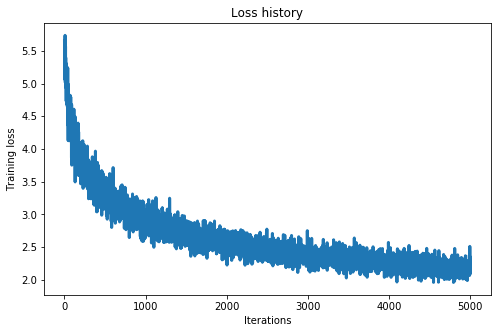

In [11]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
lr = 1e-7
reg = 100

classifier = LinearClassifier(hinge_forward_backward)
# #
# # TODO : ajouter code à la fonction train.  Si tout fonctionne bien, la courbe de la loss devrait décroitre
# #
train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=5000, verbose = True)

y_train_pred = classifier.predict(X_train)
y_val_pred = classifier.predict(X_val)

acc_train = np.mean(y_train == y_train_pred)
acc_val = np.mean(y_val == y_val_pred)

print('train vs val acc %f / %f' %(acc_train, acc_val))

visualize_loss(train_loss_history)

## Recherche d'hyper-paramètres

loss :  5.665189280111395
loss :  5.626020528276108
loss :  6.414324948470059
loss :  5.9860972413299525
loss :  5.840302861138614
loss :  5.626040126981382
loss :  6.017752436740804
loss :  6.083874986020535
loss :  5.898607630361055
loss :  5.607169585494712
loss :  5.738994880014989
loss :  6.496219039435878
loss :  6.244014845907258
loss :  6.042147102728807
loss :  6.1050245619417725
loss :  6.18642616114978
loss :  5.845368361412291
loss :  6.057482912961314
loss :  6.034140649649484
loss :  6.076385007100666
loss :  6.040956963450291
loss :  6.030455911950785
loss :  6.223002388271624
loss :  6.0468404885058025
loss :  6.595525371262292
loss :  5.867522054667342
loss :  6.086791885245539
loss :  6.05629430250855
loss :  5.4197236962568915
loss :  6.388665497764561
loss :  5.92560054100079
loss :  6.048006398706068
loss :  6.040638850478342
loss :  6.235292044703721
loss :  5.620779346705299
loss :  6.048444174365845
loss :  6.212333773191948
loss :  6.133500903488578
loss :  6.0

loss :  4.977425161616707
loss :  5.450802827083485
loss :  4.998779271335072
loss :  5.032299303216095
loss :  5.318639624289605
loss :  5.101713916938078
loss :  5.776646396666031
loss :  5.114029998910233
loss :  5.213694859701981
loss :  4.753077585623482
loss :  5.429444803148007
loss :  5.406756719936157
loss :  5.0457393274346725
loss :  4.603797218721377
loss :  5.417586333852505
loss :  5.0548785775299505
loss :  5.330714088700392
loss :  4.865036251955779
loss :  5.411591156337478
loss :  5.237149186728068
loss :  5.109427267581624
loss :  5.148217523562323
loss :  4.973601918455809
loss :  5.065180473009148
loss :  5.236087188573063
loss :  4.634786885900842
loss :  5.058543762327384
loss :  5.626310688695413
loss :  5.327533320239837
loss :  5.129566677214016
loss :  4.952304705076251
loss :  5.468990815353729
loss :  5.120001314132406
loss :  5.013683150635765
loss :  5.217677868935389
loss :  4.783187428414799
loss :  5.249670759758529
loss :  5.002199535636565
loss :  5.

loss :  4.66057258419655
loss :  4.739649417130785
loss :  4.811772259051937
loss :  4.364769629739684
loss :  5.309349809084193
loss :  4.6219276122760995
loss :  4.834391612633349
loss :  5.000588663153245
loss :  5.029931541760566
loss :  5.021046818654965
loss :  4.9018912554002
loss :  4.47135878793203
loss :  4.337271233029629
loss :  4.827916543184426
loss :  4.36609105188047
loss :  4.279078361724786
loss :  4.6531979036425115
loss :  4.8983932395186445
loss :  4.516795513661692
loss :  4.6859407669589
loss :  4.550599616955627
loss :  4.691382315790016
loss :  4.413184959488712
loss :  4.727785852138196
loss :  4.448611786322665
loss :  4.596202422001431
loss :  4.56005153442786
loss :  4.7781241914937524
loss :  4.889976750596986
loss :  4.463767157127105
loss :  4.52001483780638
loss :  4.773910093677081
loss :  4.805777378591451
loss :  4.711889795058991
loss :  4.5772416608109765
loss :  4.808041861818581
loss :  4.727499052038513
loss :  4.890653238590684
loss :  4.299281

loss :  4.482665527989982
loss :  4.381454040438885
loss :  4.17540719150201
loss :  4.126017940731636
loss :  4.400286661762583
loss :  4.498533040689004
loss :  4.327733559345342
loss :  4.3850196976231395
loss :  4.568114856854362
loss :  4.2092972001235704
loss :  4.2783934202053695
loss :  4.2685043195266665
loss :  4.353435341482304
loss :  4.348085916952695
loss :  4.23800953391753
loss :  4.591021960984425
loss :  4.613245118647803
loss :  4.418091540192726
loss :  4.101895959852501
loss :  4.511517515897494
loss :  4.106005637607661
loss :  4.2215582954584745
loss :  4.4838541409149375
loss :  4.110954596662218
loss :  4.224693272757167
loss :  4.475336838812399
loss :  4.159833419931784
loss :  4.195222331735482
loss :  4.479058602746944
loss :  4.48988233756436
loss :  4.297221292555616
loss :  4.219647145568977
loss :  4.744377694362166
loss :  4.31861617582449
loss :  4.573623084377062
loss :  4.523812267816545
loss :  4.503450717601517
loss :  3.936191656632577
loss :  4.

loss :  4.02974491544862
loss :  4.057945165754539
loss :  4.420952912982495
loss :  4.132425189773151
loss :  4.211974484231188
loss :  4.293799569830656
loss :  3.712473741326446
loss :  4.262040291610898
loss :  4.364606826961933
loss :  4.167231187731801
loss :  4.233106913031703
loss :  4.3027092656941015
loss :  4.122282681852019
loss :  4.011318395976519
loss :  4.110739058714338
loss :  4.2414926813406755
loss :  3.932551766177613
loss :  4.214709177148121
loss :  4.441402196512877
loss :  4.317481022064795
loss :  4.107215308856819
loss :  3.998456767987236
loss :  4.130000195923332
loss :  4.061335509425486
loss :  4.215699111589928
loss :  4.2574940725266845
loss :  4.127650995595672
loss :  4.018987662968727
loss :  4.349264439500445
loss :  4.081913807192977
loss :  4.070991786613458
loss :  4.07685046723423
loss :  4.2499923620572675
loss :  3.8089561847574145
loss :  4.010606901317698
loss :  4.409365182800399
loss :  4.313195329284598
loss :  4.110012732500105
loss :  4

loss :  3.9855285906236175
loss :  3.997763184081849
loss :  4.0141384751886955
loss :  4.263407890781723
loss :  4.250104277716532
loss :  3.9314878466485528
loss :  4.18020681340816
loss :  4.184752955885909
loss :  3.9177593173927345
loss :  4.231065783477398
loss :  4.143687059631938
loss :  4.063711463763017
loss :  3.8241859640279383
loss :  4.040313543753528
loss :  4.183393471133656
loss :  3.7435933484991026
loss :  4.0305595001486605
loss :  4.357424296358641
loss :  3.6008092787161754
loss :  4.106921036595256
loss :  4.300385623202439
loss :  4.0888383707535105
loss :  4.2336886342770494
loss :  4.088798978310066
loss :  4.052033852387669
loss :  4.475794884721579
loss :  4.081631223013002
loss :  4.157552266681716
loss :  3.8653829391266017
loss :  4.099229672031312
loss :  3.9110561590695805
loss :  4.3667568317488366
loss :  4.294660332921741
loss :  4.172341074324157
loss :  4.1210707683323715
loss :  4.358598968221442
loss :  4.297310462885289
loss :  4.019858398986177

loss :  4.120671052000886
loss :  4.162547873697176
loss :  4.060371543069068
loss :  4.132478000259178
loss :  4.137784397784866
loss :  3.9016736919527837
loss :  3.99093935081302
loss :  4.095943567139269
loss :  4.146286694646892
loss :  4.368742585840822
loss :  4.144107630773645
loss :  3.9201421653119994
loss :  3.841532819828868
loss :  3.9623839049330307
loss :  3.6830712716548377
loss :  3.7521798771885035
loss :  3.9376159563783086
loss :  3.868948457913851
loss :  3.8800360890465497
loss :  3.9584750122680044
loss :  3.630835094476089
loss :  3.8638204089681256
loss :  4.009962815382348
loss :  4.098429940928681
loss :  4.1837094836731445
loss :  3.888581937235928
loss :  3.913433524486562
loss :  3.964118604700581
loss :  3.6141028761141594
loss :  3.6289731500481186
loss :  4.102063509708691
loss :  4.017840313911638
loss :  4.180412447458999
loss :  3.969742644398681
loss :  3.8639633767617663
loss :  3.962060796191578
loss :  3.753808021021257
loss :  3.772197498723455


loss :  3.922950319089793
loss :  3.6185995262373
loss :  4.0489061755450555
loss :  3.6396380739086545
loss :  3.9952081509701567
loss :  4.023293201265925
loss :  3.701994759198708
loss :  4.006848042589016
loss :  3.559360208278749
loss :  3.8566357790246637
loss :  3.6666066796849033
loss :  3.9249049104859326
loss :  4.008367446802334
loss :  3.8066264452198335
loss :  3.8993334068893115
loss :  3.6790426148054163
loss :  3.585062068092085
loss :  3.770196815675947
loss :  3.5580573381348786
loss :  3.643252305595538
loss :  3.600135521293747
loss :  4.345207944207675
loss :  3.6597838990040583
loss :  3.651163405738753
loss :  3.922324269218874
loss :  3.8674738060933236
loss :  3.8247380872998975
loss :  3.866716395635003
loss :  3.9646060522164466
loss :  3.830886693497596
loss :  3.8836098966381196
loss :  3.737952028557385
loss :  4.0264947339644825
loss :  3.8143116781129636
loss :  4.035698823156583
loss :  4.310386055733107
loss :  3.6148340338449083
loss :  3.979984165043

loss :  4.069250851242457
loss :  3.8599593171954467
loss :  3.8968293526677837
loss :  4.048570260572157
loss :  3.6290097123675453
loss :  4.120478343153637
loss :  3.660316526578013
loss :  3.7115531072871035
loss :  3.890111026318112
loss :  3.6771302664494874
loss :  4.009188490941105
loss :  3.885193865802263
loss :  3.7625672750164347
loss :  3.888452929301609
loss :  4.050003202969122
loss :  3.9770247093772975
loss :  3.7693179969936925
loss :  4.078105206684285
loss :  4.059076991799668
loss :  3.787268867272063
loss :  3.6883281152354765
loss :  3.8082543338534367
loss :  3.899156431287021
loss :  3.9502546168051293
loss :  3.6583066402579925
loss :  4.107939911370129
loss :  3.810653269092006
loss :  3.872500015085513
loss :  3.850379176879647
loss :  3.760554525920573
loss :  3.756834257913619
loss :  3.878666728852428
loss :  3.645746022736974
loss :  3.7431104890095797
loss :  3.8494740180749236
loss :  3.4723114008372034
loss :  3.6191448456579334
loss :  4.011611375555

loss :  3.482510900299393
loss :  3.8373564628540833
loss :  3.7186142615716253
loss :  3.775006978838108
loss :  3.6994445308743082
loss :  3.8840609492586817
loss :  3.7966074538835675
loss :  3.5783446585616496
loss :  3.5957527844010677
loss :  3.7936272216468243
loss :  4.145534967916538
loss :  3.4698271187802963
loss :  3.716778534956345
loss :  4.1179697330530765
loss :  3.6238930555024624
loss :  3.8640039299157865
loss :  3.596718120785842
loss :  3.922036210348299
loss :  3.93316842193557
loss :  3.5583758175009614
loss :  3.833108811184794
loss :  3.8754865141970187
loss :  3.8539785309929253
loss :  3.589901097001926
loss :  4.002155025944953
loss :  3.7238262880714887
loss :  3.8399597597937394
loss :  3.5507315739988576
loss :  3.434398212407889
loss :  3.6936543339830825
loss :  3.4920938357448135
loss :  3.7267132931993427
loss :  3.7983399601920045
loss :  3.4948615028117356
loss :  3.558913925052083
loss :  3.510754046266702
loss :  3.527524985108928
loss :  3.765439

loss :  6.397211152834846
loss :  6.592570049482359
loss :  5.763499904801387
loss :  6.376496313214869
loss :  5.583477867224026
loss :  5.812533935385899
loss :  6.177627418600619
loss :  6.312952953251658
loss :  6.193992985260035
loss :  6.0280625976274065
loss :  5.919784507625353
loss :  6.190493751346524
loss :  6.170274692167128
loss :  5.926755637445433
loss :  6.200274703649127
loss :  5.80931071675969
loss :  5.850445528751825
loss :  5.929235916223499
loss :  5.918409396339075
loss :  6.39450639981721
loss :  5.824549899655048
loss :  5.667796982721038
loss :  6.173931448322484
loss :  6.108356871446002
loss :  6.222172331397592
loss :  6.44608686959279
loss :  6.142863924778026
loss :  6.129573596008152
loss :  6.154469462715671
loss :  5.735012521418883
loss :  6.312399023728748
loss :  6.415252306031602
loss :  6.140914324720089
loss :  5.877926444687096
loss :  6.381761453785611
loss :  5.808317443307204
loss :  6.212350375903543
loss :  6.419662731324482
loss :  6.0767

loss :  5.350760135173483
loss :  5.289495255898805
loss :  5.353731881804329
loss :  5.5631679730270855
loss :  4.826811875555542
loss :  5.399535079531902
loss :  5.730982733095829
loss :  5.744505168880783
loss :  5.244780716963479
loss :  5.616806966068632
loss :  5.151786605665604
loss :  5.166232617868538
loss :  5.777760843944528
loss :  5.2204662568461
loss :  5.339941385251027
loss :  5.283447474547257
loss :  5.189589823719862
loss :  5.120103090740357
loss :  5.3728876676230195
loss :  5.576204809769329
loss :  5.511722007818671
loss :  5.145976887615675
loss :  5.451293708638893
loss :  5.343612266993548
loss :  5.370398563046856
loss :  5.4473638860755
loss :  5.50206403171751
loss :  5.458749879731417
loss :  5.065406313623888
loss :  5.236907144401885
loss :  5.2013169502202325
loss :  5.509735982669425
loss :  5.176019358963924
loss :  5.818051415827931
loss :  4.8596029193494
loss :  5.4114472241484055
loss :  5.502372750901539
loss :  5.241295431189262
loss :  5.11633

loss :  4.452483143708698
loss :  4.319729682945835
loss :  4.447841050290209
loss :  4.501095557506486
loss :  4.776451629689611
loss :  4.415453845328574
loss :  4.371067609791058
loss :  4.713523017302621
loss :  4.344068707805717
loss :  4.786011380124532
loss :  4.487907702828541
loss :  4.775608757964699
loss :  4.7195263743737295
loss :  4.256488587526699
loss :  4.9418052445514835
loss :  4.132310986854335
loss :  4.731600426003382
loss :  4.564429908886589
loss :  4.906636754774005
loss :  4.741228665090891
loss :  4.583600118729333
loss :  4.747745250243603
loss :  4.705736252205771
loss :  4.775081256073526
loss :  4.637298352255715
loss :  4.522933636690075
loss :  4.86426924661177
loss :  4.539677519368195
loss :  4.5141085431508134
loss :  4.474963989090937
loss :  5.07750609197036
loss :  4.665478171744106
loss :  4.534014289417642
loss :  4.3961271970854225
loss :  4.529839084877715
loss :  4.483182634537465
loss :  4.5496505016641695
loss :  4.557767033214633
loss :  4

loss :  4.625001893638082
loss :  4.464923075329185
loss :  4.444262735386179
loss :  4.182703260487276
loss :  4.398112925946617
loss :  4.191261420350499
loss :  4.377958970162106
loss :  4.360986908400852
loss :  3.8740426040808016
loss :  3.993358496921303
loss :  4.48407199341679
loss :  4.254951940825955
loss :  4.400223254406809
loss :  4.10513651263466
loss :  4.265766764714031
loss :  4.467444487945499
loss :  4.381890048741881
loss :  4.314683302641175
loss :  4.287610869784325
loss :  3.9742468895265723
loss :  4.355706488204434
loss :  4.115059727814281
loss :  4.133927116150327
loss :  4.472000803653301
loss :  3.9304954177367812
loss :  4.294411203633657
loss :  4.2617868343772445
loss :  4.34579493941902
loss :  4.422264443056392
loss :  3.854952818732024
loss :  4.294103403992194
loss :  4.110445958283317
loss :  4.333479197588141
loss :  4.364441822524139
loss :  4.273002585050297
loss :  4.363036122267473
loss :  3.982654448325169
loss :  5.194365230397282
loss :  4.0

loss :  4.339046571743244
loss :  4.099284028506737
loss :  4.119286101685299
loss :  4.020333654584001
loss :  4.029337594625573
loss :  4.3621489254587615
loss :  4.009956413492259
loss :  4.394034314465436
loss :  4.104420640146863
loss :  4.001425835276633
loss :  4.259079931600463
loss :  3.991269612161235
loss :  4.188994760552491
loss :  4.149441219892868
loss :  3.9700971745606695
loss :  4.0084349428649695
loss :  4.136606800196722
loss :  3.927737448262352
loss :  4.022252833830334
loss :  4.11610371450839
loss :  4.438870169080369
loss :  4.115314424608963
loss :  4.5507626051747225
loss :  4.367028220805331
loss :  4.150060617277057
loss :  4.0789578410730005
loss :  4.207067810844714
loss :  4.163479698121265
loss :  3.9670964836881666
loss :  4.326141987444479
loss :  4.134261479521333
loss :  4.0494409893892875
loss :  4.5471201195221
loss :  4.052000780139583
loss :  4.509986898898324
loss :  3.9684055798691418
loss :  3.9374392342920976
loss :  4.130839289702983
loss :

loss :  4.054901942543837
loss :  3.90116726217491
loss :  3.9890990714631904
loss :  4.03873069514091
loss :  3.9194042772602726
loss :  3.8872199472306463
loss :  3.9317905926111405
loss :  4.06182123498426
loss :  4.02940925254781
loss :  4.02150100500809
loss :  3.8695054865201586
loss :  4.016908738108467
loss :  3.9475544098536135
loss :  4.199504723550978
loss :  4.035212005364943
loss :  3.915175445189804
loss :  3.753759790824722
loss :  3.917148932091761
loss :  3.8261241862164614
loss :  4.1977552859858305
loss :  4.1761455258744125
loss :  3.922396433469512
loss :  3.9836327316478215
loss :  3.8969713659010345
loss :  3.7846992949492617
loss :  4.184950775895279
loss :  4.304420419977194
loss :  3.9836582196817028
loss :  3.8605827073651118
loss :  4.393324741295194
loss :  3.970840014380254
loss :  4.101625915807981
loss :  4.6060473580857035
loss :  3.60300588512657
loss :  4.093262488105248
loss :  4.390194161189772
loss :  4.237812059426378
loss :  4.2762682725056305
lo

loss :  3.9266409110812264
loss :  3.89396938113873
loss :  3.9917864094025255
loss :  4.253215128121747
loss :  4.124657388284377
loss :  3.746361616058689
loss :  3.692770835276934
loss :  3.860453732594859
loss :  3.955264151370461
loss :  3.8319007407151786
loss :  4.169737375664379
loss :  4.3306570886213605
loss :  4.048534858494403
loss :  3.890832632462635
loss :  3.8086879500668887
loss :  4.070025569206376
loss :  3.9681601538938422
loss :  3.7964899037155537
loss :  4.120935405832662
loss :  3.955772016216328
loss :  4.033557403969045
loss :  3.8838560256973635
loss :  3.9660280235760887
loss :  4.127702567935411
loss :  3.769639275818562
loss :  3.864966416182199
loss :  4.050209863984653
loss :  4.239558161457056
loss :  3.8661909111388435
loss :  3.922980855681627
loss :  4.04145641101528
loss :  4.122286124131499
loss :  3.769876300748074
loss :  4.175724251991518
loss :  3.93381182324055
loss :  4.019229042775475
loss :  3.7094354882199934
loss :  3.9305073987326553
los

loss :  3.6612581201807304
loss :  3.5810458142585304
loss :  4.034754644311425
loss :  4.011703968262371
loss :  3.56443493077521
loss :  3.783912473616235
loss :  3.804270109817533
loss :  3.783666014769044
loss :  3.769296933895407
loss :  3.4728476943187503
loss :  4.010750847702626
loss :  3.807167905202728
loss :  3.85140077397873
loss :  3.568225454219785
loss :  3.9239044496740303
loss :  4.379432779835173
loss :  3.9298141757952902
loss :  3.6567219746820645
loss :  3.7508258215578087
loss :  3.9546160023627692
loss :  3.585759898505338
loss :  3.560070234134025
loss :  3.611757219940699
loss :  3.8675208378455217
loss :  4.087018668531391
loss :  3.6951188661636163
loss :  3.8176872884007373
loss :  3.6981187514166165
loss :  3.614151015213819
loss :  3.8255348204927926
loss :  3.9185402933757167
loss :  4.028111810034468
loss :  3.8319349576989032
loss :  4.128787386511879
loss :  3.8430898517936622
loss :  3.739232168872105
loss :  3.9694838279448583
loss :  3.8834165382406

loss :  5.671070893505489
loss :  5.626095842439092
loss :  5.629841591302486
loss :  5.4227987997152685
loss :  5.9745114465339375
loss :  6.042932993353418
loss :  5.401189499836182
loss :  5.934919477688019
loss :  5.511539862923315
loss :  5.698976613055795
loss :  5.5636111879655985
loss :  5.802121536572547
loss :  5.677448057889133
loss :  5.6546921835296216
loss :  5.4923202014835555
loss :  5.70049850623706
loss :  5.969001646285102
loss :  5.526899965352902
loss :  5.600522890138714
loss :  5.5206660304977175
loss :  5.375456164387017
loss :  5.113552841561353
loss :  5.244190519733761
loss :  5.693269746760817
loss :  5.451521799861482
loss :  5.727562071691298
loss :  5.991630443111306
loss :  5.922015800790627
loss :  5.5797084379029025
loss :  5.338823935034616
loss :  6.164556376732735
loss :  6.019355072985303
loss :  5.39604809463855
loss :  5.523208348715232
loss :  5.668124016545886
loss :  5.243987756971279
loss :  5.350161879778192
loss :  5.728313962903798
loss : 

loss :  5.14502401566084
loss :  4.970299439691211
loss :  4.656089905893296
loss :  4.81287670520247
loss :  5.008624201213873
loss :  4.638439375799939
loss :  5.004026996495441
loss :  4.606603058272612
loss :  5.0124681766722805
loss :  4.58412247454908
loss :  5.2942915663551755
loss :  5.132971383245916
loss :  4.836235755338531
loss :  4.689354013115735
loss :  5.381936539730098
loss :  4.813622563410869
loss :  4.926439747224483
loss :  4.987539508174381
loss :  4.8892880734129305
loss :  5.233201830092699
loss :  4.998761268982419
loss :  5.105347779436537
loss :  5.274059954462124
loss :  5.246779208763042
loss :  5.040459087396792
loss :  5.012850389555639
loss :  4.87810920192378
loss :  5.032351646678713
loss :  5.141517586921363
loss :  4.638771914061196
loss :  4.836948152315598
loss :  5.27800456097528
loss :  4.949723923550814
loss :  4.794107494369984
loss :  5.008330256923449
loss :  4.527587671528409
loss :  5.283870127744435
loss :  5.16492360877736
loss :  5.14372

loss :  4.955447288355328
loss :  4.4922653893123
loss :  4.423967837696112
loss :  4.394654126570891
loss :  4.23645364357381
loss :  4.797113850829578
loss :  4.733997133080878
loss :  4.456511360918095
loss :  4.670508812074171
loss :  4.912273724944859
loss :  4.259043688036128
loss :  4.733857668877536
loss :  4.584182401703237
loss :  4.42150049403378
loss :  4.52944037167355
loss :  4.626319733528051
loss :  4.46707940730951
loss :  4.431904727447754
loss :  4.68699320448846
loss :  4.4648675908752065
loss :  4.4632558637297866
loss :  4.851504062038492
loss :  4.6538559941641715
loss :  4.521735366286965
loss :  4.6947508583011555
loss :  4.554548454756488
loss :  4.34879714642307
loss :  4.693300501010895
loss :  4.047326552331084
loss :  4.699769801272158
loss :  4.554188036143114
loss :  4.782062166622517
loss :  4.596031063231209
loss :  4.462819494661972
loss :  4.674516687182896
loss :  4.421762354848445
loss :  4.226878619933256
loss :  4.475334939203765
loss :  4.559572

loss :  4.420373708997198
loss :  4.36959515970493
loss :  4.243610920140584
loss :  4.179060994919614
loss :  4.388286474359231
loss :  4.206788024378896
loss :  4.25270874020452
loss :  4.32415308001497
loss :  4.221109617862632
loss :  4.39663753201274
loss :  4.364333814909288
loss :  3.9938871790952772
loss :  4.654230312599554
loss :  4.057986263740588
loss :  4.101256944159183
loss :  4.38755554870866
loss :  4.20741617855738
loss :  4.426035104916386
loss :  4.4534361583814155
loss :  4.1892618210045525
loss :  4.143489071178794
loss :  4.344135969233117
loss :  4.078648411280825
loss :  4.4851839292190485
loss :  4.592482366523825
loss :  4.527041268615894
loss :  4.316083677189247
loss :  4.324497137679599
loss :  4.555499657468403
loss :  3.9031168364632514
loss :  4.3745012022683865
loss :  4.561612336537241
loss :  4.6662035055901665
loss :  4.405306444066354
loss :  4.427577980182272
loss :  4.339101623631692
loss :  4.1770174072425
loss :  4.355654481204647
loss :  4.432

loss :  4.222054505007768
loss :  4.012421501153469
loss :  3.9315886298153453
loss :  4.397806451845748
loss :  4.230028925707761
loss :  4.24050242104672
loss :  4.1288586110525
loss :  4.4333382712173695
loss :  4.241761679233015
loss :  4.297794953900301
loss :  4.629952197280253
loss :  4.357139950432972
loss :  4.31696658193494
loss :  3.934419069968414
loss :  3.8689285141106007
loss :  4.402800177616716
loss :  3.999940974786873
loss :  4.2090384848910585
loss :  4.14656026786393
loss :  4.15804678626504
loss :  4.431569558800524
loss :  4.228171450318547
loss :  4.2830579023901425
loss :  4.311717001488439
loss :  4.20294750215044
loss :  4.110984111433687
loss :  4.18331845746046
loss :  3.647607491045385
loss :  4.4222863971779205
loss :  3.9313467824272936
loss :  4.380393152253387
loss :  3.946981257064881
loss :  4.018359082915198
loss :  4.4059397775518105
loss :  4.5833702800701905
loss :  3.9807067528942985
loss :  4.413738427475299
loss :  4.48497818500664
loss :  4.2

loss :  4.341971901306468
loss :  4.01773187602146
loss :  3.989827862279842
loss :  4.4376429469956
loss :  4.312854798294262
loss :  3.958367245742754
loss :  4.209895116064445
loss :  4.3972818194752845
loss :  3.9366899761585876
loss :  4.205203321523275
loss :  4.08664314708633
loss :  3.943388330426968
loss :  3.97255241857417
loss :  4.364873856000024
loss :  3.972644897657623
loss :  3.9250176559059162
loss :  4.102271790837854
loss :  3.8910162996365303
loss :  4.002104928601801
loss :  3.863448605427536
loss :  4.141242606993775
loss :  4.0249265952576705
loss :  4.107828667614741
loss :  3.8632973214895743
loss :  4.221208291853192
loss :  3.939194192667769
loss :  4.386598571873702
loss :  3.896284427814428
loss :  3.8907224364329434
loss :  4.046939585038311
loss :  4.011583923618107
loss :  4.101065476721874
loss :  4.085661345018035
loss :  4.0687404219740735
loss :  4.458071611356043
loss :  3.8465978370710023
loss :  3.9894077778868944
loss :  4.189098939120265
loss : 

loss :  3.812043633184792
loss :  4.083565523561359
loss :  4.000239060030918
loss :  3.7061527428860437
loss :  3.6540891704831653
loss :  4.021221126749687
loss :  3.8348026428824142
loss :  3.747918801981383
loss :  4.025628315139202
loss :  4.097866718571672
loss :  3.8714309139222394
loss :  4.0511038012391385
loss :  3.55685032909739
loss :  3.9200066946340257
loss :  4.2272311175782695
loss :  3.85087185957436
loss :  4.150648107556832
loss :  3.85863264660753
loss :  3.9331255455707828
loss :  3.727698919013077
loss :  4.16199865504568
loss :  4.067697136745295
loss :  4.165969701320771
loss :  3.9278355795146482
loss :  4.063780829895997
loss :  4.23562118204176
loss :  3.5997494032226545
loss :  3.817976022833584
loss :  3.9528165882550867
loss :  4.1193305122803405
loss :  4.1674441661203625
loss :  4.024396050395072
loss :  3.596286252336763
loss :  4.015582125623226
loss :  3.693169039444641
loss :  3.870097331765817
loss :  3.8978104395209625
loss :  3.9094031510327
loss 

loss :  4.053372086663238
loss :  3.821824583463467
loss :  3.778633674216195
loss :  3.534906725457446
loss :  3.808583040280347
loss :  3.803486424916893
loss :  3.690834709440277
loss :  4.046265159950261
loss :  3.6951817157294813
loss :  3.8719381303332865
loss :  3.798691527532341
loss :  4.011712452032001
loss :  4.0727140996644975
loss :  4.167187240160534
loss :  4.177622607509841
loss :  3.528574648478167
loss :  4.277220674982225
loss :  4.374964177633498
loss :  3.7464603059465413
loss :  3.3920065972658824
loss :  3.6142608458381993
loss :  3.696077116197308
loss :  3.7633494125361335
loss :  3.9470285499127495
loss :  3.690209921143014
loss :  3.938442313934761
loss :  3.717740447899723
loss :  3.8168086778093766
loss :  3.9697991361763356
loss :  3.606702813516598
loss :  3.7646564456433396
loss :  4.108246510098879
loss :  4.012620490778674
loss :  4.16945116539933
loss :  3.9664610354966134
loss :  3.793645107841446
loss :  3.774845397760925
loss :  3.9078250693241876


loss :  3.6334933877776425
loss :  3.651632113121953
loss :  3.7760854107633257
loss :  3.4307880711473047
loss :  3.7957079302698777
loss :  3.5993696972937546
loss :  3.7964014460557105
loss :  3.5576606597646627
loss :  3.6605365386753954
loss :  3.5556228477574057
loss :  3.4224609343747465
loss :  3.9898395918404983
loss :  3.708122637983102
loss :  3.553187126660058
loss :  3.6243374784603066
loss :  3.857204173678883
loss :  3.538190299621623
loss :  3.6537640345931988
loss :  3.781983795741062
loss :  3.664431934073397
loss :  3.7724627549836587
loss :  3.546642725704395
loss :  3.6456188229070348
loss :  3.8255239133637167
loss :  3.6191000655192194
loss :  3.83186953798331
loss :  3.7187800158118343
loss :  3.875578104846835
loss :  3.743827597911815
loss :  3.6000019926995956
loss :  3.3788533039492927
loss :  3.6821696077662747
loss :  3.526528793946731
loss :  3.501297240079288
loss :  3.716586464646663
loss :  3.6613521244294973
loss :  3.496961332204247
loss :  3.7477158

loss :  3.1176516567413874
loss :  3.2409995535067795
loss :  3.433846576679455
loss :  3.2274887026879155
loss :  3.4695203712525493
loss :  3.27647306401866
loss :  3.25334314328958
loss :  3.091433494133544
loss :  3.206786214123339
loss :  3.409407914214599
loss :  3.2693227737011497
loss :  3.1587870980624255
loss :  3.3580230380634886
loss :  3.1810694734886606
loss :  3.402090574954309
loss :  3.1552546059548274
loss :  3.1237947368839425
loss :  3.1309716344154195
loss :  3.2917691251291616
loss :  3.2598428987746884
loss :  3.2853547215491417
loss :  3.143093868025259
loss :  3.0957972734381576
loss :  3.283197206860625
loss :  3.3306182174385945
loss :  3.3838933109229448
loss :  3.5078308758615173
loss :  3.0520392661450875
loss :  3.0407582797296158
loss :  3.138704535425666
loss :  3.2466665613493806
loss :  3.1874485449924372
loss :  3.1504089515594007
loss :  3.4456303078086217
loss :  3.2341292325498294
loss :  3.1944364832426952
loss :  3.161146418294884
loss :  3.5795

loss :  2.957547661643308
loss :  2.725596216899931
loss :  3.0338426958418214
loss :  2.754309126468759
loss :  2.7726083620109048
loss :  2.854996555457396
loss :  3.209467342154988
loss :  2.8714289234654946
loss :  2.9125328691959544
loss :  2.754303897239379
loss :  2.715690665787108
loss :  2.8512229830181206
loss :  2.5062399691537247
loss :  2.5930982585395417
loss :  2.5704828193897895
loss :  2.903845934203888
loss :  2.751821491466154
loss :  2.785592289100368
loss :  3.066976582400745
loss :  2.7051732254649905
loss :  3.1441495824738785
loss :  2.656943100317185
loss :  2.8628675562575934
loss :  2.901716279903023
loss :  2.80383967502428
loss :  2.852248840220717
loss :  2.771278230270903
loss :  2.6715506440187227
loss :  2.6187971732136917
loss :  2.7274445661113664
loss :  2.8022392275744905
loss :  2.8028220088322793
loss :  2.6811244001047188
loss :  2.8194079343957785
loss :  2.660963448021896
loss :  2.6322300535289282
loss :  2.8175321813679077
loss :  2.845719024

loss :  2.5655874499914058
loss :  2.641732004536741
loss :  2.5403894182879805
loss :  2.600116718410596
loss :  2.476540526750561
loss :  2.5373817951480557
loss :  2.6740527265248506
loss :  2.5652279488433205
loss :  2.483521338069849
loss :  2.4969905887513977
loss :  2.4892817315492306
loss :  2.4989064109966956
loss :  2.4609883296057955
loss :  2.477002919031357
loss :  2.5106689501997073
loss :  2.6750981837493977
loss :  2.5134109483463583
loss :  2.6463599470897763
loss :  2.5754212156349614
loss :  2.6014896620946435
loss :  2.6671222590434254
loss :  2.438326509663931
loss :  2.7470291095665775
loss :  2.5579564861524435
loss :  2.573351449308561
loss :  2.766787704689282
loss :  2.5755121810743815
loss :  2.4383410626669555
loss :  2.805898165897214
loss :  2.6509879763831656
loss :  2.737506116085479
loss :  2.5125760126187613
loss :  2.7528088507916157
loss :  2.629652472500809
loss :  2.454104339375629
loss :  2.431001001229154
loss :  2.5920524631799093
loss :  2.5805

loss :  2.5909426758835195
loss :  2.321694354405354
loss :  2.1702409421603472
loss :  2.395445657767205
loss :  2.34090141599321
loss :  2.6036977615842027
loss :  2.4102302770463466
loss :  2.4574728554945406
loss :  2.3335418574052564
loss :  2.365956081675408
loss :  2.4195517532101394
loss :  2.4277374453956813
loss :  2.4688012916951574
loss :  2.6142141385515196
loss :  2.451643151344401
loss :  2.256123299998552
loss :  2.5461844776130964
loss :  2.4076322281828975
loss :  2.401587747602021
loss :  2.5172745350051717
loss :  2.337403375999876
loss :  2.4874339792961226
loss :  2.465996515680487
loss :  2.575169519725527
loss :  2.4451968039065206
loss :  2.549085742237816
loss :  2.359386012913477
loss :  2.358530184731441
loss :  2.43196876685813
loss :  2.5690549036501147
loss :  2.720686854542439
loss :  2.3993718776861868
loss :  2.381934217507853
loss :  2.371834381572403
loss :  2.3563694132537365
loss :  2.3976913875583117
loss :  2.4346292837919146
loss :  2.2410532740

loss :  2.2385777595699095
loss :  2.210287314950347
loss :  2.1212293077791515
loss :  2.4250734682628687
loss :  2.3475949077386007
loss :  2.4212813596251417
loss :  2.3683219986866417
loss :  2.291496197094528
loss :  2.23337571846921
loss :  2.3183988964249824
loss :  2.2581968495128786
loss :  2.271928534737356
loss :  2.087336450257211
loss :  2.323440915501717
loss :  2.218287422016884
loss :  2.317150940323817
loss :  2.389831231647558
loss :  2.501166151978667
loss :  2.4766160381852043
loss :  2.1864862821680906
loss :  2.36051541435512
loss :  2.430132413977322
loss :  2.225675605258665
loss :  2.1733090320934103
loss :  2.318951320232752
loss :  2.335133479025748
loss :  2.340816638133313
loss :  2.3544673197067088
loss :  2.3769153871377515
loss :  2.2740366861056214
loss :  2.308885173022885
loss :  2.2080125434659656
loss :  2.099320930452925
loss :  2.401220570601026
loss :  2.3037881136205014
loss :  2.411053896950355
loss :  2.3433603686688524
loss :  2.3802938002108

loss :  2.1893938851758703
loss :  2.284401790257875
loss :  2.157999105618269
loss :  2.0968426597551546
loss :  2.0889300925303007
loss :  2.096587149056357
loss :  2.200488345351997
loss :  2.292626922758528
loss :  2.26514134104462
loss :  2.2041737172354043
loss :  2.2092323654829458
loss :  2.1649355583230063
loss :  2.3200432256787518
loss :  2.234389210774129
loss :  2.1345434853544036
loss :  2.0872759558371827
loss :  2.183046693991932
loss :  2.2711176382178526
loss :  2.2211491258059963
loss :  2.2874297315592975
loss :  2.207282274793562
loss :  2.0979995707625627
loss :  2.3694091387790457
loss :  2.199632673706298
loss :  2.1915581753811337
loss :  2.2567568851636235
loss :  2.0385579224451793
loss :  2.3286701236147276
loss :  2.1900228187620128
loss :  2.2901522589674603
loss :  2.2319563738261627
loss :  2.3269856008113403
loss :  2.0377961341530013
loss :  2.1778884318933645
loss :  2.3097623421057984
loss :  2.0940038540791437
loss :  2.300306788581935
loss :  2.166

loss :  2.0292486036594317
loss :  2.2791804395202093
loss :  2.2445050236883284
loss :  2.2658815935269114
loss :  2.1361454457550177
loss :  2.1926621620897033
loss :  2.155656529896352
loss :  2.3838439611030418
loss :  2.0733933770735753
loss :  2.1153327725296602
loss :  2.2283941289509004
loss :  2.128912677917385
loss :  2.1261874257007003
loss :  2.086076348995265
loss :  2.1621780788249043
loss :  2.031220967891355
loss :  2.248749934852915
loss :  2.066161136801394
loss :  2.1624248561499746
loss :  2.1509843320066744
loss :  2.225465068477182
loss :  2.2556331176353033
loss :  2.259934110618742
loss :  2.076582258841352
loss :  1.9915560132506633
loss :  2.074076668504319
loss :  2.140439676916601
loss :  2.2554099107911396
loss :  2.142006814293511
loss :  2.0913385541919434
loss :  2.0712133192921143
loss :  2.033289169162103
loss :  2.2733051471033887
loss :  2.082514495466066
loss :  2.243168206774697
loss :  2.139926392604209
loss :  2.304651575667593
loss :  2.13325921

loss :  2.168454126854994
loss :  2.0261536238296514
loss :  2.054981259356132
loss :  2.268217900077785
loss :  2.1513971374352274
loss :  1.9773565079586246
loss :  2.097264834095522
loss :  2.058055545947169
loss :  2.115489752831257
loss :  2.008883706233238
loss :  2.0362693340735802
loss :  2.1182204503730144
loss :  2.079231121230776
loss :  2.077842796613091
loss :  2.1355705511646477
loss :  2.097775239907011
loss :  1.9393337957140335
loss :  2.1452793209500816
loss :  2.241688295873918
loss :  2.0735759309180213
loss :  2.0339711002687433
loss :  2.1898482403435806
loss :  2.0696955327666338
loss :  2.013359780879434
loss :  2.246801010516937
loss :  2.1616350407962774
loss :  2.054040525841503
loss :  2.1473715779321676
loss :  2.09462947670647
loss :  1.9402391301399473
loss :  2.098434269752326
loss :  2.1890272482605426
loss :  2.1669780479249146
loss :  1.99657960523972
loss :  2.0771407851359753
loss :  1.9900369126213624
loss :  2.135664738594507
loss :  2.07692649002

loss :  2.180499491781481
loss :  1.931582330322118
loss :  2.0708313635778235
loss :  2.1434678099710793
loss :  2.0827666798651205
loss :  1.939371409787048
loss :  1.9756550591704598
loss :  2.304354300134979
loss :  2.054580561293161
loss :  1.9894265146639143
loss :  1.958210859060399
loss :  1.9664489670638392
loss :  1.9508413999585892
loss :  2.034991583113234
loss :  2.0254290992201534
loss :  1.9966509573443596
loss :  2.252563395585807
loss :  2.0750968845337785
loss :  1.930713044698328
loss :  1.9424573928102504
loss :  1.9924150571237278
loss :  2.0329656268706784
loss :  2.1026673102604487
loss :  2.130021872876232
loss :  1.8693554122123999
loss :  1.959625243971063
loss :  2.1224357664018005
loss :  2.0432391088477497
loss :  1.9399480473481712
loss :  1.9651662839506332
loss :  2.1143020597939493
loss :  2.126341425631789
loss :  1.9788368309775712
loss :  1.943379333252761
loss :  1.971438551862102
loss :  2.1103024290441192
loss :  1.935964631974787
loss :  1.932836

loss :  4.978883991507158
loss :  4.632291258856579
loss :  5.038224064303958
loss :  4.5075002296791284
loss :  4.8411806601858105
loss :  4.755454292501272
loss :  4.325512439573194
loss :  4.87968005405471
loss :  4.77848014072965
loss :  4.476983900729088
loss :  4.3017281535496386
loss :  4.787072820138416
loss :  4.573898327106907
loss :  4.294365290871276
loss :  5.025145225945695
loss :  4.421544345479173
loss :  4.387332237037217
loss :  4.479101077468747
loss :  4.575076601072956
loss :  4.372886244755417
loss :  4.291518216261758
loss :  4.52333890432742
loss :  4.410258556465441
loss :  4.025804178433398
loss :  4.41478960447008
loss :  4.2170760439887305
loss :  4.352719985048323
loss :  4.189824498577193
loss :  4.418475734143852
loss :  4.331018374490659
loss :  4.169070365941535
loss :  4.724292146854939
loss :  4.5028353391618055
loss :  3.906584179779405
loss :  4.112290899164335
loss :  3.90396108481993
loss :  4.2811756522960955
loss :  4.2333039019305225
loss :  4.

loss :  2.8399916289386535
loss :  3.0190132743834193
loss :  2.97039629011579
loss :  3.201881470522388
loss :  3.105436551621157
loss :  2.7459211240616663
loss :  3.059013168789372
loss :  3.007073463296036
loss :  3.0162681730412624
loss :  2.7809187157643827
loss :  2.969072105265235
loss :  2.9519774045391305
loss :  3.0254479845184115
loss :  3.178237385084296
loss :  3.093760038419147
loss :  3.0848973528258044
loss :  2.928131536357219
loss :  3.0528497616537664
loss :  2.973952459877287
loss :  2.815411666846911
loss :  3.1895256195713104
loss :  3.0958671230870825
loss :  3.115026446967083
loss :  3.021722232436878
loss :  3.0017197313182833
loss :  2.9875782347827458
loss :  2.820837177901567
loss :  3.122800376310177
loss :  2.8447562871608443
loss :  2.9718243168211327
loss :  2.931568429350857
loss :  2.997301565808362
loss :  3.145222614119415
loss :  2.9355971508777747
loss :  2.805365173602295
loss :  2.7117399921000036
loss :  2.73174867997267
loss :  2.7804756269037

loss :  2.56024492182508
loss :  2.7028249363820227
loss :  2.7123168734668064
loss :  2.7512016568627757
loss :  2.716799369789157
loss :  2.6642648747227953
loss :  2.5298632754824575
loss :  2.575865674107099
loss :  2.7157310617864296
loss :  2.7968842298136085
loss :  2.6674629100163414
loss :  2.4823682956979094
loss :  2.599364695416851
loss :  2.6167746646421417
loss :  2.6372611667140564
loss :  2.647029873012175
loss :  2.6607310133788724
loss :  2.671144491127168
loss :  2.611239517781879
loss :  2.5585009226195017
loss :  2.637458566178454
loss :  2.598667110910279
loss :  2.607446790145718
loss :  2.7925379637569505
loss :  2.6736686175735644
loss :  2.6701922797236217
loss :  2.5631076196426297
loss :  2.621279371546747
loss :  2.6891913986574822
loss :  2.617539768553775
loss :  2.475286332334719
loss :  2.5976526814958008
loss :  2.9633231816231076
loss :  2.516859694394696
loss :  2.6969839286488027
loss :  2.6245135846235526
loss :  2.675092141143732
loss :  2.6025276

loss :  2.4112611215472723
loss :  2.4603175337401773
loss :  2.3681626666596727
loss :  2.524949847275269
loss :  2.488998065173351
loss :  2.381868119276058
loss :  2.634649024670367
loss :  2.5545514738625688
loss :  2.444298430559692
loss :  2.5581750293251804
loss :  2.4176853166327237
loss :  2.3694783092483225
loss :  2.645107744478148
loss :  2.407619281717027
loss :  2.528246232689321
loss :  2.525124937311864
loss :  2.528785646934674
loss :  2.6651627869717993
loss :  2.4993384779549808
loss :  2.5770168835454377
loss :  2.632466948824691
loss :  2.4928841709546354
loss :  2.3919247651766624
loss :  2.3898592918804256
loss :  2.5447374935232427
loss :  2.388353241070069
loss :  2.325940706419859
loss :  2.4342657732845994
loss :  2.3738222241383173
loss :  2.598257625348723
loss :  2.3257961977746135
loss :  2.2358695301944365
loss :  2.405865888106591
loss :  2.476458904031226
loss :  2.5672811282040935
loss :  2.3041401864889206
loss :  2.503838258453923
loss :  2.54761046

loss :  2.3601781697957875
loss :  2.4162642703923227
loss :  2.463203364340151
loss :  2.451642233110193
loss :  2.525854276085654
loss :  2.3947509619510883
loss :  2.31436235988681
loss :  2.170941577248699
loss :  2.3734123870201893
loss :  2.336918261768829
loss :  2.3370175490509677
loss :  2.322139411834658
loss :  2.376686645624604
loss :  2.3327438734018506
loss :  2.2822474671342388
loss :  2.443776847996298
loss :  2.2754733441645296
loss :  2.2927578335975816
loss :  2.4548509587031937
loss :  2.3025124457030457
loss :  2.612750554406241
loss :  2.291948700331582
loss :  2.3141961391016186
loss :  2.522259172892367
loss :  2.434104842110972
loss :  2.4571265343647144
loss :  2.2511959755143263
loss :  2.17452087626635
loss :  2.4530717224323557
loss :  2.309902150675902
loss :  2.342518330996735
loss :  2.3419728862416416
loss :  2.4029827871626184
loss :  2.3849475488188396
loss :  2.4127746704658075
loss :  2.341199651939312
loss :  2.2270102404090157
loss :  2.3414948442

loss :  2.132394191709388
loss :  2.213591801054579
loss :  2.0387501103127077
loss :  2.1824230740832666
loss :  2.2209372807118517
loss :  2.362795631366371
loss :  2.1986807069565097
loss :  2.1390517382114895
loss :  2.2960826094736144
loss :  2.266987354801844
loss :  2.3507405722744754
loss :  2.2283136009029696
loss :  2.304142910941345
loss :  2.2953575018286676
loss :  2.3029117663602054
loss :  2.174726246489353
loss :  2.242169865038342
loss :  2.2602489226841205
loss :  2.3580845208725534
loss :  2.3380108664589496
loss :  2.398029515181556
loss :  2.187532438904926
loss :  2.3874188218690677
loss :  2.1872997504576674
loss :  2.3004560986298057
loss :  2.1965989473437646
loss :  2.241115262987441
loss :  2.246884597785151
loss :  2.3591553212413543
loss :  2.2678008083571366
loss :  2.1490957600439935
loss :  2.2925276720841627
loss :  2.3568960225335474
loss :  2.334003523585129
loss :  2.2356592802798883
loss :  2.3169723596403795
loss :  2.26202803146683
loss :  2.23390

loss :  2.1643511383668566
loss :  2.1563746089939326
loss :  2.264434473544122
loss :  2.2756986716517984
loss :  2.2073894002548244
loss :  2.2947404746809683
loss :  2.289387088791864
loss :  2.144005602774149
loss :  2.231249323369876
loss :  2.1662305631496492
loss :  2.090688317765019
loss :  2.306098085714852
loss :  2.0780935510381777
loss :  2.3285314123414516
loss :  1.9851146651536282
loss :  2.1667617851529646
loss :  2.2717051071853387
loss :  2.241094803206604
loss :  2.231377365895996
loss :  2.1481043217292908
loss :  2.100904229777714
loss :  2.226685999532598
loss :  2.251790457470518
loss :  2.2551785261331356
loss :  2.1321534271425895
loss :  2.171407894750209
loss :  2.326156716225591
loss :  2.2991726322522994
loss :  2.228581265058285
loss :  2.2773942894074755
loss :  2.030511362595766
loss :  2.14539066982883
loss :  1.999480642749884
loss :  2.2418217980705837
loss :  2.1629368005562117
loss :  2.2551946677427206
loss :  2.16009862376062
loss :  2.10182772173

loss :  2.1532868961091234
loss :  2.291945731031222
loss :  2.0252621743396966
loss :  2.25663136086292
loss :  2.101729784751811
loss :  2.3244453126909024
loss :  2.1371927426906487
loss :  2.168363683060495
loss :  2.1955121225299408
loss :  2.2159829930270054
loss :  2.003162947989734
loss :  2.1506441584107527
loss :  2.204973370213617
loss :  2.1296766094565545
loss :  2.074954741037975
loss :  2.152173531493076
loss :  2.2660342740357997
loss :  2.0082889279656495
loss :  2.09884469870908
loss :  2.1891691393368844
loss :  2.0396412026662962
loss :  2.0543547980234123
loss :  2.087274434726254
loss :  2.2951406388366173
loss :  2.2494337960197437
loss :  2.117015820617827
loss :  2.247698464462515
loss :  2.1534309236472624
loss :  2.3094675451532316
loss :  2.0547586702545697
loss :  2.2195268822010648
loss :  2.257004827861422
loss :  2.178185029930164
loss :  2.1062377761110755
loss :  1.9834147714773127
loss :  2.1391826497043014
loss :  2.2981601454116976
loss :  2.3035840

loss :  2.1670764054243046
loss :  2.147020229578288
loss :  2.215644401091191
loss :  2.0285953843102216
loss :  2.2015360628116185
loss :  2.1492587943881127
loss :  2.025101037294416
loss :  1.9424378347932236
loss :  2.0440171754263154
loss :  2.0908116004413118
loss :  2.110840762987913
loss :  2.075479901525429
loss :  2.135019624016012
loss :  2.054336750838907
loss :  2.1086929649497406
loss :  2.0846635446012955
loss :  2.068393021878423
loss :  1.9158419830185236
loss :  2.0204585156948607
loss :  2.122623954885719
loss :  2.0128750733582113
loss :  2.0700871775101852
loss :  2.0216876403070474
loss :  2.068701487803693
loss :  2.035454059198106
loss :  2.0947311532704846
loss :  2.0444973711524104
loss :  2.00877407547838
loss :  2.0800323140164925
loss :  2.078330964537857
loss :  2.0539282564643027
loss :  2.0298687684222387
loss :  2.004437450985355
loss :  2.085969368858562
loss :  2.1217531378638976
loss :  1.9792800799614003
loss :  2.0925716004536663
loss :  2.0261752

loss :  2.083079850756284
loss :  2.1167648293430146
loss :  2.0404679395365806
loss :  1.9604735962325157
loss :  2.104395770317194
loss :  1.9079334510940331
loss :  2.067652404208672
loss :  1.9986989738703942
loss :  2.1916839076241916
loss :  2.012470489546285
loss :  2.049502183120618
loss :  2.040220949561039
loss :  1.9774279183673298
loss :  1.9645244759402494
loss :  1.964708559794205
loss :  2.0791376217698194
loss :  2.0015731360822695
loss :  2.071878781924083
loss :  1.9833193140835033
loss :  1.9920682074239984
loss :  1.900758759773872
loss :  2.180301338107957
loss :  2.0426971761438715
loss :  2.115603039079643
loss :  2.1293467482321784
loss :  1.9067202301562878
loss :  1.92125187974503
loss :  1.9776925180461344
loss :  1.969147043386497
loss :  2.127034141832849
loss :  2.0479195194597897
loss :  2.023329738648954
loss :  2.0996807741716617
loss :  1.979661640591245
loss :  2.0632449037627345
loss :  1.92610528504239
loss :  1.9476105820631602
loss :  1.9653678849

loss :  3.239164630966869
loss :  3.5688727388883
loss :  3.3882349437838637
loss :  3.24999894515178
loss :  3.5482292238051873
loss :  3.062188736847282
loss :  3.238435354647239
loss :  3.6432508801895875
loss :  3.5499497206104196
loss :  3.3519992757496286
loss :  3.4883999938490446
loss :  3.7231008761331683
loss :  3.466834336842297
loss :  3.4864003913757817
loss :  3.405613243262459
loss :  3.394171678954369
loss :  3.3249002971990245
loss :  3.4569102857689145
loss :  3.5675846842543764
loss :  3.4776572235343735
loss :  3.432304427234862
loss :  3.4718094940128776
loss :  3.074858260273102
loss :  3.4697197203991594
loss :  3.3776643552631196
loss :  3.3136553458279945
loss :  3.3398712685540533
loss :  3.463875084663122
loss :  3.0208310635716287
loss :  3.2915410613480676
loss :  3.3684270547038215
loss :  3.3393752705189
loss :  3.2760012208019655
loss :  3.4131706986283588
loss :  3.1684539151054008
loss :  3.2495870628249874
loss :  3.1595794008233975
loss :  3.41133995

loss :  2.9583261379223904
loss :  2.8470907103888976
loss :  2.6398486975110043
loss :  2.726490972707337
loss :  2.812569776280074
loss :  2.680598314284451
loss :  2.6858853656930144
loss :  2.840143524235232
loss :  2.945867838738544
loss :  2.912567915375182
loss :  2.9393957809609628
loss :  2.880394914672024
loss :  2.848403348744999
loss :  2.812989723158174
loss :  2.750149774699721
loss :  2.8413361541830966
loss :  2.9637370574888537
loss :  2.762342050247629
loss :  2.8803939787076747
loss :  2.747940483708069
loss :  2.694477797165319
loss :  3.095024226567715
loss :  2.9116842174518904
loss :  2.8199794040601227
loss :  2.840478123214741
loss :  2.494497935377583
loss :  2.5873679457171828
loss :  3.0417027089355777
loss :  2.712186554726875
loss :  2.773837961754261
loss :  2.844955858063614
loss :  2.7749689432762032
loss :  2.845012048734993
loss :  2.7318477847539873
loss :  2.661219302374543
loss :  2.668773419234392
loss :  3.1083468867295414
loss :  2.9047272646258

loss :  2.6015576010951635
loss :  2.795790798661715
loss :  2.7079706455761094
loss :  2.6498108454459133
loss :  2.4748284426568334
loss :  2.6362883794158263
loss :  2.6003086380433147
loss :  2.6484613777768415
loss :  2.576177619273587
loss :  2.5202966421239035
loss :  2.6764336648478344
loss :  2.615243547555667
loss :  2.6105376769444297
loss :  2.5115018552084645
loss :  2.5728278756758187
loss :  2.601819643764837
loss :  2.692353969830937
loss :  2.6566131424563952
loss :  2.5462801186613397
loss :  2.6112001604606
loss :  2.5416424236385615
loss :  2.4674612317150304
loss :  2.686379644277871
loss :  2.5857299998300425
loss :  2.663590140163818
loss :  2.6860432134756214
loss :  2.803017729667585
loss :  2.4084900218149685
loss :  2.6164871849658846
loss :  2.4514319093600827
loss :  2.4794960770139207
loss :  2.3990523323660358
loss :  2.818879388396225
loss :  2.4376592364859944
loss :  2.7669875030077105
loss :  2.5746398807599853
loss :  2.5059164952953705
loss :  2.587

loss :  2.427269919351266
loss :  2.4174472900846773
loss :  2.343497336721865
loss :  2.3458066337956076
loss :  2.559647729419185
loss :  2.4024456973354464
loss :  2.3397572461906027
loss :  2.3385999074388413
loss :  2.263914806571579
loss :  2.390093633068487
loss :  2.4917711176827533
loss :  2.402396012797121
loss :  2.454381383119819
loss :  2.382349370730292
loss :  2.333294129819029
loss :  2.340852385731825
loss :  2.6635933525985416
loss :  2.4220620914427484
loss :  2.377580366695063
loss :  2.463459361556292
loss :  2.569770246041687
loss :  2.583384975225996
loss :  2.369248331384755
loss :  2.4871025589272038
loss :  2.4620016087643384
loss :  2.3593206890478013
loss :  2.3569556905707545
loss :  2.237289079961533
loss :  2.4354816183945833
loss :  2.232139708630723
loss :  2.3120034424508056
loss :  2.2848093727180068
loss :  2.467270693077719
loss :  2.387250734691358
loss :  2.406340380419535
loss :  2.4934475638944975
loss :  2.2523910225440704
loss :  2.29512104246

loss :  2.431274337846745
loss :  2.475581750972001
loss :  2.214186805263592
loss :  2.3305194092937738
loss :  2.2637647919417505
loss :  2.365026925264564
loss :  2.1076544102406363
loss :  2.2010428320828215
loss :  2.323130685625506
loss :  2.1609336103059538
loss :  2.3410432353867963
loss :  2.1761430993955218
loss :  2.415208365661261
loss :  2.3286752715575973
loss :  2.364200779720036
loss :  2.230385179519365
loss :  2.2626776786618263
loss :  2.240773370208899
loss :  2.5184069116909744
loss :  2.2947330195782487
loss :  2.2009484587683206
loss :  2.1620681995168733
loss :  2.4163881279123047
loss :  2.180497061771992
loss :  2.257413062383595
loss :  2.4102801062864905
loss :  2.296963140687971
loss :  2.425752305521849
loss :  2.120874827190522
loss :  2.404126698716147
loss :  2.390303319713606
loss :  2.249027284801602
loss :  2.387941992429897
loss :  2.2482822402059623
loss :  2.22949622847146
loss :  2.4172104717253142
loss :  2.334117823056654
loss :  2.479067501446

loss :  2.1437351420710793
loss :  2.225266794309856
loss :  2.1433385873318684
loss :  2.070992853257276
loss :  2.2369371558776545
loss :  2.0608100135632554
loss :  2.3573602071742408
loss :  2.1932937765141416
loss :  2.1301204538964185
loss :  2.3469354232400135
loss :  2.2798563495053346
loss :  2.335477184761171
loss :  2.265808441134746
loss :  2.2265851305744295
loss :  2.2516919955931662
loss :  2.2770964733405545
loss :  2.082000217970693
loss :  2.3565942332758913
loss :  2.20725927996951
loss :  2.208054009400014
loss :  2.209796544405644
loss :  2.272340837243863
loss :  2.215747041687727
loss :  2.4226212765695827
loss :  2.38302335886874
loss :  2.116493188435821
loss :  2.2043100774080404
loss :  2.016861516891128
loss :  2.11742010647003
loss :  2.0318666452176437
loss :  2.3777945711573314
loss :  2.3052076749223005
loss :  2.126935518803785
loss :  2.1191727285189357
loss :  2.1594935397926354
loss :  2.1248777259402147
loss :  2.2748639138796913
loss :  2.133830242

loss :  2.31039314886383
loss :  2.0712148349802204
loss :  2.1590071820541232
loss :  2.206852720319144
loss :  2.1119333611377904
loss :  2.118712602908422
loss :  2.133842773863062
loss :  2.0907882147307153
loss :  2.2804677946573966
loss :  2.073328715053659
loss :  2.1619415246419402
loss :  2.220540634052223
loss :  2.2290920044462292
loss :  2.222051042276417
loss :  2.0376580938080093
loss :  2.2922787695485862
loss :  2.0176001210565895
loss :  1.9664914269606388
loss :  2.0537451723658444
loss :  2.29532630927177
loss :  1.990038645912667
loss :  2.235372675534441
loss :  2.039988330610667
loss :  2.102663621097113
loss :  2.3037310676651943
loss :  2.225056026745455
loss :  2.064214652480574
loss :  2.1146651336628413
loss :  2.1308235890662157
loss :  2.121505306626319
loss :  2.1525542177716055
loss :  2.0236833358412727
loss :  2.1071643880886928
loss :  2.1907012932336185
loss :  2.05011186020567
loss :  2.2408695395710883
loss :  2.169783678808389
loss :  2.12288289782

loss :  2.2302367110794306
loss :  2.1513228725136617
loss :  2.0684255374407856
loss :  2.0796445923750317
loss :  2.215164567068031
loss :  1.8940572423394952
loss :  2.0764487260279507
loss :  2.128576394677108
loss :  2.090079827664402
loss :  2.036401217648274
loss :  2.000320352434958
loss :  1.993865927100513
loss :  2.086474228391609
loss :  2.1020471442981643
loss :  2.009473737762607
loss :  2.1169421226220644
loss :  2.1707877982268298
loss :  2.0352371123722204
loss :  2.1227068245854888
loss :  2.067801025053924
loss :  2.134939212522322
loss :  2.0431649329193973
loss :  2.1127755199248446
loss :  2.124262007458892
loss :  2.0998312288300816
loss :  2.1333639222013945
loss :  2.209296605384877
loss :  2.1520291324460135
loss :  2.061306533098791
loss :  2.005202268315628
loss :  1.982681746952753
loss :  2.105590552156691
loss :  2.195593020910499
loss :  2.0262582382695156
loss :  2.0205403394882935
loss :  2.0762865911670914
loss :  2.1434695407472435
loss :  2.02750528

loss :  2.1975388402116858
loss :  2.1084585617238143
loss :  2.053820497347331
loss :  1.978115330605818
loss :  2.041307519232799
loss :  2.1305591503070387
loss :  1.943445365594352
loss :  2.0712882393545518
loss :  2.0690964435023806
loss :  1.9984673945213813
loss :  1.905170251955404
loss :  1.9869195870604872
loss :  2.0762397646854116
loss :  2.0491645016069846
loss :  2.060194776220789
loss :  1.9848930962751268
loss :  2.0077655880989247
loss :  2.1188819071983165
loss :  2.0336961697363343
loss :  2.021813395569038
loss :  2.051526548147042
loss :  1.9476084417268773
loss :  1.9906291718289821
loss :  2.1744696423560033
loss :  2.0594684412481303
loss :  2.208028093357108
loss :  2.164851145364855
loss :  2.0369126812785296
loss :  2.0249591230210884
loss :  2.0756598214789284
loss :  2.0861706905835034
loss :  2.047324485850421
loss :  1.9608879729761657
loss :  2.079496182712044
loss :  1.9126708799917365
loss :  2.0934017998025216
loss :  2.1027256181158136
loss :  2.070

loss :  4.010462470783079
loss :  4.096689188811667
loss :  4.087061790070433
loss :  4.196712312720472
loss :  3.997135426472114
loss :  4.340173368449798
loss :  4.396937256352754
loss :  4.289973297702391
loss :  3.868125619805736
loss :  4.187614159642113
loss :  3.9296689927088346
loss :  4.157606552689083
loss :  4.244770758811341
loss :  4.055146161915311
loss :  3.9675893198484276
loss :  4.098013850588719
loss :  3.9206615952039003
loss :  3.8363848104343914
loss :  3.683939142243288
loss :  3.9307293155322505
loss :  4.052957254780604
loss :  3.7529177314887283
loss :  4.032618114254811
loss :  3.767643939304349
loss :  3.598196538017819
loss :  3.977906023612832
loss :  3.515531893886187
loss :  3.9479827156486023
loss :  3.3379556064585847
loss :  3.8652002198897533
loss :  3.8134648952117876
loss :  3.9746814964998407
loss :  3.60867516329066
loss :  3.464228244276128
loss :  3.791313800639946
loss :  3.6558667147809523
loss :  3.9521106379965056
loss :  3.4801631390163696

loss :  2.709428675823251
loss :  2.7355484453939725
loss :  2.595308850999459
loss :  2.609545325756453
loss :  2.7236469660159126
loss :  2.542653761128556
loss :  2.8004675064618305
loss :  2.6325262711990733
loss :  2.6265191324314103
loss :  2.6148894684415667
loss :  2.5816964852369013
loss :  2.744019424186315
loss :  2.6043320571015887
loss :  2.8007280742720946
loss :  2.547100533916673
loss :  2.6744581511473613
loss :  2.683864854143325
loss :  2.575323709988268
loss :  2.773217097236704
loss :  2.6173753268135056
loss :  2.4073134998031636
loss :  2.581519356472454
loss :  2.7560425928828653
loss :  2.869794240300033
loss :  2.700218629839092
loss :  2.6401818895349027
loss :  2.778808062940815
loss :  2.5970195273444032
loss :  2.488248870534535
loss :  2.556382759863479
loss :  2.4250591309004563
loss :  2.4933737365253306
loss :  2.9031085928608644
loss :  2.4360839379333155
loss :  2.773325197425227
loss :  2.7337668818806526
loss :  2.5190613816309657
loss :  2.5814496

loss :  2.4986245235679454
loss :  2.2429136034117496
loss :  2.2891624811568048
loss :  2.3138122019561234
loss :  2.2828084800422084
loss :  2.403361622760106
loss :  2.360798453879129
loss :  2.2562264890565285
loss :  2.4455408413564395
loss :  2.45820999305262
loss :  2.358256562139668
loss :  2.3462068472839817
loss :  2.3581100377334945
loss :  2.249931961469774
loss :  2.460035253432849
loss :  2.3202543093640444
loss :  2.3652581687463643
loss :  2.3088599454779075
loss :  2.3663960647302766
loss :  2.401285336612527
loss :  2.640037289709245
loss :  2.32745388098255
loss :  2.356876369174909
loss :  2.3139024953403595
loss :  2.2888693085690575
loss :  2.426065624891321
loss :  2.227108438679861
loss :  2.4410120069245504
loss :  2.434217372470927
loss :  2.547991891270543
loss :  2.4794116617922612
loss :  2.476347611481494
loss :  2.3550300419128924
loss :  2.379648643461563
loss :  2.339398903801042
loss :  2.3305619251736753
loss :  2.1860744272569352
loss :  2.2171689178

loss :  2.159133483148677
loss :  2.3725062301510813
loss :  2.2044555290006262
loss :  2.2714190226235815
loss :  2.0393907852985844
loss :  2.170625768933103
loss :  2.1654752591681934
loss :  2.2618012953771376
loss :  2.0274784231493017
loss :  2.110089022391607
loss :  2.1488482826694146
loss :  2.2383732146336075
loss :  2.1374911567690447
loss :  2.089457437592697
loss :  2.1971924647956285
loss :  2.0414049248941355
loss :  2.296135855087922
loss :  2.196992497736935
loss :  2.485701365747715
loss :  2.3002720410673607
loss :  2.2349087030684234
loss :  2.2185440994918584
loss :  2.2220763515529116
loss :  2.1526916985497517
loss :  2.159300305607968
loss :  2.318588459600161
loss :  2.2146128535247787
loss :  2.1267217549197506
loss :  2.1503129841612796
loss :  2.1459161590435163
loss :  2.1808002239307465
loss :  2.2979040210945287
loss :  2.21818593382072
loss :  2.1666668354695644
loss :  2.2456133600368697
loss :  2.1932875629408493
loss :  2.2561763024759616
loss :  2.33

loss :  2.0861900130517124
loss :  2.192293987183199
loss :  2.1183605864343993
loss :  2.2793827966015705
loss :  1.9760374464533503
loss :  2.081895039715195
loss :  1.894183029506432
loss :  2.0785256562808065
loss :  2.0523366253628494
loss :  2.03813453265936
loss :  2.044970934575457
loss :  2.1238429815287945
loss :  2.089147861282707
loss :  2.1142336684851335
loss :  1.991293354851979
loss :  2.0132032465084366
loss :  2.0749910752473744
loss :  2.0827476044302817
loss :  2.0666845705031007
loss :  1.9972872764211298
loss :  2.082225591411439
loss :  2.0441959967908536
loss :  1.98588907428195
loss :  1.9901842351361378
loss :  2.2652424753214997
loss :  2.1861170744031044
loss :  2.1628062691491565
loss :  2.028164664334813
loss :  2.1977614404703076
loss :  2.0479361051765506
loss :  1.9756142449722518
loss :  2.018024993782062
loss :  2.0741110388368913
loss :  2.156713665774705
loss :  2.058332900040387
loss :  1.9777416065334885
loss :  2.077627251523126
loss :  2.1692683

loss :  2.001732350806501
loss :  1.9293220959754394
loss :  2.112644965430534
loss :  1.9810238487306628
loss :  2.031242405686699
loss :  1.9136898384826153
loss :  1.987187939710576
loss :  2.1494821371322628
loss :  1.9706881328978794
loss :  1.9638863371002702
loss :  2.0445072401056232
loss :  1.840431748579772
loss :  2.0742403891928007
loss :  1.9441621083489031
loss :  1.9297116936160676
loss :  2.0720337298762366
loss :  2.0535006658554464
loss :  1.9260798076607626
loss :  1.9458430386841947
loss :  1.7930164910121702
loss :  1.9644049269963262
loss :  1.9736602795658478
loss :  2.048393789891595
loss :  2.05321118454059
loss :  1.9782381900791939
loss :  1.8697185477244977
loss :  2.0188834503897892
loss :  1.8247128002765771
loss :  1.9981459781373803
loss :  1.8887006348823077
loss :  1.822895571295519
loss :  2.0134339112961452
loss :  2.0042549741250664
loss :  2.0841812638107458
loss :  1.9846473785339453
loss :  1.96976757335009
loss :  1.9652302644369086
loss :  1.97

loss :  1.9957297676976935
loss :  1.8927006746688324
loss :  2.092430407099572
loss :  1.8627196307824143
loss :  1.8826257652236922
loss :  1.9047356847937453
loss :  1.9370453051239076
loss :  1.8286753149246624
loss :  1.9421742173423906
loss :  1.9997496292026988
loss :  2.0027182510595885
loss :  1.9137176512075729
loss :  1.93249037800463
loss :  1.8948352659923757
loss :  2.0113254321901604
loss :  1.9604606692588187
loss :  1.9772361311707192
loss :  1.8259380225390662
loss :  1.9645772191714301
loss :  1.9540684860793858
loss :  1.9061037933169171
loss :  1.8970718082388545
loss :  1.8366636280455595
loss :  1.8610758030873487
loss :  1.7844233354593502
loss :  1.8316621214122324
loss :  1.8760844214869397
loss :  1.9100698052197551
loss :  1.8844180968577466
loss :  2.059875071341298
loss :  1.967446103766771
loss :  1.8998089730355157
loss :  1.892446343838348
loss :  1.9709774351631208
loss :  1.8528617265084284
loss :  1.8718272355065495
loss :  1.9433817203976196
loss : 

loss :  1.9185394846202173
loss :  1.8914233200471193
loss :  1.9494333679085099
loss :  1.8100353435263095
loss :  1.8653989817687922
loss :  1.7776195957261485
loss :  1.7895996566962926
loss :  1.8101463399423152
loss :  1.8517862043508788
loss :  1.9139174770288292
loss :  1.787928091741573
loss :  1.7200839992152512
loss :  1.8734846124628006
loss :  1.8573434355143001
loss :  1.8859639243833726
loss :  1.8983173153833264
loss :  1.7637591229804923
loss :  1.8715566529652483
loss :  1.8644211775584028
loss :  1.861701447078643
loss :  1.8248017672504429
loss :  1.9595247659952488
loss :  1.8055708358535703
loss :  1.883301042316517
loss :  1.7720328979328985
loss :  1.9749774476076352
loss :  1.9966026585157635
loss :  1.8779646109571246
loss :  1.8530544280874346
loss :  1.8534336956217283
loss :  1.7655244081474684
loss :  1.838075183266621
loss :  1.7995918681301708
loss :  1.7748337356816921
loss :  1.831039234283618
loss :  1.944173245186648
loss :  1.9201404604331815
loss : 

loss :  1.7795048404278853
loss :  1.664128830053465
loss :  1.7927113088228128
loss :  1.8492065329445675
loss :  1.6762734223617082
loss :  1.9333567013318589
loss :  1.8219516260211799
loss :  1.9085408717752415
loss :  1.873389710226104
loss :  1.6993378227690075
loss :  1.8627431365447
loss :  1.8191318885431602
loss :  1.8103073009674175
loss :  1.7543406448955876
loss :  1.768195580926636
loss :  1.7787407845245589
loss :  1.8251028769183162
loss :  1.7829261933697536
loss :  1.7821735696829433
loss :  1.7966698138168231
loss :  1.8473327194787403
loss :  1.783236496850052
loss :  1.8067571963253082
loss :  1.8830947630491701
loss :  1.7574726722007799
loss :  1.7948700223419467
loss :  1.7773774639383395
loss :  1.8158078556415547
loss :  1.833419461630407
loss :  1.7740815198565876
loss :  1.7780316414774708
loss :  1.8930436884238628
loss :  1.7970964269899437
loss :  1.8019823859861817
loss :  1.793100464809583
loss :  1.7959128275776908
loss :  1.8152756909198517
loss :  1.

loss :  1.689110007847076
loss :  1.7599940221825443
loss :  1.6637541907455136
loss :  1.7734575129775414
loss :  1.715260170419819
loss :  1.7212696204877016
loss :  1.821904134915768
loss :  1.7460585893365244
loss :  1.8506925482306238
loss :  1.7241359860801728
loss :  1.7689491576100722
loss :  1.7069182695880307
loss :  1.7788497250780484
loss :  1.7813921479293817
loss :  1.773514059228997
loss :  1.766031579131174
loss :  1.7173524930586004
loss :  1.7674824751603417
loss :  1.825180216493235
loss :  1.710653860059017
loss :  1.7022254950980205
loss :  1.8306952326323471
loss :  1.7685418768714498
loss :  1.8588178373041513
loss :  1.7886035785977312
loss :  1.828266936998585
loss :  1.8430817746419967
loss :  1.7703843196300029
loss :  1.712114686897927
loss :  1.7495934910285809
loss :  1.7461454688780464
loss :  1.8303991008857685
loss :  1.814050617241606
loss :  1.681067100403355
loss :  1.7765714828903816
loss :  1.866534184046392
loss :  1.865699187613121
loss :  1.7520

loss :  3.279536700466551
loss :  2.9186311652012598
loss :  3.431223381085579
loss :  3.3644787839818737
loss :  2.9853555366044198
loss :  2.987492447582465
loss :  3.121714954744289
loss :  3.5096799945118744
loss :  3.3574959629507246
loss :  3.267606701301852
loss :  3.293407808665531
loss :  3.3771960767325258
loss :  2.886339233228615
loss :  3.1637484946786594
loss :  2.9207281711341944
loss :  3.004237773592445
loss :  3.120297069553335
loss :  2.959400783716625
loss :  3.154240657479688
loss :  2.948627444139835
loss :  3.332708411715723
loss :  3.0912137996510314
loss :  3.0904432283783962
loss :  3.3258221303963094
loss :  3.4082366549361596
loss :  3.066464702108099
loss :  2.9696384585804987
loss :  3.1261645587183846
loss :  2.819931446347043
loss :  3.204523693586601
loss :  3.1269684184394646
loss :  3.2122945324013052
loss :  3.247343978830861
loss :  2.9919403031795713
loss :  3.076918836770269
loss :  3.120997904928929
loss :  3.108878633238256
loss :  3.16796599100

loss :  2.5968166821539604
loss :  2.604917406490462
loss :  2.396481581961673
loss :  2.561489551780892
loss :  2.4728127846614867
loss :  2.5591832084210053
loss :  2.484755062424963
loss :  2.4762864245430416
loss :  2.441136504709342
loss :  2.616743277650404
loss :  2.4637267542289543
loss :  2.5152293563038874
loss :  2.53770388709082
loss :  2.466562940874205
loss :  2.5250382672745104
loss :  2.486509465447971
loss :  2.6321910881198574
loss :  2.5246105280431745
loss :  2.6969184202742054
loss :  2.5114045092416935
loss :  2.4279609920557266
loss :  2.4457693041502573
loss :  2.368990764176762
loss :  2.6892591415384914
loss :  2.51138460232296
loss :  2.3352632608724058
loss :  2.2753969064793163
loss :  2.3688346596732366
loss :  2.4967257337642654
loss :  2.641006490258802
loss :  2.5799313619936854
loss :  2.4648422336514204
loss :  2.3031352289292686
loss :  2.4832770860128726
loss :  2.6377279779345986
loss :  2.5303590229119504
loss :  2.477937868243544
loss :  2.396380

loss :  2.279089944936768
loss :  2.3679489405645207
loss :  2.3530292787604714
loss :  2.3620338775281864
loss :  2.252813837009151
loss :  2.3057838897374636
loss :  2.093944626352654
loss :  2.2776059186923785
loss :  2.102207297548963
loss :  2.164202756120618
loss :  2.224884149226163
loss :  2.315066705167137
loss :  2.258488778054224
loss :  2.337160170874115
loss :  2.2683806054897007
loss :  2.3926216315163047
loss :  2.105728213068927
loss :  2.3040768806275036
loss :  2.253800533728582
loss :  2.3354629372066045
loss :  2.4513298216195127
loss :  2.3377692918483044
loss :  2.2391866898570005
loss :  2.2834678758058713
loss :  2.2380012330961607
loss :  2.34820176440363
loss :  2.304890413785212
loss :  2.1544780351310187
loss :  2.2572280164179053
loss :  2.223305488164118
loss :  2.281705093522078
loss :  2.365742674473576
loss :  2.3645770770812606
loss :  2.099486916910994
loss :  2.269486668561667
loss :  2.2014090921296305
loss :  2.4075885310120015
loss :  2.5358857077

loss :  2.166558956014689
loss :  2.137132833087429
loss :  2.150211647938992
loss :  2.154482176842106
loss :  2.2363381411724226
loss :  2.1816814887003066
loss :  2.0602788785170474
loss :  2.069417445897321
loss :  2.0923610602058993
loss :  2.086475393020116
loss :  2.2405096807834837
loss :  2.227948926958898
loss :  2.120692307925941
loss :  2.0677194320953407
loss :  2.1073843352421457
loss :  2.2344496355112486
loss :  2.1186006348539235
loss :  2.1796300248517757
loss :  2.055655838312027
loss :  2.0840657687693955
loss :  2.2025658754391704
loss :  2.1081890978913855
loss :  2.1328985818759456
loss :  2.0525201898171708
loss :  1.9926398821122253
loss :  2.1536986470472304
loss :  2.0704563037249697
loss :  2.1144381683007114
loss :  2.1036807914468
loss :  2.1625437766724387
loss :  2.124487714187015
loss :  2.096489163110998
loss :  2.2257663698721974
loss :  2.079346313915057
loss :  2.110851757911472
loss :  2.2131646216782137
loss :  2.099674835842102
loss :  2.10832995

loss :  2.2629617212047783
loss :  1.9706799422627075
loss :  2.031422199860292
loss :  2.014166065193544
loss :  1.902922876400792
loss :  1.888425442491374
loss :  2.030109887487666
loss :  1.851548971104306
loss :  1.9789582613125845
loss :  2.0245682166591803
loss :  2.035327702474368
loss :  2.0263796711649142
loss :  1.9623204650466153
loss :  1.8702133373254162
loss :  2.0429085527860833
loss :  2.206098033166202
loss :  2.1044493213121567
loss :  1.9078033936272636
loss :  2.115625812877825
loss :  2.0299383953155017
loss :  2.0947015672064655
loss :  2.0926522732167148
loss :  2.029096870722809
loss :  2.0156640317605587
loss :  2.080602017027058
loss :  2.095551591443875
loss :  2.126629634102798
loss :  1.982684193164169
loss :  2.048401977239219
loss :  2.0606374601807174
loss :  1.9993652844365846
loss :  2.130921996598561
loss :  2.0254315820104187
loss :  1.8879928267359585
loss :  1.990048525566607
loss :  2.021065284908793
loss :  2.0582418902041066
loss :  2.123388779

loss :  1.95437606871827
loss :  1.9364259977439207
loss :  1.8850844150916373
loss :  1.933154141216062
loss :  2.1152437348475077
loss :  1.8518886407634736
loss :  1.8909346539813021
loss :  1.9436288743744143
loss :  1.9523324300724745
loss :  1.9584768846582106
loss :  1.9429864581966227
loss :  1.954591079057746
loss :  1.8578817951255262
loss :  1.8779775604772544
loss :  2.030235377537067
loss :  2.002402133419577
loss :  1.8139838230804743
loss :  1.891272829948549
loss :  1.9593072654910986
loss :  1.8937863949457647
loss :  1.9991335144203548
loss :  1.8939672082047405
loss :  1.937891157484587
loss :  1.8971851828434023
loss :  1.8789901925574868
loss :  1.9944143771553398
loss :  1.8510763897207965
loss :  1.7668603531524816
loss :  2.003273618238828
loss :  1.913455801205946
loss :  2.100387568580989
loss :  1.9836526758481363
loss :  1.9000094092156155
loss :  1.9478119526666597
loss :  1.9560484165477146
loss :  1.974989253819421
loss :  1.9686270969730524
loss :  1.911

loss :  1.9117185607526113
loss :  1.8362971979621323
loss :  1.830370692174722
loss :  1.8586949555943553
loss :  1.9342992985035807
loss :  1.8548082059848918
loss :  1.8440073261123369
loss :  1.8701272680859171
loss :  1.9027535220209812
loss :  1.8892747204301241
loss :  1.979831659254587
loss :  1.8345972332312488
loss :  1.8796931988990293
loss :  1.9530317850601813
loss :  1.8452516745319585
loss :  1.972631335213928
loss :  1.944129755779129
loss :  1.817286729951132
loss :  1.9147621370249213
loss :  1.8622239781594294
loss :  1.8442416460801219
loss :  1.929610689999746
loss :  1.8426053332757275
loss :  1.915645483673794
loss :  1.8878801417876248
loss :  1.7269511722037914
loss :  1.7867566041631584
loss :  1.8214510088800113
loss :  1.819405261803618
loss :  1.9646913862741773
loss :  1.8524904547953092
loss :  1.8228281606787693
loss :  1.805426617944292
loss :  1.8580023019866665
loss :  1.848978809275058
loss :  1.8067861629334054
loss :  1.9344956953485393
loss :  1.8

loss :  1.8633200873059346
loss :  1.8307584889451747
loss :  1.8641262927756737
loss :  1.8238457610760366
loss :  1.8115330811002681
loss :  1.850116504021487
loss :  1.7803791610678592
loss :  1.7967678590971798
loss :  1.8944463743292612
loss :  1.7600535759719125
loss :  1.8550006812828632
loss :  1.8342846998321365
loss :  1.7687422220313658
loss :  1.771126491555072
loss :  1.8933198181653705
loss :  1.6925914365129164
loss :  1.8133915456546692
loss :  1.8256614315864612
loss :  1.906757980817929
loss :  1.779114507805832
loss :  1.866430639338991
loss :  1.8336540626270326
loss :  1.7745108220931172
loss :  1.794501152210611
loss :  1.8966355474490906
loss :  1.8074060495964028
loss :  1.8441664130325228
loss :  1.841386336611123
loss :  1.8609642690263826
loss :  1.7576923685085963
loss :  1.778339293355539
loss :  1.8129376101005805
loss :  1.832351403823071
loss :  1.778695223258172
loss :  1.7796145778816552
loss :  1.6806732825362332
loss :  1.8561635775849732
loss :  1.8

loss :  1.780004324235595
loss :  1.7748998351916283
loss :  1.7650499090575904
loss :  1.68374896572939
loss :  1.8441757667399055
loss :  1.784106965226875
loss :  1.7850982439740255
loss :  1.78266041071668
loss :  1.8211874398852745
loss :  1.7907504652595096
loss :  1.7783964235116332
loss :  1.854442818880179
loss :  1.7166964754347283
loss :  1.6835818542424148
loss :  1.8345436194366895
loss :  1.7904399279123402
loss :  1.763076874277122
loss :  1.7771602121992143
loss :  1.7413844880425995
loss :  1.794831299086889
loss :  1.738450262040064
loss :  1.7345633762559833
loss :  1.8921563701423987
loss :  1.9039000101225045
loss :  1.8017111030544766
loss :  1.7338816652924933
loss :  1.8405889377468043
loss :  1.7796311913394545
loss :  1.820567543341533
loss :  1.812020743249997
loss :  1.8081336430753152
loss :  1.7372069547185662
loss :  1.8555452343280263
loss :  1.8427713941403692
loss :  1.757132717183817
loss :  1.744319006600801
loss :  1.7088992751624494
loss :  1.76845

loss :  1.8375512693935565
loss :  1.8086966808751481
loss :  1.7092911751717161
loss :  1.8709704905127273
loss :  1.786170463997696
loss :  1.6951857331088787
loss :  1.8338679689283575
loss :  1.726165362001927
loss :  1.7652633035437444
loss :  1.715507946205109
loss :  1.8707157720328786
loss :  1.667611192244881
loss :  1.666192819138407
loss :  1.713041923125128
loss :  1.6782026999965904
loss :  1.814886191591993
loss :  1.7391420374696145
loss :  1.8337513688582852
loss :  1.7664065046353041
loss :  5.447546632781416
loss :  5.452429357424856
loss :  5.380025692690421
loss :  5.76081387111152
loss :  5.663088396061853
loss :  5.386603266056519
loss :  5.02623725889769
loss :  4.8553538334342905
loss :  4.77090456523562
loss :  4.483119646860897
loss :  4.72044559447338
loss :  4.646872909194609
loss :  4.5796753827833525
loss :  4.386226947867882
loss :  4.840267516760894
loss :  4.525414036140092
loss :  4.342350627934376
loss :  4.461620706874365
loss :  4.674231315950586
lo

loss :  2.6991208982932027
loss :  2.707476147798838
loss :  2.5574154381864758
loss :  2.5294242384767545
loss :  2.698528945624251
loss :  2.6968937755120335
loss :  3.0232907786860364
loss :  2.8584883051934753
loss :  2.6819503383963657
loss :  2.70051103729367
loss :  2.8077145544918936
loss :  2.5857560671680706
loss :  2.7597927827718873
loss :  2.6927346780613335
loss :  2.8647193440991425
loss :  2.573637872263106
loss :  2.645745063405729
loss :  2.8313582698546806
loss :  2.6752064035877288
loss :  2.8234653729189767
loss :  2.630604140193037
loss :  2.6964250685611493
loss :  2.9411438947503017
loss :  2.6796899152297375
loss :  2.6020163047964036
loss :  2.6441918668698543
loss :  2.815807691816695
loss :  2.655037801688204
loss :  2.73271581548145
loss :  2.7602836616814135
loss :  2.6155709624266548
loss :  2.801911544439388
loss :  2.702300898893676
loss :  2.608484719253365
loss :  2.720209279124015
loss :  2.6841259189970867
loss :  2.6502670656082272
loss :  2.604782

loss :  2.388804336772448
loss :  2.2507636600978844
loss :  2.402915681218934
loss :  2.1834441368511124
loss :  2.4101393507568662
loss :  2.331397163576063
loss :  2.439580068706169
loss :  2.6052917882447217
loss :  2.430270483121953
loss :  2.4524825225674323
loss :  2.64965393088753
loss :  2.3328448449708765
loss :  2.473812839685006
loss :  2.4187690159994495
loss :  2.2908844960107073
loss :  2.5184171360672094
loss :  2.2930365621511357
loss :  2.6320277017496108
loss :  2.496822095777516
loss :  2.470230685951547
loss :  2.462746426312419
loss :  2.4652561970539777
loss :  2.4812242184399556
loss :  2.479282142022327
loss :  2.5067608033189543
loss :  2.353049962901476
loss :  2.320918426218656
loss :  2.4674803491933006
loss :  2.400997936923365
loss :  2.277887430305851
loss :  2.370459122034036
loss :  2.146488177602136
loss :  2.447420163188887
loss :  2.24986454933303
loss :  2.300613797503363
loss :  2.23211029416678
loss :  2.4346752862474523
loss :  2.319264765526214

loss :  2.1949975024493114
loss :  2.316018144937584
loss :  2.2652373269570028
loss :  2.2091236432311483
loss :  2.316073899058381
loss :  2.269355237745421
loss :  2.2436763302412346
loss :  2.278010773176596
loss :  2.2677545781079784
loss :  2.227326682096338
loss :  2.099525696385585
loss :  2.1928299909937317
loss :  2.183257195275624
loss :  2.123761453966918
loss :  2.1312372454163016
loss :  2.1768775262940965
loss :  2.300812881552446
loss :  2.324280400166795
loss :  2.280580408254693
loss :  2.098497020753099
loss :  2.0512026732685853
loss :  2.039268521271111
loss :  2.2550784414760447
loss :  2.0599711678421375
loss :  2.2592640070985714
loss :  2.1882208167638835
loss :  2.04413822170831
loss :  2.3318910686558754
loss :  2.16259016003392
loss :  2.323958007790609
loss :  2.1485672684327506
loss :  2.399404129073385
loss :  2.177686911444934
loss :  2.063319429182111
loss :  2.026244070232499
loss :  2.223443174231258
loss :  2.1481766482413014
loss :  2.37109924960801

loss :  2.10065495234239
loss :  2.1708475788142843
loss :  2.0320893841213614
loss :  2.075581358429344
loss :  2.184425980598783
loss :  1.9482380282235487
loss :  2.123263244444994
loss :  2.1108198190755108
loss :  2.1475162586002985
loss :  2.1212555135968554
loss :  2.1312397371526446
loss :  2.205956025580665
loss :  2.115981134966334
loss :  2.0727615489910542
loss :  2.0693388485183575
loss :  2.08085810753566
loss :  2.1650344968886257
loss :  2.1349500828380434
loss :  1.8848919009863894
loss :  1.9772502422022884
loss :  2.022393916185626
loss :  1.9593047893435858
loss :  2.116169590570187
loss :  2.0817538900260506
loss :  2.102125111325744
loss :  2.0198236293862153
loss :  2.0801737948531356
loss :  2.0460132777191338
loss :  2.1716594569497403
loss :  2.045218774160117
loss :  2.209885393352217
loss :  2.041966142743485
loss :  2.038033161519203
loss :  1.9991710467822985
loss :  2.0804045061677754
loss :  2.092064924320057
loss :  2.145040358859961
loss :  1.960488905

loss :  1.9848447169637706
loss :  1.9505951677236695
loss :  1.795574157556552
loss :  1.9249836065415429
loss :  1.9737459032181648
loss :  2.0646856417815824
loss :  1.9856759218382296
loss :  2.013502357814355
loss :  2.013471974063055
loss :  1.875897543688282
loss :  1.9552250657304089
loss :  1.962363424199567
loss :  2.0206971484188614
loss :  1.9604375214718184
loss :  1.9758374554550242
loss :  2.0596827229496975
loss :  2.1336328015974084
loss :  2.0442378951429263
loss :  2.1581809584642975
loss :  1.9989381318499868
loss :  2.0380217502445332
loss :  1.903744674718774
loss :  1.932289287995805
loss :  2.1104677772358356
loss :  2.0491282163073157
loss :  1.883943175077636
loss :  1.9110144264093953
loss :  1.9129409919273608
loss :  1.9934217847504043
loss :  2.0765574050939843
loss :  2.048856105439833
loss :  2.063261253826327
loss :  1.98026489204999
loss :  2.0448469335609585
loss :  1.9388572433544484
loss :  2.0823868823814964
loss :  2.0836409748417344
loss :  2.083

loss :  2.0197966556741362
loss :  1.9348716387036218
loss :  1.8865039825163077
loss :  1.8578493758073409
loss :  1.8813536538204625
loss :  1.859471029284837
loss :  1.9625419272079738
loss :  1.9148573148517256
loss :  1.8905026369849696
loss :  1.9552984291770787
loss :  1.8285482871209882
loss :  1.8980693823650285
loss :  1.995121073692764
loss :  1.894242669599839
loss :  1.9427732813784813
loss :  1.9051810012245693
loss :  1.9516000070718398
loss :  1.9157475483552378
loss :  1.9479778672541843
loss :  1.894087139150027
loss :  1.8329248579205062
loss :  1.7898369802757381
loss :  1.8699801869677748
loss :  1.9738154950293967
loss :  1.9023254889761878
loss :  1.9666470792210384
loss :  2.0760300385502175
loss :  1.9482957142810153
loss :  1.8723807641350243
loss :  1.9167174374014775
loss :  1.961234759172628
loss :  1.8114014790280777
loss :  1.9837645272378581
loss :  1.8462400417397378
loss :  1.9617076466668844
loss :  1.9033986797536224
loss :  1.8293549367838102
loss :

loss :  1.8612243455885227
loss :  1.952828528202018
loss :  1.797397306467499
loss :  1.786754916010937
loss :  1.8171032106529443
loss :  1.8138452931278053
loss :  1.6949611499333133
loss :  1.7781640092578848
loss :  1.8531167889243931
loss :  1.8572288358561126
loss :  1.7910718511853245
loss :  1.9498333869566238
loss :  1.9902372469674179
loss :  1.7895678102133883
loss :  1.9065441292827705
loss :  1.9801896887446981
loss :  1.8111241612283542
loss :  1.7565321510955645
loss :  1.9593135182663914
loss :  1.8640746052062902
loss :  1.9019954840784283
loss :  1.8264277689957773
loss :  1.870807556551873
loss :  1.947033874008252
loss :  1.888863937314801
loss :  1.829148229491483
loss :  1.8737159201300528
loss :  1.8416055235152289
loss :  1.8722977202403743
loss :  1.9123286631468936
loss :  1.8835784414855494
loss :  1.7816755972295608
loss :  1.9071604496223709
loss :  1.9051662216327052
loss :  1.9155208133603607
loss :  1.8192816891541261
loss :  1.8862807348775545
loss :  

loss :  1.7743461332306845
loss :  1.7590137368276624
loss :  1.7136176427454786
loss :  1.7357630358230818
loss :  1.725321647373209
loss :  1.7381854864312316
loss :  1.7911927000787748
loss :  1.7469071030578647
loss :  1.7804791023347095
loss :  1.7276777439227555
loss :  1.6654884524791793
loss :  1.7477218033454096
loss :  1.8377758442926813
loss :  1.8381740538840274
loss :  1.735834273159134
loss :  1.7743443442031817
loss :  1.8089027570067442
loss :  1.8066159557285357
loss :  1.7768884770106375
loss :  1.8328191292467395
loss :  1.9196005247887136
loss :  1.750192896859177
loss :  1.7813827290261384
loss :  1.7601735001104106
loss :  1.812160573607449
loss :  1.7852363644250397
loss :  1.748801396381018
loss :  1.7326523997361452
loss :  1.7511647311172374
loss :  1.706055650757606
loss :  1.667773403555505
loss :  1.8038078713174466
loss :  1.7765945078738958
loss :  1.790797946703604
loss :  1.7931473090387393
loss :  1.7458571921371553
loss :  1.8049394621219312
loss :  1

loss :  2.9430461199052047
loss :  2.9033479253624126
loss :  2.882366736967086
loss :  3.0207209777873247
loss :  2.9836365322613703
loss :  2.8385750232782936
loss :  2.974582896350713
loss :  2.9117900800237235
loss :  2.866300732537959
loss :  3.083327543289688
loss :  2.9394310051933883
loss :  2.927922089332262
loss :  2.933264898725652
loss :  2.653569720621348
loss :  3.0158553531911583
loss :  3.1200092579898877
loss :  2.903324238614825
loss :  2.9769923736501083
loss :  3.2435023924391477
loss :  2.983997260314015
loss :  3.1242866628022923
loss :  2.9107256807483695
loss :  2.888692196003644
loss :  2.7629118565482567
loss :  2.9467208641573266
loss :  2.788998461737827
loss :  2.7376845360985076
loss :  3.085685808931447
loss :  2.8821339891008106
loss :  2.6871876743753336
loss :  2.900778471370378
loss :  2.9977408383806745
loss :  2.745936838433708
loss :  3.0051153512397493
loss :  2.7938248150888483
loss :  2.7573484696357173
loss :  3.049121403409596
loss :  2.820521

loss :  2.4191942575536354
loss :  2.2313052648101577
loss :  2.242189119175955
loss :  2.3596295751488303
loss :  2.4404664125117215
loss :  2.3982594331497307
loss :  2.4469364001888607
loss :  2.592366674843421
loss :  2.4120904067044395
loss :  2.4600304777367006
loss :  2.5038180460921167
loss :  2.3169742872581636
loss :  2.4563625524353667
loss :  2.2740666204980626
loss :  2.373687238326696
loss :  2.4728631529593503
loss :  2.2736749334945836
loss :  2.291533862026618
loss :  2.4659140551339735
loss :  2.2371365081278767
loss :  2.3702619602962574
loss :  2.075208962062335
loss :  2.3007351442721937
loss :  2.231924431354277
loss :  2.307188051551201
loss :  2.379580536331688
loss :  2.149080280268994
loss :  2.248944132117072
loss :  2.4709813953107496
loss :  2.5021729188926325
loss :  2.3751072078108
loss :  2.2643679373751717
loss :  2.272571763767087
loss :  2.1813313395527847
loss :  2.4607779813053416
loss :  2.2884988287453507
loss :  2.3516236102058126
loss :  2.23680

loss :  2.2175717416040346
loss :  2.049575428679446
loss :  2.087811432015084
loss :  2.140368231424321
loss :  2.2740859077654316
loss :  2.1283117507159277
loss :  2.1380599524839043
loss :  2.04429244566881
loss :  2.070184681219725
loss :  2.221498361115952
loss :  2.0699736287801334
loss :  2.1430809675622386
loss :  2.0503905466257653
loss :  2.2139759478700807
loss :  2.1559480015602532
loss :  2.0010119834206215
loss :  2.0740300180169906
loss :  2.0087598160094546
loss :  2.0827990973123063
loss :  2.113909614029684
loss :  2.0807082527995293
loss :  2.2051987570456992
loss :  2.090445196107683
loss :  2.1055891872700787
loss :  2.160065549247156
loss :  2.1985700818533265
loss :  2.0699671006148486
loss :  2.1274140339961525
loss :  2.0841810711227673
loss :  2.020021926363522
loss :  2.0796684139255457
loss :  2.009988072718022
loss :  2.1308929634668075
loss :  1.9807928128087064
loss :  2.285793036695957
loss :  2.152416554676199
loss :  2.133902430365267
loss :  2.172993

loss :  2.004023201982929
loss :  1.9593956000379764
loss :  2.018347303440126
loss :  1.874466952597668
loss :  1.780519362731073
loss :  2.0567684967529076
loss :  1.920739552732404
loss :  1.9850809250288253
loss :  1.9122623189860013
loss :  2.0837371833450944
loss :  1.8646867151728588
loss :  1.9124464317427263
loss :  1.970591526770235
loss :  1.973840453515174
loss :  2.08722109493778
loss :  2.0311881750048806
loss :  2.0655618759684784
loss :  1.9144016663643464
loss :  2.126272538376299
loss :  2.114761653327785
loss :  2.087448723199459
loss :  2.0169416663739983
loss :  1.9666276316060074
loss :  1.9531114768739217
loss :  1.955655475136162
loss :  2.1233482983304732
loss :  1.9350975376173265
loss :  1.9448420903714214
loss :  1.965022782386036
loss :  1.9258849276469607
loss :  2.1123084336990767
loss :  2.0473156590403754
loss :  2.001367018553188
loss :  2.034223259748203
loss :  2.05071541059788
loss :  1.9406386364886423
loss :  2.099264889310795
loss :  1.8969415744

loss :  1.8045789421708058
loss :  1.8135606711674377
loss :  1.7777230572748632
loss :  1.8400847992741602
loss :  1.9469614499722736
loss :  2.00336567901816
loss :  1.9599240326062124
loss :  1.951091992509983
loss :  1.9226603779073783
loss :  1.9622095739148335
loss :  1.9095315765890866
loss :  1.8860107642897277
loss :  1.8005617522505246
loss :  1.7765300751002198
loss :  1.7468513715973089
loss :  1.9970833449077563
loss :  1.827864944943294
loss :  1.8586601982114757
loss :  1.8123488833235732
loss :  1.996797203387872
loss :  1.97700964409684
loss :  1.9883248703387897
loss :  1.8152362354575597
loss :  1.9487060461960528
loss :  1.8729728300750177
loss :  1.7703588189725172
loss :  2.0171787310032014
loss :  1.9997022918604666
loss :  1.902674816799301
loss :  1.9118780062195964
loss :  1.9734648692936423
loss :  1.8442514486112833
loss :  1.926759781621036
loss :  1.8370938078730432
loss :  1.8148807409887369
loss :  1.904427549283347
loss :  1.882780509982228
loss :  1.92

loss :  1.8470035028696452
loss :  1.7932237295812152
loss :  1.7396963428674654
loss :  1.8432970639662856
loss :  1.7618783116865648
loss :  1.8318993354693578
loss :  1.7763072054966103
loss :  1.782499639282957
loss :  1.7795801446119923
loss :  1.8572955474635444
loss :  1.8516195168605691
loss :  1.7968357981413596
loss :  1.7841710825639674
loss :  1.792593871853206
loss :  1.7626533315417663
loss :  1.7231496051403048
loss :  1.8188786673575925
loss :  1.7666862142536732
loss :  1.7919657318465851
loss :  1.7781486243594469
loss :  1.7654636644835238
loss :  1.862842210737129
loss :  1.834988212376963
loss :  1.8151537286554735
loss :  1.7410712169690072
loss :  1.759996502613775
loss :  1.835825231038351
loss :  1.7435536457194052
loss :  1.811809120983589
loss :  1.7738947835025278
loss :  1.89064757585695
loss :  1.8054389360382521
loss :  1.7194495764983326
loss :  1.6793731289047622
loss :  1.7945578573539558
loss :  1.7971859830312837
loss :  1.7137986018676667
loss :  1.

loss :  1.782461756471669
loss :  1.7202439620960122
loss :  1.8387490023151338
loss :  1.6913344680425717
loss :  1.811682534391685
loss :  1.8448119808135754
loss :  1.763771670293975
loss :  1.68737530768265
loss :  1.836726036031756
loss :  1.7066821215638845
loss :  1.833292851196126
loss :  1.7984537193759764
loss :  1.6789558920102372
loss :  1.7952701231872152
loss :  1.6995039284454903
loss :  1.7287315163351888
loss :  1.7008150796837358
loss :  1.8167226656344975
loss :  1.7756554821248962
loss :  1.7487051724413833
loss :  1.6441630895270305
loss :  1.70911535655585
loss :  1.8435448747022056
loss :  1.729242378352332
loss :  1.706275394467923
loss :  1.7221001232269233
loss :  1.7770555815749463
loss :  1.7332301034729005
loss :  1.8017411466292943
loss :  1.7658397773931864
loss :  1.6884705807830074
loss :  1.7129432878416637
loss :  1.7186641753076923
loss :  1.7737199250343503
loss :  1.733368157949804
loss :  1.7300133179514467
loss :  1.7154282641160323
loss :  1.781

loss :  1.6849216039142647
loss :  1.726167770038791
loss :  1.7391529713338725
loss :  1.6016261456549674
loss :  1.6779181789553979
loss :  1.7324730352923574
loss :  1.7479643492194747
loss :  1.8035463854441625
loss :  1.7199114608518051
loss :  1.6894695996884155
loss :  1.7012367989202324
loss :  1.7557776372800649
loss :  1.7829968567126537
loss :  1.6357223480707688
loss :  1.7329783723592385
loss :  1.7370109901126183
loss :  1.731011714283913
loss :  1.7379089274701127
loss :  1.6128573096169327
loss :  1.690714259474106
loss :  1.8341249513456455
loss :  1.7662637299112953
loss :  1.659853285095303
loss :  1.7152811492104285
loss :  1.6254006507111132
loss :  1.6902122092378826
loss :  1.6662244988947177
loss :  1.6583695214654972
loss :  1.7123396262842212
loss :  1.6995250356727214
loss :  1.6326783036922092
loss :  1.6893401808561155
loss :  1.6707253026020834
loss :  1.6600262816980353
loss :  1.6279807514426747
loss :  1.7406307518398958
loss :  1.719237819431948
loss :

loss :  1.6944872577222612
loss :  1.8807655635881428
loss :  1.5870565404944603
loss :  1.7218556069523263
loss :  1.7166594214740107
loss :  1.7690096032537619
loss :  1.6870508588958393
loss :  1.5890344488720642
loss :  1.683040090833597
loss :  1.629864826523921
loss :  1.6729591742656362
loss :  1.6794635596698948
loss :  1.6525270727157828
loss :  1.6450406828561785
loss :  1.7213928498053637
loss :  1.8324969300975493
loss :  1.6956226291158112
loss :  1.7550713012679362
loss :  1.6804979853605215
loss :  1.7309791896003532
loss :  1.5551165906465174
loss :  1.7079719784412526
loss :  1.6377001455473947
loss :  1.5750276031157773
loss :  1.7431211383610306
loss :  1.6253801061821125
loss :  1.7310313484534106
loss :  1.6312527313692646
loss :  1.6661359439459498
loss :  1.6213422417180872
loss :  1.692759537626231
loss :  1.6852233136767547
loss :  1.706416356737423
loss :  1.7151373433926227
loss :  1.6648530132214074
loss :  1.5683161574535935
loss :  1.7661876593846588
loss 

loss :  1.6943726465488402
loss :  1.7110292000115226
loss :  1.650387482092333
loss :  1.5508619370469308
loss :  1.6951006517030804
loss :  1.6785800778758644
loss :  1.6598564162740188
loss :  1.595140504608729
loss :  1.5522983572343747
loss :  1.5798920756223436
loss :  1.6381127039422048
loss :  1.670851232468147
loss :  1.6884998320583724
loss :  1.6474580836192254
loss :  1.614627128460098
loss :  1.7362086002909791
loss :  1.6242052747603584
loss :  1.7073151820016
loss :  1.6498539240119277
loss :  1.684589665740831
loss :  1.6279368555187717
loss :  1.7002612018700562
loss :  1.6014709286852271
loss :  1.521608901506849
loss :  1.5596744559922222
loss :  1.7202722045479504
loss :  1.5860245894070755
loss :  1.692510231870679
loss :  1.6720117806028316
loss :  1.6362120213070899
loss :  1.6064662398264409
loss :  1.6683734718876055
loss :  1.6789786299572547
loss :  1.6332293886531164
loss :  1.6430187475675566
loss :  1.5572605919802558
loss :  1.6337253250101442
loss :  1.5

loss :  2.795405178744301
loss :  2.810620659092945
loss :  2.4633839015110537
loss :  2.7502630236031234
loss :  2.760011339590241
loss :  2.861954157856173
loss :  2.6065470015747847
loss :  2.871386330611163
loss :  2.7034336020515
loss :  2.543107283619606
loss :  2.7667969838617115
loss :  2.597412681461068
loss :  2.670166542394312
loss :  2.532918640476511
loss :  2.7785430215040186
loss :  2.7499560998103503
loss :  2.5318048641390263
loss :  2.706022993553724
loss :  2.575899226873208
loss :  2.686536369985636
loss :  2.873387096593155
loss :  2.6223011583724682
loss :  2.762974391569344
loss :  2.9064218922176313
loss :  2.629694977539778
loss :  2.8333048924224475
loss :  2.6351260902403015
loss :  2.766853373299399
loss :  2.7209636071954195
loss :  2.7030116020209722
loss :  2.9360018425875363
loss :  2.510680351675951
loss :  2.650477186064931
loss :  2.5278119439744167
loss :  2.6813751303199944
loss :  2.592013624601704
loss :  2.612380651048003
loss :  2.78266943146325

loss :  2.1941665760149487
loss :  2.2074924485749663
loss :  2.309784925598974
loss :  2.3876993910000497
loss :  2.357920256561167
loss :  2.120778721370593
loss :  2.339101935183825
loss :  2.2349574902745335
loss :  2.2366632013597583
loss :  2.1900432201963786
loss :  2.283020192730584
loss :  2.376578881786469
loss :  2.3396045318787286
loss :  2.1263503971623776
loss :  2.2668198067750462
loss :  2.4143995355774504
loss :  2.248122958812069
loss :  2.2514262834651557
loss :  2.3000542610309105
loss :  2.1514301412189165
loss :  2.174696385107253
loss :  2.1271348304318245
loss :  2.3563611964207785
loss :  2.360299976992842
loss :  2.179183822905575
loss :  2.21218308634375
loss :  2.3048745701186237
loss :  2.187701551918743
loss :  2.3812288765001286
loss :  2.391629282364372
loss :  2.1150941532105962
loss :  2.2377130054370555
loss :  2.3369762632683173
loss :  2.1839401984278566
loss :  2.3015543294637544
loss :  2.2297593967095035
loss :  2.279737518205411
loss :  2.375272

loss :  2.076079711495704
loss :  2.0534014418690276
loss :  2.2840267755586927
loss :  2.1087277040780457
loss :  2.0674664629364568
loss :  1.9495849432538632
loss :  2.104034519284816
loss :  1.9761884453935736
loss :  2.0659220279957498
loss :  2.1245940123012215
loss :  2.079542433166719
loss :  1.9324968826416944
loss :  2.169375280306763
loss :  1.9863329452272083
loss :  2.005652875069183
loss :  2.11536070142679
loss :  2.151916522771369
loss :  2.2052702460710463
loss :  1.9918450822744507
loss :  2.1118983721258995
loss :  2.2001255828787443
loss :  1.9772773070971286
loss :  2.103183534986746
loss :  2.0834179241318336
loss :  1.9843302420643283
loss :  2.0765528604166157
loss :  1.972316581162835
loss :  2.07517089310935
loss :  2.0065403826583874
loss :  2.108075483676299
loss :  2.162331042281615
loss :  1.9767396903642125
loss :  2.020688642528758
loss :  2.0428759097095655
loss :  2.244076064316617
loss :  1.9731370413054026
loss :  2.0380566660969426
loss :  2.1224709

loss :  2.055348238455362
loss :  2.0421290061628907
loss :  1.9175113756956026
loss :  1.8715824733092115
loss :  1.9370939322091092
loss :  1.950895604531247
loss :  1.9302781936868252
loss :  1.8876228321110817
loss :  1.941899743834877
loss :  1.9164517082351074
loss :  1.9041081379152638
loss :  2.0435751091342453
loss :  1.9049715480245737
loss :  1.9323610126859967
loss :  1.907446739878412
loss :  1.9802138049320512
loss :  2.0226128020145935
loss :  1.9269374145332057
loss :  1.8374455416763706
loss :  1.8393190393550134
loss :  1.9091827508724704
loss :  1.856445323168129
loss :  1.919734009309648
loss :  1.917587937679038
loss :  1.8849895065100417
loss :  1.982239844031824
loss :  1.985530069336208
loss :  1.9820367400448549
loss :  1.9147001980490996
loss :  1.8925232013740174
loss :  1.979908609826096
loss :  1.9620665212304222
loss :  1.9420698631690416
loss :  1.8396618216299105
loss :  1.9388873104969582
loss :  1.8312585549182467
loss :  1.736633894312481
loss :  1.92

loss :  1.8732074184620722
loss :  1.8084560250594337
loss :  1.989012420541958
loss :  2.0391810019231085
loss :  1.972315015507778
loss :  1.7106812310627006
loss :  1.8961785422160773
loss :  1.8727702282636611
loss :  1.9674104274060988
loss :  1.8852038146416996
loss :  1.9032013281500053
loss :  1.8099493691122484
loss :  1.9818858918795297
loss :  1.8730190495955128
loss :  1.8482778694084703
loss :  1.8824233920828704
loss :  1.7743493515704338
loss :  1.8980620358754046
loss :  1.8767524873252994
loss :  1.7433655416233151
loss :  1.9334803306428296
loss :  1.8348732723814336
loss :  1.8404742687554316
loss :  1.987032802123108
loss :  1.8526164270181038
loss :  1.925428368436337
loss :  1.9622583898094834
loss :  1.8034704612356096
loss :  1.751063217542586
loss :  1.9237051372201746
loss :  1.796241863356803
loss :  1.8234227359074722
loss :  1.892918622755763
loss :  1.7216474870291325
loss :  1.9599778557227259
loss :  1.8799724733042618
loss :  1.7884277237862267
loss :  

loss :  1.8593873718321998
loss :  1.7347332653039709
loss :  1.667081225367914
loss :  1.8077125634620625
loss :  1.7336567688348792
loss :  1.70909322845063
loss :  1.8903533737195353
loss :  1.7931941156537667
loss :  1.764831369695684
loss :  1.8702926795563442
loss :  1.7631526302945284
loss :  1.771670158602011
loss :  1.7312019619138033
loss :  1.9037970576976766
loss :  1.76755051148718
loss :  1.8720766623419767
loss :  1.7349920034578938
loss :  1.8592239328945555
loss :  1.6990734460756125
loss :  1.7850193345031122
loss :  1.8757279061580314
loss :  1.8452273721711958
loss :  1.8078190450678806
loss :  1.7461896015965015
loss :  1.6917180922519117
loss :  1.750038961246571
loss :  1.7444186261172243
loss :  1.742712034658456
loss :  1.7888730251906884
loss :  1.8086972490053406
loss :  1.8347181698423298
loss :  1.9112735951008113
loss :  1.7895493138161607
loss :  1.7352357045325522
loss :  1.780724220363253
loss :  1.7328233469250063
loss :  1.819308399275473
loss :  1.81

loss :  1.7088692672375623
loss :  1.7026026726186598
loss :  1.769171359805262
loss :  1.7477914351679653
loss :  1.649858664803089
loss :  1.7612155829076486
loss :  1.758990453331628
loss :  1.7525560846109318
loss :  1.7037881046984744
loss :  1.6877832155386039
loss :  1.751504704864364
loss :  1.7624601739452634
loss :  1.7690174895335486
loss :  1.6441212106218714
loss :  1.8024323272189617
loss :  1.7628802989135608
loss :  1.688506014889483
loss :  1.7630433935644283
loss :  1.7785622891871957
loss :  1.5372936247314153
loss :  1.7370259054995767
loss :  1.7674785017267962
loss :  1.7523080409223672
loss :  1.7638875614487075
loss :  1.7192138310353433
loss :  1.672412466026376
loss :  1.6520837828676158
loss :  1.7874827332272587
loss :  1.6936216516575557
loss :  1.7588197342939207
loss :  1.7693024656777112
loss :  1.790440681677592
loss :  1.7543424388303235
loss :  1.671314926389745
loss :  1.7698568643559145
loss :  1.779910240823807
loss :  1.7334189975312093
loss :  1.

loss :  1.6901456135611017
loss :  1.7005588233851485
loss :  1.7288624342752186
loss :  1.6963453083596673
loss :  1.7785622074769714
loss :  1.8702850922653242
loss :  1.6834918828215644
loss :  1.676355791572992
loss :  1.6890921197157596
loss :  1.7939416713820489
loss :  1.5974166406764692
loss :  1.6915503828778748
loss :  1.6717645899963975
loss :  1.7335652340529044
loss :  1.684040333014912
loss :  1.6220429358113881
loss :  1.5978408589595103
loss :  1.745901017177413
loss :  1.658727311943646
loss :  1.6264225760046371
loss :  1.6435476987119086
loss :  1.7583248469669135
loss :  1.703629756618496
loss :  1.7463494863421944
loss :  1.6755173902439398
loss :  1.6515482620781683
loss :  1.682999832121421
loss :  1.6735461192784056
loss :  1.7424838044224196
loss :  1.7338116440273779
loss :  1.721151710139977
loss :  1.7533534099458166
loss :  1.7750843584537552
loss :  1.6403508245677594
loss :  1.7314807022328418
loss :  1.6397334189255923
loss :  1.721375512116892
loss :  1

loss :  1.6637742903743216
loss :  1.6291245597258648
loss :  1.5104048112136519
loss :  1.6391572592165684
loss :  1.680936884810983
loss :  1.7495825494028037
loss :  1.6918259012638777
loss :  1.6836576003747885
loss :  1.680467692890684
loss :  1.601755553554875
loss :  1.5594350759605828
loss :  1.6777270323316316
loss :  1.6191053326455682
loss :  1.6086569768729873
loss :  1.7066716785417617
loss :  1.6235066988073135
loss :  1.5630461577254766
loss :  1.6208781022359358
loss :  1.6448230261615975
loss :  1.7022959117187006
loss :  1.6311157717042772
loss :  1.6118015780843757
loss :  1.6077392697027755
loss :  1.6426180589259305
loss :  1.7133113635057453
loss :  1.5114771225075934
loss :  1.5795643960063526
loss :  1.6110022423612549
loss :  1.71443117996274
loss :  1.641345326194196
loss :  1.6389031432366192
loss :  1.6400041437168704
loss :  1.7095062264589074
loss :  1.6567086493717056
loss :  1.6610027136583723
loss :  1.6821044742224773
loss :  1.684803494438023
loss :  

loss :  3.4198954934773615
loss :  3.7155004770980327
loss :  3.522286691585429
loss :  3.6556291323662253
loss :  3.2710297548464644
loss :  3.559128824574771
loss :  3.6525633930518246
loss :  3.241844146734566
loss :  3.680978812154149
loss :  3.1202999781526084
loss :  3.439778003164476
loss :  3.4533416549453433
loss :  3.3552501111430604
loss :  3.3019175245892405
loss :  3.3184295000954434
loss :  3.2746738118222116
loss :  3.277237268123197
loss :  3.514398609053884
loss :  3.499981171171864
loss :  3.3383257826611565
loss :  3.2416975847031604
loss :  3.3129029932780596
loss :  3.1639723001160487
loss :  3.2431605747099
loss :  3.2637322823066826
loss :  3.346320810673966
loss :  3.3325177746626355
loss :  3.226763550111822
loss :  3.466939194838726
loss :  3.3244996076126188
loss :  3.0781731925330846
loss :  3.274234562320944
loss :  3.2001296159418873
loss :  3.0484696603062673
loss :  3.3749128337783953
loss :  3.35688192180901
loss :  3.548501879075388
loss :  3.022973731

loss :  2.713498360922853
loss :  2.5407981150488275
loss :  2.4187551390052215
loss :  2.5796575914595494
loss :  2.490093474230315
loss :  2.494156868078021
loss :  2.589779351180098
loss :  2.186212356638562
loss :  2.6663734022489596
loss :  2.2835872632485117
loss :  2.403032879062825
loss :  2.613307150388899
loss :  2.589198674541216
loss :  2.4251281097203896
loss :  2.6455207527300866
loss :  2.5472530913106874
loss :  2.5235997791170774
loss :  2.4241570895232396
loss :  2.3827954076273676
loss :  2.447192921449039
loss :  2.5623115475976794
loss :  2.3572942048729444
loss :  2.787814618855806
loss :  2.330231057029855
loss :  2.47690629177532
loss :  2.298647755713055
loss :  2.438625039854057
loss :  2.501673102755258
loss :  2.3833815770224462
loss :  2.506285418774929
loss :  2.4465525035973674
loss :  2.375496742314362
loss :  2.377881261934801
loss :  2.3854147913173422
loss :  2.3479680449490634
loss :  2.3902252366245973
loss :  2.33716145482824
loss :  2.449509567802

loss :  2.256304708872966
loss :  2.1350409816423865
loss :  2.2007626674885286
loss :  2.3255177733611934
loss :  2.3127657037796046
loss :  2.1529921563724224
loss :  2.257640871122406
loss :  2.242225122527433
loss :  2.108411724394806
loss :  2.3297113654831976
loss :  2.2177231106666357
loss :  2.189368711189796
loss :  2.213427824233367
loss :  2.2802888313335283
loss :  2.1270356667580956
loss :  2.2526738446342485
loss :  2.2586663058668144
loss :  2.2393311043751036
loss :  2.324075281312181
loss :  2.174069541926563
loss :  2.1549202551205044
loss :  2.330903965628929
loss :  2.1908441781051993
loss :  2.257020611505479
loss :  2.135064512705104
loss :  2.291399238793771
loss :  2.0702640532624508
loss :  2.2642849033023253
loss :  2.158208469845894
loss :  2.1265455579468946
loss :  2.288584033342641
loss :  2.1267052616103395
loss :  2.096850806614203
loss :  2.161045801130553
loss :  2.1174340107008693
loss :  2.108419830296019
loss :  2.2180699475593495
loss :  2.35002430

loss :  2.010689104922255
loss :  2.0143421338435723
loss :  2.046581654454483
loss :  2.129221418739573
loss :  2.1839082506881984
loss :  2.038303711113333
loss :  2.129088918309339
loss :  2.151015206155741
loss :  2.12991251678372
loss :  1.986093356433188
loss :  2.049161179303246
loss :  2.0486100660881466
loss :  1.9330315993223073
loss :  2.0110289793220986
loss :  2.1340066690085937
loss :  2.0071804931159307
loss :  2.0241361345526023
loss :  2.0541281398683027
loss :  2.081085669606766
loss :  1.9542622449022622
loss :  2.0991710450926395
loss :  2.0799076983647007
loss :  2.197371626809797
loss :  1.8702405740365668
loss :  2.0239957814818705
loss :  1.892021963341732
loss :  2.0037845090206194
loss :  2.001967112060809
loss :  2.059469367573026
loss :  2.000714044019061
loss :  2.0085967953518264
loss :  2.1285812097768333
loss :  2.0111143092060257
loss :  2.00427419849001
loss :  1.9313909435073442
loss :  1.9140288023429033
loss :  1.9842453449347477
loss :  1.971190981

loss :  1.936969400405885
loss :  1.8758066693801778
loss :  1.8185014498330536
loss :  1.9354861113072694
loss :  1.9557328523648025
loss :  1.7282231712124883
loss :  1.7890472266478965
loss :  1.998804471177742
loss :  1.9392882488451562
loss :  1.910125711428136
loss :  1.9809378636451636
loss :  1.912414730118586
loss :  1.9138623608132486
loss :  1.9497843046063708
loss :  1.988342629615422
loss :  1.9473850586988757
loss :  1.8791317541448824
loss :  1.8527599778571027
loss :  1.9737112545493722
loss :  1.9707968717947097
loss :  1.8656940010740124
loss :  1.7720630837466063
loss :  1.862531225584894
loss :  1.958315377337852
loss :  1.900697016633349
loss :  1.8880469205558392
loss :  1.9007938002215727
loss :  1.8169142615615104
loss :  2.0695123085230627
loss :  1.9943629552463256
loss :  1.8598037518769304
loss :  1.9897502036560786
loss :  1.9506654766819145
loss :  1.8766723481385281
loss :  1.9719001451602682
loss :  1.8693816967459418
loss :  2.037149757932779
loss :  1.

loss :  1.865795671725208
loss :  1.8006200367972423
loss :  1.8713064564591482
loss :  1.7901485069837657
loss :  1.9225432243488842
loss :  1.8517245329957541
loss :  1.8023947754642446
loss :  1.8777304639469017
loss :  1.6903843704846742
loss :  1.8540799559088574
loss :  1.7927525979674044
loss :  1.8242769826566165
loss :  1.7573525626773494
loss :  1.8248928833615456
loss :  1.8855331330079517
loss :  1.7729573258154352
loss :  1.892280701710552
loss :  1.726953531795332
loss :  1.8471459347351373
loss :  1.8072904566657109
loss :  1.7291588682539358
loss :  1.822798464764167
loss :  1.7471768126155114
loss :  1.8932046086171888
loss :  1.9234400188132283
loss :  1.8023276870710807
loss :  1.9202338161442054
loss :  1.9381609789753076
loss :  1.803627285723882
loss :  1.7923355065395135
loss :  1.943158177232936
loss :  1.9229894172321582
loss :  1.809886539208111
loss :  1.8698867932946879
loss :  1.92002861473058
loss :  1.8242171835100074
loss :  1.8042531766830796
loss :  1.

loss :  1.83739844594847
loss :  1.8029981683316203
loss :  1.76546419665648
loss :  1.861224925576694
loss :  1.7185667271797032
loss :  1.844939436381886
loss :  1.812639814062789
loss :  1.7329593342189618
loss :  1.7913408238650863
loss :  1.7230034148067819
loss :  1.865362140427709
loss :  1.7444541762926025
loss :  1.781213044875027
loss :  1.732163069214395
loss :  1.7847133326737437
loss :  1.805478452917031
loss :  1.7580577801075021
loss :  1.7022242037429773
loss :  1.7902497364664207
loss :  1.8128178806584392
loss :  1.6706590403995898
loss :  1.8399815016535663
loss :  1.715854244766939
loss :  1.7627825249203797
loss :  1.7889604433277373
loss :  1.6948323379772636
loss :  1.8457760874609415
loss :  1.7495601727329069
loss :  1.6614691287226173
loss :  1.7893898309007603
loss :  1.658142887265554
loss :  1.7154945162834663
loss :  1.8129131170682375
loss :  1.7642739734012127
loss :  1.7615740746213038
loss :  1.865335775588732
loss :  1.7606760327420656
loss :  1.73775

loss :  1.732587588558553
loss :  1.706879017548444
loss :  1.694628759466877
loss :  1.7005751230740147
loss :  1.7606198091746765
loss :  1.717845543242887
loss :  1.6796541513824166
loss :  1.7190415479445074
loss :  1.635812353855516
loss :  1.6695967903805087
loss :  1.6900725005554114
loss :  1.6176729313266554
loss :  1.8128376518586906
loss :  1.6910530753534656
loss :  1.6615149699395
loss :  1.7087396021908996
loss :  1.717472481593357
loss :  1.7288230224652539
loss :  1.6890615858657094
loss :  1.8586804117203253
loss :  1.7974526054291704
loss :  1.7138145978225183
loss :  1.7740788101552187
loss :  1.7345674503542308
loss :  1.7794114633714986
loss :  1.6238607432466918
loss :  1.6739243552573981
loss :  1.640382742977319
loss :  1.7801567779575052
loss :  1.7039516651603979
loss :  1.6822269205856637
loss :  1.6727646817145507
loss :  1.7447790847738236
loss :  1.7485700482663544
loss :  1.7037435482793348
loss :  1.7749845593393296
loss :  1.6598959961348063
loss :  1.6

loss :  1.6540847380600974
loss :  1.7463533002511498
loss :  1.730162628332785
loss :  1.652316491576093
loss :  1.6521262556908045
loss :  1.7044182384976037
loss :  1.7462236386253813
loss :  1.7601155421563612
loss :  1.6754750249017376
loss :  1.6644347618800637
loss :  1.7151569536934932
loss :  1.619439453781128
loss :  1.6595670471993003
loss :  1.6746438284296132
loss :  1.6778796381264751
loss :  1.6371473015500524
loss :  1.6228632806668566
loss :  1.5890306326027188
loss :  1.680534384782939
loss :  1.5827899422644232
loss :  1.758971366606711
loss :  1.6966971634791919
loss :  1.7135767892305296
loss :  1.623612794103908
loss :  1.6292899072364133
loss :  1.7556791493216395
loss :  1.622838690368343
loss :  1.6924573971735166
loss :  1.6156087355469293
loss :  1.7137553226930768
loss :  1.6315437428309247
loss :  1.596459189535799
loss :  1.6116235874809206
loss :  1.6265215514682831
loss :  1.6389207571744588
loss :  1.6103147117997316
loss :  1.6788633690098407
loss :  1

loss :  1.611766305489026
loss :  1.6118440137999641
loss :  1.580472788506829
loss :  1.6838127372496878
loss :  1.6104780620309023
loss :  1.6811864506758625
loss :  1.6241027461636741
loss :  1.7447133467655949
loss :  1.5915881822729085
loss :  1.7112869909248642
loss :  1.657160231786321
loss :  1.649066335675544
loss :  1.667717225352871
loss :  1.7124698108589635
loss :  1.7390439990565238
loss :  1.5839445946364474
loss :  1.6470633365788354
loss :  1.6570567777623881
loss :  1.6328463443701895
loss :  1.612043393974342
loss :  1.5498171993700662
loss :  1.688238108689539
loss :  1.574748268697172
loss :  1.6699225202034813
loss :  1.6006662472535742
loss :  1.633925064213977
loss :  1.681081766350037
loss :  1.6249441977533226
loss :  1.7853127612476183
loss :  1.6642628519927576
loss :  1.5829089894596
loss :  1.5575383895586137
loss :  1.6048736727861914
loss :  1.6179135912864329
loss :  1.602813444636307
loss :  1.6089922066628946
loss :  1.6126512797115315
loss :  1.64051

loss :  2.6095085118028147
loss :  2.606418048522656
loss :  2.550981793764181
loss :  2.709295802431887
loss :  2.68336883123
loss :  2.684519292591079
loss :  2.7248505026737053
loss :  2.617279894971434
loss :  2.574629308650767
loss :  2.717934464496027
loss :  2.763811450685008
loss :  2.5689874576735496
loss :  2.621167793632353
loss :  2.479194490421321
loss :  2.624286757922947
loss :  2.467233598897069
loss :  2.677403896323179
loss :  2.5831427507203455
loss :  2.4898002766222183
loss :  2.6894816350724566
loss :  2.6381215813238814
loss :  2.5152538925427153
loss :  2.475988872421479
loss :  2.628973790700805
loss :  2.66296110307184
loss :  2.6485965934194757
loss :  2.472696668500288
loss :  2.4517162696173553
loss :  2.502668137854588
loss :  2.556202414331432
loss :  2.5867086447522967
loss :  2.735901656863119
loss :  2.670127473184103
loss :  2.6451662752683194
loss :  2.653604114070313
loss :  2.735564037467847
loss :  2.452912921266207
loss :  2.5067211137094305
loss

loss :  2.2342041903767424
loss :  2.2929291139230683
loss :  2.2543832156031076
loss :  2.2575076288561844
loss :  2.1467862815833856
loss :  2.292253926157463
loss :  2.077749710276297
loss :  2.030085242289785
loss :  2.2449093673989156
loss :  2.046696139609496
loss :  2.2515509635921824
loss :  2.233666749594418
loss :  2.16738362893595
loss :  2.202447196755379
loss :  2.2424815831295315
loss :  2.2181616903333317
loss :  2.2950756018742307
loss :  2.204643027868714
loss :  2.2480898699394514
loss :  2.1534718368298376
loss :  2.1908578019276934
loss :  2.1061294966026476
loss :  2.3518031895766005
loss :  2.2832150387903374
loss :  2.117027679010457
loss :  2.2935297615760963
loss :  2.1396213800083057
loss :  2.3269073565658602
loss :  2.164291597415555
loss :  2.0883622590625
loss :  2.233847290892296
loss :  2.2243764927270315
loss :  2.096920647193117
loss :  2.076811288079691
loss :  2.377316584672733
loss :  2.239385020751285
loss :  2.267734654976193
loss :  2.12157421795

loss :  1.9903837260111998
loss :  1.992108384027604
loss :  1.9524751866592167
loss :  2.103699066285681
loss :  1.9388641651394198
loss :  2.0746645311314746
loss :  1.9997069823744698
loss :  2.051231194639628
loss :  1.865101998084253
loss :  1.9396663386555486
loss :  2.0579547062563637
loss :  2.046563584645844
loss :  2.0616380866485757
loss :  1.9551857869125644
loss :  2.061206953185829
loss :  2.027631922698558
loss :  2.038031090199798
loss :  2.0286928404290916
loss :  2.058846509106564
loss :  1.9502148532091894
loss :  2.021253746246367
loss :  2.0446052921379247
loss :  2.0317893076652425
loss :  2.0533144206158176
loss :  1.9743475397793013
loss :  2.107657849716069
loss :  2.0248910583475643
loss :  2.02124076471474
loss :  2.0839509762355717
loss :  1.963079810864505
loss :  1.9539235534941348
loss :  1.8848941779494544
loss :  1.9343917753812745
loss :  2.0746280595569084
loss :  1.87505279538634
loss :  1.9567562472012503
loss :  1.8465035786095938
loss :  2.0307193

loss :  1.937792515045282
loss :  1.9149570143560795
loss :  1.8699515119606993
loss :  1.9060517575890918
loss :  1.81333939539955
loss :  1.8662994712849383
loss :  1.8361876150352014
loss :  1.9129016996220056
loss :  1.7599734408674363
loss :  1.900842048972385
loss :  1.953251854870117
loss :  1.911199637392103
loss :  1.9814611584317037
loss :  1.8415876741784627
loss :  1.9622417539157715
loss :  1.9044727896265072
loss :  1.8385142659423979
loss :  1.804620599454358
loss :  1.8234770187846607
loss :  1.858062624511226
loss :  2.012052618452652
loss :  1.9331883382207677
loss :  1.9144497993151415
loss :  1.8725577443484793
loss :  1.7787164208936737
loss :  2.000276267010852
loss :  1.9362993016099717
loss :  1.7629294408266356
loss :  1.8299479392770652
loss :  1.884267476903267
loss :  1.9579334267340485
loss :  1.9279864797547839
loss :  1.8890462556076033
loss :  1.9913854884871336
loss :  1.7929482133392574
loss :  2.050931900230906
loss :  1.9548604407264663
loss :  1.942

loss :  1.8756344236996825
loss :  1.7059212944437265
loss :  1.8042442028047816
loss :  1.8614481968926453
loss :  1.7664570688614936
loss :  1.8314581646901713
loss :  1.7763505122426313
loss :  1.8503697523265468
loss :  1.729875976229383
loss :  1.7193659712371936
loss :  1.8930594259935603
loss :  1.8255510074928236
loss :  1.8713850763986521
loss :  1.747796467805699
loss :  1.778209061859572
loss :  1.7817961644313305
loss :  1.8013287957120445
loss :  1.7663218435044086
loss :  1.8297602801950734
loss :  1.8403417850449841
loss :  1.8813436915070574
loss :  1.8672695409057911
loss :  1.8320534337654502
loss :  1.7321058852929585
loss :  1.8017324064844098
loss :  1.7460081663124987
loss :  1.7178391440533165
loss :  1.7246287519525867
loss :  1.68819118406385
loss :  1.7221240832875875
loss :  1.6871014513530236
loss :  1.7180459445716536
loss :  1.8571129403027344
loss :  1.7379614126227865
loss :  1.8289392849685873
loss :  1.7772427243986946
loss :  1.7909450830552338
loss :

loss :  1.6927582419564182
loss :  1.7821493679412266
loss :  1.7448416700874032
loss :  1.7425743456969696
loss :  1.742560332563955
loss :  1.7715562409856127
loss :  1.6681977836682678
loss :  1.7613425311745718
loss :  1.8174500053607483
loss :  1.7191881304072947
loss :  1.74462815455996
loss :  1.7459825615881233
loss :  1.7195011722642306
loss :  1.6801809911485375
loss :  1.7305381749873476
loss :  1.758471371915548
loss :  1.743905669822437
loss :  1.7456396837315271
loss :  1.7130972593628433
loss :  1.7616259896181072
loss :  1.721785109291546
loss :  1.821329208961329
loss :  1.743556823600874
loss :  1.7331204169729504
loss :  1.7494635609944476
loss :  1.7093977731313204
loss :  1.7397308417381896
loss :  1.75794212242766
loss :  1.8349376995602527
loss :  1.7246729283021085
loss :  1.7634726327662624
loss :  1.6989882418871474
loss :  1.7309257894259007
loss :  1.8005840117458047
loss :  1.7746931196034068
loss :  1.7695759635768764
loss :  1.727378870725371
loss :  1.74

loss :  1.6878053211404456
loss :  1.6099561608606314
loss :  1.7059237638750637
loss :  1.5820244437128281
loss :  1.6392303296220512
loss :  1.747884245780994
loss :  1.610994583561335
loss :  1.5884935570879037
loss :  1.6935509488691622
loss :  1.723831155236024
loss :  1.778332340481651
loss :  1.7151329143694591
loss :  1.6467778615590245
loss :  1.69843458535331
loss :  1.7122488024892408
loss :  1.605971110743209
loss :  1.730391439723249
loss :  1.6514621720261164
loss :  1.779975083063195
loss :  1.6566800161115725
loss :  1.6544756941737768
loss :  1.7828442046490047
loss :  1.6908001562810355
loss :  1.5739797852072273
loss :  1.6556551497107197
loss :  1.6261919679640544
loss :  1.6826826453006267
loss :  1.670598641594684
loss :  1.7058091376875046
loss :  1.627331760771645
loss :  1.7424380601516736
loss :  1.632573781764691
loss :  1.5414997055181758
loss :  1.6640864825995643
loss :  1.6518834233751778
loss :  1.695738651878222
loss :  1.7329007038637878
loss :  1.7013

loss :  1.6706738785178754
loss :  1.6429065310845825
loss :  1.6625419986933525
loss :  1.6454034511816134
loss :  1.6519970455795863
loss :  1.5962611417418673
loss :  1.5638015929113407
loss :  1.6388348382841378
loss :  1.6743349891206534
loss :  1.6517021026891774
loss :  1.6219442546026324
loss :  1.6006168573675672
loss :  1.5216388649575765
loss :  1.6245415616003447
loss :  1.5606021384320832
loss :  1.5903137209302483
loss :  1.6518583905215762
loss :  1.6449447893158855
loss :  1.5561593433183392
loss :  1.6701455598824333
loss :  1.5312868207090122
loss :  1.666033867014616
loss :  1.7226612450769359
loss :  1.5191635340953586
loss :  1.6126052708775627
loss :  1.5832251143845781
loss :  1.628992580401411
loss :  1.613598440370094
loss :  1.786640145613876
loss :  1.6049166899233862
loss :  1.6237425465648654
loss :  1.560021703753107
loss :  1.7333727930447917
loss :  1.6820780428489226
loss :  1.5700556550903848
loss :  1.746135282930497
loss :  1.64498442775582
loss :  1

loss :  1.5822525693719058
loss :  1.5894140134849943
loss :  1.611048991481658
loss :  1.636301691203661
loss :  1.577430321886086
loss :  1.6681403804277835
loss :  1.5378272548200247
loss :  1.6270182384112923
loss :  1.5925333766848124
loss :  1.5558990982787595
loss :  1.56035835306835
loss :  1.5774817435148532
loss :  1.471194573440414
loss :  1.6450546257648455
loss :  1.5523341498084204
loss :  1.510443487226371
loss :  1.560880692993114
loss :  1.6226161417525702
loss :  1.5776272592797411
loss :  1.6248315946944059
loss :  1.6222391469288369
loss :  1.5894191054090065
loss :  1.5868263770230422
loss :  1.5203570636842898
loss :  1.5979876200488825
loss :  1.6255470487197083
loss :  1.5679192529353785
loss :  1.537789603696854
loss :  1.5364511402326297
loss :  1.5259518652423696
loss :  1.6748472905353018
loss :  1.574863756931024
loss :  1.504681240248448
loss :  1.5686818059162053
loss :  1.5987344635244523
loss :  1.5979522410759088
loss :  1.5501038026620564
loss :  1.59

loss :  5.001286691460788
loss :  4.667093356375557
loss :  4.656409682131409
loss :  4.776278434580394
loss :  4.155077875858628
loss :  4.46681153031256
loss :  4.442963969018091
loss :  4.611049361568081
loss :  4.122045200978977
loss :  4.380034494608262
loss :  4.4829282705689
loss :  3.880267032707394
loss :  4.067890989493003
loss :  4.347857321662925
loss :  4.178915658873274
loss :  3.985406109769435
loss :  4.04781693381374
loss :  4.085544276095061
loss :  3.8865134078512527
loss :  3.9731897445181557
loss :  3.9649022916738073
loss :  3.8573240469957715
loss :  3.674319702509614
loss :  3.605051075679753
loss :  3.613956315241193
loss :  3.8058805648170795
loss :  3.6118792293495336
loss :  3.758009455951647
loss :  3.8690488664783573
loss :  3.392806668833431
loss :  3.5942369449161253
loss :  3.591363213610912
loss :  3.6600926494942656
loss :  3.3926972622255165
loss :  3.481410838004066
loss :  3.790748880165885
loss :  3.4237807468835295
loss :  3.7778669933136566
loss

loss :  2.5951254260650387
loss :  2.3400483278436197
loss :  2.446440109691937
loss :  2.370381523524565
loss :  2.387475406200348
loss :  2.4039582568148656
loss :  2.5340811977277893
loss :  2.274083412978593
loss :  2.2610686094190453
loss :  2.5148020654360197
loss :  2.331822807173028
loss :  2.3970574913494995
loss :  2.311594045015373
loss :  2.4226482349389067
loss :  2.36048937036165
loss :  2.3098712415214298
loss :  2.229609020895274
loss :  2.4181216842029425
loss :  2.295430865339863
loss :  2.4159609086828366
loss :  2.3722868719430883
loss :  2.3658513093504827
loss :  2.2700535082081177
loss :  2.326166114198332
loss :  2.3365511598371675
loss :  2.3604750530681056
loss :  2.217719917880815
loss :  2.4353601304190295
loss :  2.3171657482277754
loss :  2.4229497619510507
loss :  2.5308234366950613
loss :  2.436295469701772
loss :  2.4194387278955736
loss :  2.2707815747310263
loss :  2.5518944114370083
loss :  2.39264340662799
loss :  2.4585666944896656
loss :  2.270270

loss :  1.945699700343943
loss :  1.9678415597986787
loss :  2.1511931351832456
loss :  2.0627353480856687
loss :  2.156376953761245
loss :  2.0621056031897913
loss :  2.0085285480067108
loss :  1.9464667052874378
loss :  2.1208283561497905
loss :  2.1051389810413497
loss :  2.161686407696919
loss :  1.9472418048363516
loss :  2.064751653638413
loss :  2.0732715141343867
loss :  1.9950470876493671
loss :  2.014108110051206
loss :  2.1765687612317435
loss :  1.976635233825395
loss :  2.0238477548491045
loss :  2.06523600561342
loss :  1.9678436846296596
loss :  2.066514250415834
loss :  2.2238100650975774
loss :  2.067612668236315
loss :  2.228626659980117
loss :  2.187799986911707
loss :  2.1933667421719094
loss :  2.079042816187896
loss :  2.1535551506730917
loss :  1.9879948602590338
loss :  2.116131325383081
loss :  2.2308841192490148
loss :  2.177567361028997
loss :  2.169575341684404
loss :  2.0980345172154102
loss :  2.116218662522883
loss :  1.9649601234664027
loss :  1.99848054

loss :  1.9257911031145705
loss :  2.0666588688398466
loss :  1.8365158209506314
loss :  1.9573571712043845
loss :  1.9317405746730822
loss :  1.9741969057908397
loss :  1.9014462560882261
loss :  1.9184927244207994
loss :  1.9187301872768636
loss :  1.9198567764377445
loss :  1.9961957667209709
loss :  1.8937876611738143
loss :  1.890595167632382
loss :  1.8982123218508915
loss :  1.8124696985724031
loss :  1.9240250826313183
loss :  1.941708731791283
loss :  1.9245876868624043
loss :  1.9279304100911259
loss :  1.9298489458373178
loss :  2.0255417376700398
loss :  2.0077881761239698
loss :  1.9302043196408092
loss :  1.9208687170414793
loss :  2.032233497638785
loss :  1.9633879950824273
loss :  1.9810601066122684
loss :  1.887236213198806
loss :  1.9179273132324386
loss :  1.9044975305973577
loss :  1.9149431486268476
loss :  1.8760842827676252
loss :  1.8961067241248986
loss :  2.0347025582409572
loss :  1.8705403655596848
loss :  2.008751022825783
loss :  1.896393153222848
loss : 

loss :  1.8254867853325631
loss :  1.8583745619140573
loss :  1.8796840207142638
loss :  1.8482707649612211
loss :  1.949096130190282
loss :  2.004171675593712
loss :  1.8561279170155771
loss :  1.8887772563802798
loss :  1.8587835276627231
loss :  1.8203344921285762
loss :  1.7809496275638212
loss :  1.8413980596391122
loss :  1.887911699556078
loss :  1.884286510992486
loss :  1.8417211910920843
loss :  1.8943002881915285
loss :  1.6751103780029288
loss :  1.9412693402355066
loss :  1.7394038881766756
loss :  1.9897657589073117
loss :  1.750752202360752
loss :  1.738649558928084
loss :  1.8841097178689523
loss :  1.75211896163419
loss :  1.8463213414414803
loss :  1.7270779699051175
loss :  1.8176325014943062
loss :  1.7309539483174559
loss :  1.8645321061543685
loss :  1.833959876190233
loss :  1.8442187525172238
loss :  1.835573276928005
loss :  1.8005849104928593
loss :  1.81090897483634
loss :  1.7641871619986993
loss :  1.8380197622978962
loss :  1.9107175979422635
loss :  1.853

loss :  1.7892080514933797
loss :  1.725402018655102
loss :  1.7291265590998888
loss :  1.7130584285730919
loss :  1.7103294624408851
loss :  1.8441327565761219
loss :  1.785295666906566
loss :  1.725362960767651
loss :  1.6980432591157026
loss :  1.7899499748235888
loss :  1.749279739283351
loss :  1.8206251412273684
loss :  1.667835551571039
loss :  1.763143256136764
loss :  1.7638558794020582
loss :  1.622020492432739
loss :  1.7003942371249496
loss :  1.764721569307768
loss :  1.7107770722369293
loss :  1.6992956348445718
loss :  1.8011988698433026
loss :  1.6549886206884041
loss :  1.7306794102623024
loss :  1.6925848016025784
loss :  1.8119814133422703
loss :  1.860925225202646
loss :  1.7501172767205393
loss :  1.7558262296763063
loss :  1.7100988395888606
loss :  1.7939570608116389
loss :  1.79358803120613
loss :  1.7537570877427937
loss :  1.7435664803945234
loss :  1.7620667943434376
loss :  1.620141976736075
loss :  1.6916079474892303
loss :  1.627833671652093
loss :  1.7263

loss :  1.682449336910941
loss :  1.603011410590234
loss :  1.735599762245629
loss :  1.658070007123408
loss :  1.6430224433051859
loss :  1.735358340134227
loss :  1.6591266665341882
loss :  1.6514140819481424
loss :  1.766311827217733
loss :  1.6678394614164924
loss :  1.664702682046089
loss :  1.776842729405758
loss :  1.7234270574528876
loss :  1.7162916160701969
loss :  1.6635188752743832
loss :  1.600958413547674
loss :  1.569034355470133
loss :  1.6296256602356616
loss :  1.645735049896598
loss :  1.6668509077884812
loss :  1.729494335558102
loss :  1.7284193465186224
loss :  1.7376309623109187
loss :  1.7650218969107718
loss :  1.6582838176127417
loss :  1.7434030003134768
loss :  1.6625081652768607
loss :  1.7547650496674447
loss :  1.7123527229282758
loss :  1.7779553936752472
loss :  1.7111222674496134
loss :  1.708510059492067
loss :  1.6644060817488364
loss :  1.6570068403713691
loss :  1.6678714446504181
loss :  1.744290483989498
loss :  1.6926999433410288
loss :  1.60674

loss :  1.6644155370549114
loss :  1.6489147227525507
loss :  1.6490959307881539
loss :  1.6277973377810713
loss :  1.6038637167146066
loss :  1.6364424666626036
loss :  1.6194231890791735
loss :  1.7297806269546376
loss :  1.6637450795770707
loss :  1.6734941195226802
loss :  1.5501926936643375
loss :  1.6306900393972332
loss :  1.5706839436603588
loss :  1.6081283418907415
loss :  1.6611640767406692
loss :  1.5833334166858841
loss :  1.6484257172435293
loss :  1.6380142535976803
loss :  1.6129028905693878
loss :  1.6327970019581
loss :  1.5990278651626204
loss :  1.6668178522194932
loss :  1.5822942502767114
loss :  1.6053789808456713
loss :  1.5599365110979821
loss :  1.5916667245113891
loss :  1.6747585851846936
loss :  1.6570880378523112
loss :  1.5657671964589153
loss :  1.6471101187834554
loss :  1.60184093453838
loss :  1.5017536579462973
loss :  1.6440475496315035
loss :  1.6007859347239475
loss :  1.5922390991797584
loss :  1.7467118176069543
loss :  1.6852908905508688
loss :

loss :  1.5663215236496046
loss :  1.6351605326733953
loss :  1.6111882847547299
loss :  1.7189644512113205
loss :  1.6246698293800816
loss :  1.6391674538415133
loss :  1.612471686404985
loss :  1.5955613322214974
loss :  1.5645824988870902
loss :  1.5474998644002083
loss :  1.6278075667294516
loss :  1.541901037778996
loss :  1.5916217693583428
loss :  1.6573453318397184
loss :  1.5482022155374147
loss :  1.5230648907757587
loss :  1.638917347818274
loss :  1.5008145804840802
loss :  1.5266661277909943
loss :  1.644110341305447
loss :  1.6392208586330492
loss :  1.5785056998967832
loss :  1.5674854252907267
loss :  1.535199097506611
loss :  1.636444228511018
loss :  1.518927557414098
loss :  1.6214893049681527
loss :  1.605163257251731
loss :  1.551620302309142
loss :  1.5453351059882294
loss :  1.6696989475586381
loss :  1.592860726917193
loss :  1.5310589854442158
loss :  1.570719444199714
loss :  1.5975827613439821
loss :  1.5850277719914052
loss :  1.5850168883251194
loss :  1.64

loss :  1.5537018756586929
loss :  1.659639132170804
loss :  1.5460695167673228
loss :  1.5778982643665265
loss :  1.5334073781100752
loss :  1.6333178755207265
loss :  1.5122863081624052
loss :  1.6481257029794143
loss :  1.5745590156442282
loss :  1.5039952607795652
loss :  1.5739518125738154
loss :  1.6069790521974092
loss :  1.5407650876563432
loss :  1.486748851622552
loss :  1.5452388488720998
loss :  1.5562068554519133
loss :  1.5350568037852568
loss :  1.5745115223582677
loss :  1.5174460237429555
loss :  1.5522127243451365
loss :  1.5111084213424844
loss :  1.5372211055474994
loss :  1.5616039111093216
loss :  1.6341592216607421
loss :  1.524135130483795
loss :  1.6258379226414261
loss :  1.6645105732033378
loss :  1.6058725790875863
loss :  1.6153687234155998
loss :  1.5745510496566606
loss :  1.6032097585601344
loss :  1.5108646263843313
loss :  1.5372169019878863
loss :  1.5281284456021276
loss :  1.5323302492360178
loss :  1.6326819488674256
loss :  1.7258397658406361
loss

loss :  2.8550286706943866
loss :  2.6878804290232643
loss :  2.7604366371350797
loss :  3.003978252051586
loss :  2.9243825758187647
loss :  2.711366154724254
loss :  2.883093023831102
loss :  2.862592503923728
loss :  2.6360298159901343
loss :  2.882267459316231
loss :  2.9556818204361592
loss :  2.856611348109209
loss :  2.466426611093553
loss :  2.762464023866676
loss :  2.7097865261946343
loss :  2.84957488897571
loss :  2.985238358484768
loss :  2.5812153119704146
loss :  2.745603848038493
loss :  2.6392557918053496
loss :  2.7193104331170392
loss :  2.6760147967351884
loss :  3.0293364898665516
loss :  2.875915912404834
loss :  2.806415654731235
loss :  2.9107599921516054
loss :  2.867503282094914
loss :  2.8234294356526473
loss :  2.854879770155262
loss :  2.7010570774800673
loss :  2.7000548547215897
loss :  2.962729078254977
loss :  2.7372896406883878
loss :  2.695311726857235
loss :  2.7565587983938054
loss :  2.7684668451847267
loss :  2.793242918585361
loss :  2.6165961541

loss :  2.168348786932871
loss :  2.4289681124574876
loss :  2.4174960646557753
loss :  2.3092318547923285
loss :  2.2346431477602877
loss :  2.1964477379885956
loss :  2.3002469999966118
loss :  2.365961383151859
loss :  2.3844711647950545
loss :  2.3819603497192054
loss :  2.35049424417179
loss :  2.1659017319388814
loss :  2.070820967655579
loss :  2.2882321110906325
loss :  2.212128101050024
loss :  2.3298214715358228
loss :  2.1188199178771496
loss :  2.2923695609946892
loss :  2.3481468834813057
loss :  2.251301378716789
loss :  2.3665102957616866
loss :  2.20832782676306
loss :  2.1487912734067796
loss :  2.2888487316512
loss :  2.217289104854109
loss :  2.3095887428910378
loss :  2.302983718175546
loss :  2.154014385561992
loss :  2.344010955338649
loss :  2.2301024496358526
loss :  2.2698588619696007
loss :  2.1795762612113183
loss :  2.1630549570330317
loss :  2.300944046184947
loss :  2.2056168720046814
loss :  2.255623116130618
loss :  2.134440519804818
loss :  2.1728012804

loss :  1.9233849549342843
loss :  1.9433864157899756
loss :  1.9975995629111234
loss :  2.05793417014704
loss :  1.9859513104486637
loss :  1.8671030272031726
loss :  2.100627048071329
loss :  1.9551789835113584
loss :  2.1669999543453793
loss :  1.9442346996260067
loss :  2.041816704231803
loss :  1.8950362313146474
loss :  1.927719635481113
loss :  2.0775024391645895
loss :  2.0986182391292107
loss :  1.9511533352279105
loss :  2.031812355942362
loss :  2.0739262454780443
loss :  1.9700527323504824
loss :  2.010355791061541
loss :  2.1665250682114343
loss :  2.0417938897176695
loss :  2.075056030124415
loss :  2.0855210719401724
loss :  1.9794083753402925
loss :  2.0376023227818085
loss :  2.1634151561086172
loss :  1.956749537852476
loss :  2.107092374362979
loss :  1.9472609987253646
loss :  1.9803045126632282
loss :  2.0166787388704157
loss :  2.0060368305629717
loss :  1.890247326455604
loss :  2.0382288771871693
loss :  2.0657698392839166
loss :  1.9668002997146505
loss :  2.08

loss :  1.8053947999646738
loss :  1.9838247330971654
loss :  1.8649379549750882
loss :  1.9098680480825971
loss :  1.7997421111610468
loss :  1.9951067322725862
loss :  1.9781963350085419
loss :  1.7843965512568745
loss :  1.8804369752615204
loss :  1.8364575173813034
loss :  1.8701209532653393
loss :  1.8821887527794585
loss :  1.8652040787464654
loss :  1.978997260234275
loss :  1.8832304827407842
loss :  1.9416761001160454
loss :  1.9020339404888194
loss :  1.8079965301458338
loss :  1.936898522635014
loss :  1.7357206081158956
loss :  1.8313350965941573
loss :  1.9077728035578772
loss :  1.9027917411329247
loss :  1.865233911213049
loss :  1.951429770481997
loss :  1.7936479471690263
loss :  1.7745230673249126
loss :  1.9913773455156984
loss :  1.9529881389469481
loss :  1.8964801469514398
loss :  1.8168686711246829
loss :  1.757840489191569
loss :  1.796672430061684
loss :  1.849563669396448
loss :  1.905314122399735
loss :  1.8036158820459967
loss :  1.907781964910274
loss :  1.

loss :  1.818090630161806
loss :  1.737440024503609
loss :  1.8134886726502335
loss :  1.7408191276593217
loss :  1.8623380190474892
loss :  1.9031404646894043
loss :  1.8538827210368174
loss :  1.826462051200449
loss :  1.7640970088938406
loss :  1.753209077635888
loss :  1.7708558329942223
loss :  1.7520457842770196
loss :  1.8024320427011946
loss :  1.73413483240214
loss :  1.7772701029869447
loss :  1.7888091045892742
loss :  1.8031394677401114
loss :  1.8138221442241218
loss :  1.817490156437854
loss :  1.7933040796052075
loss :  1.76856571730059
loss :  1.8432103292460087
loss :  1.70465875757291
loss :  1.7449522188888351
loss :  1.7237013747966796
loss :  1.7450329921311982
loss :  1.785512653531782
loss :  1.7232411450335545
loss :  1.871863563690497
loss :  1.7829322766905935
loss :  1.7453888162142064
loss :  1.8316286236296053
loss :  1.883046522141463
loss :  1.706009908522086
loss :  1.7969201414073819
loss :  1.836128174704334
loss :  1.7378238617783697
loss :  1.9135844

loss :  1.7466558451897611
loss :  1.8069713051851297
loss :  1.7160279983477933
loss :  1.7516585754251413
loss :  1.784973726295321
loss :  1.8439128799630635
loss :  1.6350874078932074
loss :  1.7383165076102147
loss :  1.7316144315110609
loss :  1.7080103112695082
loss :  1.7906382589487755
loss :  1.6735864833592131
loss :  1.8106031724738931
loss :  1.859458774481517
loss :  1.7587514314571875
loss :  1.8056649577430783
loss :  1.6231966430287628
loss :  1.76907676310196
loss :  1.653042214503394
loss :  1.7841936939958496
loss :  1.714459044379243
loss :  1.6996767542383764
loss :  1.7038092973813475
loss :  1.691413635340705
loss :  1.6211273990933688
loss :  1.686932592398721
loss :  1.7230268271745093
loss :  1.6905690581904331
loss :  1.7530249692270354
loss :  1.7244418757653193
loss :  1.717966208562748
loss :  1.7198259739003374
loss :  1.7204405392242086
loss :  1.6696277876516599
loss :  1.6690206458635999
loss :  1.6232387090972353
loss :  1.8103323488517122
loss :  1.

loss :  1.707529131736901
loss :  1.6715107382226488
loss :  1.6557700321826077
loss :  1.663964073320261
loss :  1.744822214266995
loss :  1.7134917717911824
loss :  1.622953919080137
loss :  1.6103381777126924
loss :  1.7318679601488451
loss :  1.7290464299059505
loss :  1.6044435202751008
loss :  1.643882592338238
loss :  1.6991703067816757
loss :  1.6788447986383488
loss :  1.6842872754636904
loss :  1.6443995190640768
loss :  1.6443847151446949
loss :  1.646369403686201
loss :  1.661548999288853
loss :  1.6386052135599989
loss :  1.7030946610577269
loss :  1.7127920160150516
loss :  1.7149215096312964
loss :  1.5502401432026989
loss :  1.6836653703073976
loss :  1.6087691429716926
loss :  1.6953033554011594
loss :  1.6567988895168722
loss :  1.7088305496697984
loss :  1.6683936562772503
loss :  1.6725199484562132
loss :  1.7121993104859186
loss :  1.6145700077427472
loss :  1.666273943818385
loss :  1.6574269361998586
loss :  1.6424676136227128
loss :  1.5422053191772904
loss :  1

loss :  1.6690973392382937
loss :  1.6398741119479232
loss :  1.6643085796597006
loss :  1.6575548168167802
loss :  1.6177587186560636
loss :  1.6305971878841865
loss :  1.6679775211613868
loss :  1.5582468505697107
loss :  1.6589198613384257
loss :  1.5523620585322255
loss :  1.6756123114954358
loss :  1.645228809411036
loss :  1.6243639316731475
loss :  1.6544234499367394
loss :  1.6770583344338184
loss :  1.623401424838022
loss :  1.605956826181785
loss :  1.6333882361795298
loss :  1.6964942552884645
loss :  1.7421220238676045
loss :  1.6519194445478123
loss :  1.6085156436681027
loss :  1.5533400493601157
loss :  1.6315744800752146
loss :  1.6057382416991914
loss :  1.6492882353467833
loss :  1.5955549339735753
loss :  1.62461447059948
loss :  1.6591243869383003
loss :  1.5886642154705706
loss :  1.6104628587874017
loss :  1.6386103816474713
loss :  1.628199965563166
loss :  1.6691983648229183
loss :  1.6602134965667563
loss :  1.6389889791180376
loss :  1.63258628224026
loss :  1

loss :  1.5677407452023373
loss :  1.5234176668654402
loss :  1.5407390267856953
loss :  1.5810123007201287
loss :  1.5586512612526102
loss :  1.5734758346888895
loss :  1.6326468994639003
loss :  1.5753208105716119
loss :  1.5369648249152044
loss :  1.6302042527150662
loss :  1.5322234305574596
loss :  1.6299425270834957
loss :  1.5144907763730935
loss :  1.5945225489707042
loss :  1.527404272420963
loss :  1.603820049104913
loss :  1.613999967974257
loss :  1.5899624328839999
loss :  1.5435528844350639
loss :  1.5227239254065086
loss :  1.5867386767325515
loss :  1.598084482336773
loss :  1.5648413004761437
loss :  1.5616925426006822
loss :  1.6270536070358526
loss :  1.594851776183557
loss :  1.5637072789900612
loss :  1.5408363124450215
loss :  1.6312219084169601
loss :  1.5481099569377017
loss :  1.5702953087389313
loss :  1.6038323086989237
loss :  1.5652668529604
loss :  1.654949343117998
loss :  1.5698443532008883
loss :  1.5745751512203494
loss :  1.6791982266162266
loss :  1.

loss :  1.6194731863111542
loss :  1.6287198257582187
loss :  1.5945087735803463
loss :  1.584637053329147
loss :  1.4957070943658757
loss :  1.5635124465651382
loss :  1.6076980098946365
loss :  1.4960147895957434
loss :  1.5287564747395572
loss :  1.5821283087062137
loss :  1.5785742280309067
loss :  1.6661055334138255
loss :  1.5085786575755942
loss :  1.4769198426293313
loss :  1.640727821236656
loss :  1.5803780247160824
loss :  1.5482947947999006
loss :  1.4861540324041362
loss :  1.5757975471452181
loss :  1.535209815187036
loss :  1.5453640823248773
loss :  1.570153306609205
loss :  1.466098291531564
loss :  1.5699523879322488
loss :  1.611449654746026
loss :  1.5857107127233778
loss :  1.5789463068110627
loss :  1.5412163533213743
loss :  1.4951806140087385
loss :  1.5390010471855566
loss :  1.514847592161113
loss :  1.5854930671287641
loss :  1.584295582486153
loss :  1.5875801055783643
loss :  1.545967438761319
loss :  1.5428885673167334
loss :  1.5153372210323715
loss :  1.

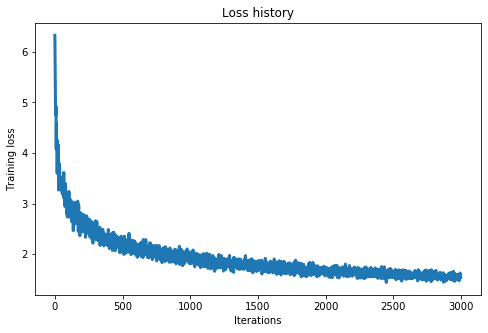

In [12]:
from model.LinearClassifier import LinearClassifier
from visualization.utils import visualize_loss
import itertools as it
results = {}
best_val = -1
best_reg = -1
best_lr = -1
learning_rates = np.linspace(1e-8, 1e-6, 5)
regularization_strengths = np.linspace(1, 1e3, 3)
best_loss_history = None
best_classifier = None

##############################################################################
# TODO: Utilisez l'ensemble de validation pour régler les hyper-paramètres   #
#  (force de régularisation et vitesse d'apprentissage). Vous devez          #
#  expérimenter différentes plages de valeurs pour les taux d'apprentissage  #
#  et les forces de régularisation; si tout va bien, avec num_iter = 3000    #
#  vous devriez obtenir une précision de classification supérieur à 0.30 sur #
#  l'ensemble de validation, et de 0.36 sur l'ensemble de test.              #
#  Mettre les résultats des meilleurs hyper-paramètres dans les variables    #
#  best_XYZ ci haut.                                                         #
##############################################################################

for lr in learning_rates:
    for reg in regularization_strengths:
        classifier = LinearClassifier(hinge_forward_backward)
        train_loss_history = classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iter=3000, verbose = True)
        y_val_pred = classifier.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        if(acc_val > best_val):
            best_val = acc_val
            best_reg = reg
            best_lr = lr
            best_loss_history = train_loss_history
            best_classifier = classifier

################################################################################
#                             FIN DE VOTRE CODE                                #
################################################################################
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

visualize_loss(best_loss_history)

In [13]:
# En réentraine avec plus d'itérations
classifier = LinearClassifier(hinge_forward_backward)
train_loss_history = classifier.train(X_train, y_train, learning_rate=best_lr, reg=best_reg, num_iter=6000, verbose = True)

# On évalue la performance sur l'ensemble de test
y_test_pred = best_classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Linear model with Hinge loss : CIFAR-10 final test accuracy: %f' % (test_accuracy) )

loss :  6.548656030982909
loss :  5.618879586619917
loss :  5.165454053646892
loss :  4.909587920832598
loss :  5.0289226257836095
loss :  4.739121555181723
loss :  4.776311434756618
loss :  4.775608036415715
loss :  4.8402703257933215
loss :  4.347821065986095
loss :  4.834646389576389
loss :  4.055539022908082
loss :  4.51804790400628
loss :  4.265772682894628
loss :  4.309528447564543
loss :  4.079811174358975
loss :  4.085396398941097
loss :  3.7605605606725807
loss :  4.358614330267685
loss :  4.2909939398998125
loss :  4.013634933831884
loss :  3.66299375141522
loss :  4.157002737266277
loss :  3.853838174230466
loss :  3.869328249391017
loss :  4.067613208247841
loss :  3.8338422349438757
loss :  3.9639810817335177
loss :  3.8956561854630034
loss :  3.5811424481045186
loss :  3.533435026430534
loss :  3.75318653802446
loss :  3.7252730539087846
loss :  3.6204028351491178
loss :  3.564449356667964
loss :  3.563081154023514
loss :  3.6155021832547916
loss :  3.6845395354773585
los

loss :  2.3729606658551186
loss :  2.458775959952105
loss :  2.352622582966363
loss :  2.396009205588829
loss :  2.355032419098363
loss :  2.500342547348348
loss :  2.3711072031979348
loss :  2.465149899074115
loss :  2.4421925843642684
loss :  2.632311183120305
loss :  2.355934426564734
loss :  2.46891850463508
loss :  2.4014923677552598
loss :  2.38169013004848
loss :  2.2396019485046263
loss :  2.3261584365768813
loss :  2.285155674476883
loss :  2.2368058940533526
loss :  2.2575107427359735
loss :  2.3407862071785255
loss :  2.3773633561741834
loss :  2.4191726830246973
loss :  2.446851084739362
loss :  2.4510653827530855
loss :  2.4621526190125063
loss :  2.333975362398042
loss :  2.462254508195714
loss :  2.4134060453116435
loss :  2.2442036891460826
loss :  2.3676645482519074
loss :  2.4500523677551316
loss :  2.5975013908178757
loss :  2.2389967924572214
loss :  2.258348390639092
loss :  2.2276834819970084
loss :  2.4124917194898376
loss :  2.40520122439627
loss :  2.2449376153

loss :  2.06541284771657
loss :  2.139857514257713
loss :  2.0912738853662436
loss :  2.1745137578834317
loss :  2.129050739072616
loss :  2.0334886953010893
loss :  2.0514816922106007
loss :  2.082018473109382
loss :  2.2140845431734353
loss :  2.1107443029695467
loss :  2.0554620843808196
loss :  2.300641908077913
loss :  2.1160027073746845
loss :  2.0726750594088603
loss :  2.0628737862309605
loss :  2.06096677457632
loss :  2.0988561488880966
loss :  2.0180771822613788
loss :  2.0394878790606605
loss :  2.0764396262288844
loss :  2.117488871972752
loss :  2.1495306811639265
loss :  2.0064974873164982
loss :  2.14477397955435
loss :  2.0739718774471756
loss :  2.1090306012835285
loss :  2.047500302172726
loss :  2.094714555788744
loss :  2.0334262693555076
loss :  2.096043146635563
loss :  2.0605708426012175
loss :  2.104961673375304
loss :  2.0552600300802686
loss :  2.2022084517855673
loss :  2.128701195623273
loss :  2.1625424622018015
loss :  1.9994485725795528
loss :  2.1364761

loss :  1.8767407629650454
loss :  1.9660192221243198
loss :  2.1176003110038346
loss :  1.8089615007626034
loss :  1.8460533822027483
loss :  2.026266355934253
loss :  1.937057661302445
loss :  1.961158695049171
loss :  1.9181056398722758
loss :  1.9756882418454722
loss :  1.9463098538181776
loss :  1.9574756383445011
loss :  1.7940726003972758
loss :  1.8977576509321443
loss :  1.9670707317394527
loss :  1.9594304969583844
loss :  1.7838317273565318
loss :  2.0708350606312376
loss :  2.012637584600104
loss :  1.8952075347538488
loss :  1.964044234656944
loss :  2.0687650813141523
loss :  1.9607321775350235
loss :  1.878809222962138
loss :  2.120559675660616
loss :  1.8819460275198943
loss :  1.8881196234754265
loss :  2.0226848771368484
loss :  1.9555238339889331
loss :  1.8331815363658754
loss :  1.8932782725187776
loss :  1.8478750801081634
loss :  1.9203466783274588
loss :  1.9219488598950767
loss :  1.8242929809828992
loss :  1.9969039292525421
loss :  2.039431700805843
loss :  1

loss :  1.8004251091767849
loss :  1.8149775838643085
loss :  1.933007640924314
loss :  1.8159975414427294
loss :  1.7039629834940866
loss :  1.7950216228867382
loss :  1.7349432285818067
loss :  1.773458929828031
loss :  1.7613806007643487
loss :  1.9426660876837087
loss :  1.789119224241815
loss :  1.8136500775399202
loss :  1.8345875913309238
loss :  1.8028805119956286
loss :  1.8241380812067909
loss :  1.836165843017427
loss :  1.7852738726846147
loss :  1.9481972965254741
loss :  1.8918159349965504
loss :  1.7706553022155673
loss :  1.8480492682701308
loss :  1.940273461729314
loss :  1.7722045128957853
loss :  1.8044570206080754
loss :  1.9276232376093005
loss :  1.8642574531783183
loss :  1.8464417335071335
loss :  1.7802065747837912
loss :  1.850695057312976
loss :  1.9006301986195142
loss :  1.8683363782061775
loss :  1.7479637869023827
loss :  1.959593097185172
loss :  1.7434529959979495
loss :  1.8471112475014269
loss :  1.7968584486910362
loss :  1.8164155356569613
loss :  

loss :  1.7288098757555883
loss :  1.7355315842922
loss :  1.724824401631053
loss :  1.667873970807308
loss :  1.778824787581442
loss :  1.7630319721041285
loss :  1.7848926594186008
loss :  1.734649726271353
loss :  1.736971841254607
loss :  1.7180094974421103
loss :  1.711632479284184
loss :  1.6879757312476429
loss :  1.7865006666242056
loss :  1.8082899861196933
loss :  1.7243172016567292
loss :  1.7893583745873933
loss :  1.8110693028807345
loss :  1.6662285624108426
loss :  1.7768683284380893
loss :  1.723301518688408
loss :  1.7850731492526624
loss :  1.8342063097864274
loss :  1.699651135997252
loss :  1.7732328896739398
loss :  1.8039432553528956
loss :  1.774331650216228
loss :  1.778284633643838
loss :  1.6577407873580183
loss :  1.7237736635890242
loss :  1.659047894837704
loss :  1.7576078123250256
loss :  1.8471651945124261
loss :  1.8002841818149324
loss :  1.754208880615373
loss :  1.7170661362335817
loss :  1.75695315204549
loss :  1.768044570233119
loss :  1.789570969

loss :  1.6989826378341542
loss :  1.7066428956253867
loss :  1.7013545264412044
loss :  1.6496259047561057
loss :  1.6712792644784238
loss :  1.729795059109624
loss :  1.6559511880729292
loss :  1.6742400308510088
loss :  1.655348624310938
loss :  1.672305389509196
loss :  1.7225478853745033
loss :  1.7306893104922165
loss :  1.6430986271688466
loss :  1.6761753582715506
loss :  1.7685612787739928
loss :  1.7362146640261287
loss :  1.7157338133845368
loss :  1.6007494572621235
loss :  1.7037615865926046
loss :  1.6602154683938852
loss :  1.6571231591900357
loss :  1.6159143493567898
loss :  1.7646377549341412
loss :  1.6635844162659676
loss :  1.5411344781623932
loss :  1.6846712766286935
loss :  1.6820767515689987
loss :  1.6275296676245852
loss :  1.7439567848968516
loss :  1.6891226647400908
loss :  1.828860176582478
loss :  1.7294451747288262
loss :  1.6137088739357555
loss :  1.6574648631566573
loss :  1.7238446531267935
loss :  1.7211595351130171
loss :  1.6253057668186692
loss 

loss :  1.7617957062811302
loss :  1.5502616523119843
loss :  1.632986866260392
loss :  1.6619171371700656
loss :  1.6200173168606546
loss :  1.6346753720589606
loss :  1.641204383062593
loss :  1.6693215085106885
loss :  1.6177386345773601
loss :  1.5436490259419708
loss :  1.6262654599719806
loss :  1.6770118959349305
loss :  1.5955162882260243
loss :  1.6010555222853975
loss :  1.5833382933653275
loss :  1.6928645091728876
loss :  1.6228674220070136
loss :  1.5863752262776456
loss :  1.606396633617965
loss :  1.5975451133942051
loss :  1.564834345098856
loss :  1.595063941448986
loss :  1.6999178870394882
loss :  1.6935535589925172
loss :  1.681232370059286
loss :  1.5999013550768375
loss :  1.6140466912386124
loss :  1.5596804781598523
loss :  1.5718120763316308
loss :  1.6071151609534664
loss :  1.6287429584739928
loss :  1.65538177200229
loss :  1.5440805290202195
loss :  1.6477405598476462
loss :  1.6280940366363439
loss :  1.615762903281605
loss :  1.638420929928542
loss :  1.6

loss :  1.5694178160675176
loss :  1.585529377013321
loss :  1.5027987574704849
loss :  1.5344767845256542
loss :  1.5847747685306068
loss :  1.6288895775824144
loss :  1.5666876254302842
loss :  1.5707771820428718
loss :  1.5484123085248398
loss :  1.6324507568828788
loss :  1.568448488441442
loss :  1.611147498203816
loss :  1.6140526473197305
loss :  1.648356125545297
loss :  1.6209462327362758
loss :  1.6016474043694593
loss :  1.5269264656581465
loss :  1.5814775673542465
loss :  1.5304420328950703
loss :  1.5778142107391195
loss :  1.5943762476259724
loss :  1.5491511036864345
loss :  1.6397315687526792
loss :  1.5606147171021212
loss :  1.5694662429324888
loss :  1.6175064833077033
loss :  1.5274672016230633
loss :  1.6347098557335857
loss :  1.5612958611642638
loss :  1.584854584052003
loss :  1.6110674665734945
loss :  1.5452620673808866
loss :  1.6241293609367948
loss :  1.6451198295628657
loss :  1.6113571844742314
loss :  1.5860949867736793
loss :  1.5369210666442967
loss :

loss :  1.5411321163345821
loss :  1.528234803526552
loss :  1.5961369437719164
loss :  1.508915376760192
loss :  1.5033761919846338
loss :  1.5065219121630926
loss :  1.5620313267256278
loss :  1.458939195370605
loss :  1.5031167954983105
loss :  1.532239536364961
loss :  1.577832652257948
loss :  1.4870199661914727
loss :  1.5132080299524704
loss :  1.501342983414665
loss :  1.5474267267705601
loss :  1.5902361859056355
loss :  1.5480524018110464
loss :  1.5375707804080292
loss :  1.579942023792003
loss :  1.5106251172332887
loss :  1.540444735314656
loss :  1.573915133947218
loss :  1.4559856675512475
loss :  1.5698774655329146
loss :  1.571883052192336
loss :  1.5264438262737898
loss :  1.5015384401930207
loss :  1.5535120074315725
loss :  1.5187887445260793
loss :  1.4746104785543133
loss :  1.5635407878129417
loss :  1.5370453125243602
loss :  1.4849747988900317
loss :  1.4817671744294734
loss :  1.5540081508650565
loss :  1.5113535693876838
loss :  1.475217748279792
loss :  1.54

loss :  1.4233128242524271
loss :  1.4664430998319673
loss :  1.447656798774522
loss :  1.4969861824054431
loss :  1.531537780407466
loss :  1.5391743082255602
loss :  1.5444725309798937
loss :  1.4962282282270645
loss :  1.4971156367024505
loss :  1.4947383042271793
loss :  1.4832622308552827
loss :  1.5105919926702511
loss :  1.4669152074002088
loss :  1.531819844436739
loss :  1.5489490970199906
loss :  1.4912098369728528
loss :  1.5383844262530857
loss :  1.494393936404888
loss :  1.4311141378846317
loss :  1.4667936061613653
loss :  1.456312184403967
loss :  1.5646912282853516
loss :  1.5337381158715524
loss :  1.5208535761979265
loss :  1.496946213571739
loss :  1.5246553575614081
loss :  1.5535787439434043
loss :  1.4755452924446586
loss :  1.4434174547973218
loss :  1.4920529738573793
loss :  1.4663465206368138
loss :  1.5097288862400455
loss :  1.5370909150484904
loss :  1.5145180636588815
loss :  1.475219125021594
loss :  1.464373201951403
loss :  1.4779500081239314
loss :  1

loss :  1.4458583340298685
loss :  1.512967002033107
loss :  1.5197187570844575
loss :  1.405595772805657
loss :  1.5061213252589551
loss :  1.4854750787871382
loss :  1.4671548224221413
loss :  1.473387125211824
loss :  1.5106234140591834
loss :  1.5098210419932712
loss :  1.5063571490461185
loss :  1.4855468278510326
loss :  1.549390807660978
loss :  1.5102839702961928
loss :  1.5214038477163236
loss :  1.428339432557632
loss :  1.479319270611545
loss :  1.459625911019266
loss :  1.5662777161132317
loss :  1.536726119341403
loss :  1.5208055919041843
loss :  1.4339421943646788
loss :  1.4220623891998383
loss :  1.5278481705088356
loss :  1.508864128489635
loss :  1.445235255377235
loss :  1.4235588465574833
loss :  1.5305259481924947
loss :  1.459455306819518
loss :  1.493037395619653
loss :  1.4967030724197616
loss :  1.4210429822057364
loss :  1.4433147724520443
loss :  1.5206417098559504
loss :  1.499146148467915
loss :  1.5054881746161535
loss :  1.4067690665659907
loss :  1.4298

loss :  1.443437454760026
loss :  1.4176056581378813
loss :  1.509781783776422
loss :  1.4149340366603207
loss :  1.42550709438976
loss :  1.443673105210428
loss :  1.451572076053916
loss :  1.4942547033430793
loss :  1.3880651097340673
loss :  1.4931913006610251
loss :  1.4622476869837258
loss :  1.4663642778561012
loss :  1.4589387148455812
loss :  1.5006772310873868
loss :  1.4450182073396485
loss :  1.3928547333539725
loss :  1.4815739859602206
loss :  1.5469022142856808
loss :  1.4343124701599295
loss :  1.5188697718788209
loss :  1.527903184753626
loss :  1.474716158297976
loss :  1.4081526391643415
loss :  1.484877996428927
loss :  1.4227994837193763
loss :  1.4775964107157329
loss :  1.4454340268248886
loss :  1.4512304041837871
loss :  1.508844701295475
loss :  1.4618180527725446
loss :  1.4573440137977784
loss :  1.4507830753078423
loss :  1.4885172941435136
loss :  1.4010821601012133
loss :  1.505360371188209
loss :  1.4949784408362872
loss :  1.477555261780332
loss :  1.464

loss :  1.4381086178382856
loss :  1.3886593851190798
loss :  1.4024919050005389
loss :  1.4144733150073399
loss :  1.4295711366359916
loss :  1.4125081757980849
loss :  1.4348623485106458
loss :  1.4534473552695406
loss :  1.4258120230404574
loss :  1.4194920647122689
loss :  1.5467467857767037
loss :  1.3528979263908665
loss :  1.41143969463799
loss :  1.501384727185227
loss :  1.4208860119108184
loss :  1.4326352719295654
loss :  1.4167030700697394
loss :  1.4426467246580816
loss :  1.4919356588342145
loss :  1.4811600887052645
loss :  1.3699027819310146
loss :  1.4110415092586788
loss :  1.4292467542839713
loss :  1.445454648090569
loss :  1.372252866158554
loss :  1.3679904424991005
loss :  1.4668574251685615
loss :  1.4179434898016963
loss :  1.5012894445283718
loss :  1.4057826889438103
loss :  1.4785067957074665
loss :  1.4687156977407456
loss :  1.4629937285508146
loss :  1.5068262650239266
loss :  1.4615559401401745
loss :  1.443416615345365
loss :  1.4555888329826212
loss : 

loss :  1.4068137775313594
loss :  1.4571466760770375
loss :  1.482671134792716
loss :  1.4509692676531807
loss :  1.4388123595350077
loss :  1.4451227588034228
loss :  1.426334796197969
loss :  1.4350720922833506
loss :  1.4051966225484802
loss :  1.3683205669213419
loss :  1.4743150602763637
loss :  1.4564045425774343
loss :  1.4257748187666426
loss :  1.4644561944012242
loss :  1.3940312231216105
loss :  1.4390545661051157
loss :  1.4630228841496176
loss :  1.437591896473948
loss :  1.3600396854643062
loss :  1.3994435625975217
loss :  1.4157996242439999
loss :  1.451852083169593
loss :  1.4218670462877392
loss :  1.4140609446187877
loss :  1.4252095399140183
loss :  1.5085656209925444
loss :  1.487204726238045
loss :  1.4322953997364842
loss :  1.4082633870340149
loss :  1.4723285081750008
loss :  1.4047672236229973
loss :  1.4322509036523474
loss :  1.4217708642435007
loss :  1.4997509595308067
loss :  1.3952778743609238
loss :  1.4781880810176182
loss :  1.4390701890387982
loss :

loss :  1.4567674871532912
loss :  1.3782114373086876
loss :  1.3992219932590038
loss :  1.4393318372603323
loss :  1.369511887586436
loss :  1.3681903018126698
loss :  1.4482229876603403
loss :  1.3814780209120918
loss :  1.4379823201358477
loss :  1.3673681794238655
loss :  1.4021270144837645
loss :  1.4112372825989552
loss :  1.4261395004063728
loss :  1.438513152653482
loss :  1.4179653513491564
loss :  1.4706802091219293
loss :  1.4632940387388738
loss :  1.439098654628281
loss :  1.3792532222544582
loss :  1.4297556116837449
loss :  1.4368690913525342
loss :  1.3995434352252254
loss :  1.412567776517748
loss :  1.434623212443176
loss :  1.4325460857548267
loss :  1.3934616882084925
loss :  1.4011443271217034
loss :  1.4148942834187792
loss :  1.3739014419143478
loss :  1.4262491667253057
loss :  1.4579458192904156
loss :  1.363422834846894
loss :  1.433897685647796
loss :  1.4631949832921607
loss :  1.4086298102321815
loss :  1.4152231525502537
loss :  1.3789516639962647
loss :  

loss :  1.3676998865822492
loss :  1.4065878597558035
loss :  1.4336119377737604
loss :  1.3386023925466004
loss :  1.407822558655542
loss :  1.4426221332901052
loss :  1.4079660735355852
loss :  1.419597749260779
loss :  1.459478526243479
loss :  1.3938238736814406
loss :  1.3941383710104156
loss :  1.3616281311898326
loss :  1.3809853077322256
loss :  1.403837150583901
loss :  1.4084890972463342
loss :  1.4041087577968079
loss :  1.3860593014652856
loss :  1.382013655454741
loss :  1.4564538427635085
loss :  1.4213043689830323
loss :  1.4217681165341338
loss :  1.398566015617629
loss :  1.4819202841496013
loss :  1.4178290460714442
loss :  1.378446477296615
loss :  1.427041136847775
loss :  1.4474673650719314
loss :  1.4015641998788422
loss :  1.3416106052141077
loss :  1.4099805318423215
loss :  1.4659461058933352
loss :  1.4679270233124941
loss :  1.4084409833878095
loss :  1.4088440418169705
loss :  1.388103959698878
loss :  1.4085419724707804
loss :  1.4012123270633958
loss :  1.

loss :  1.4067816121980974
loss :  1.3904904925252786
loss :  1.3522476373868293
loss :  1.3664953512021547
loss :  1.3875258866653235
loss :  1.3865459764691068
loss :  1.3931023608834079
loss :  1.3864247572266573
loss :  1.4103905912605945
loss :  1.354658515408602
loss :  1.358624781676441
loss :  1.412837660934704
loss :  1.3350460829217385
loss :  1.3604995401245836
loss :  1.3783998337835528
loss :  1.3843543554968643
loss :  1.3668039571668484
loss :  1.307856569932283
loss :  1.391362213822789
loss :  1.3573621315376738
loss :  1.4089396432185595
loss :  1.4134371436645432
loss :  1.3577222949311893
loss :  1.443210354871402
loss :  1.3582989740899192
loss :  1.3963967957249372
loss :  1.4080455011632438
loss :  1.3527098072848955
loss :  1.367530750897156
loss :  1.340647773957075
loss :  1.3568226071920202
loss :  1.3764310670471036
loss :  1.390275674104705
loss :  1.4014873137139545
loss :  1.3477722601533906
loss :  1.386304338952148
loss :  1.3967502405907952
loss :  1.4

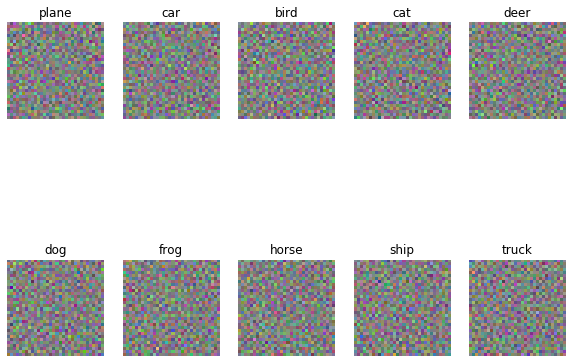

In [14]:
# Visualisation des poids appris pour chaque classe
w = best_classifier.W[:-1,:] # retire le biais
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Redimensionne les poids pour qu'ils soient entre 0 et 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])